# Brain Tumor Classification


In [1]:
import keras
keras.__version__
from keras import backend as K
#K.tensorflow_backend._get_available_gpus()
import tensorflow as tf

from tensorflow.python.client import device_lib
local_device_protos = device_lib.list_local_devices()

for val in local_device_protos:
  print(val.device_type)


D0806 20:50:28.589895949      16 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D0806 20:50:28.589916421      16 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D0806 20:50:28.589919584      16 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D0806 20:50:28.589922162      16 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D0806 20:50:28.589924373      16 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D0806 20:50:28.589926982      16 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D0806 20:50:28.589929278      16 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D0806 20:50:28.

CPU
TPU_SYSTEM
TPU
TPU
TPU
TPU
TPU
TPU
TPU
TPU


## Connect to TPU


In [2]:
import keras
keras.backend.set_session("TPU")

In [3]:
pip install scikit-learn


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 5.9 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 37.2 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install missingno


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [7]:

import sys
import os
import math

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['figure.dpi'] = 300
%matplotlib inline
import seaborn as sns
import missingno as msno
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import *

from PIL import Image, ImageEnhance
from tensorflow.keras.preprocessing.image import *

In [8]:
import pathlib
import tensorflow as tf

train_dir = pathlib.Path('/kaggle/input/brain-tumor-classification-mri/Training')
test_dir = pathlib.Path('/kaggle/input/brain-tumor-classification-mri/Testing')
img_height=224
img_width=224

In [9]:
train_ds  = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=128)


Found 2870 files belonging to 4 classes.
Using 2296 files for training.


In [10]:
test_ds  = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=128)


Found 2870 files belonging to 4 classes.
Using 574 files for validation.


In [11]:
val_ds  = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  validation_split=None,
  subset=None,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=128)


Found 394 files belonging to 4 classes.


## Visualize the data distribution

In [12]:
import os
ROOT_DIR = r"/kaggle/input/brain-tumor-classification-mri"
TRAIN_DIR = os.path.join(ROOT_DIR, 'Training')
TEST_DIR = os.path.join(ROOT_DIR, 'Testing')
assert os.path.isdir(ROOT_DIR) and os.path.isdir(TRAIN_DIR) and os.path.isdir(TEST_DIR)
TUMOR_CLASS = ['meningioma_tumor', 'glioma_tumor', 'pituitary_tumor', 'no_tumor']
IMAGE_DATA_PATHS = [os.path.join(TRAIN_DIR, tumor_class) for tumor_class in TUMOR_CLASS]
TEST_DATA_PATHS = [os.path.join(TEST_DIR, tumor_class) for tumor_class in TUMOR_CLASS]

In [13]:
TEST_DATA_PATHS

['/kaggle/input/brain-tumor-classification-mri/Testing/meningioma_tumor',
 '/kaggle/input/brain-tumor-classification-mri/Testing/glioma_tumor',
 '/kaggle/input/brain-tumor-classification-mri/Testing/pituitary_tumor',
 '/kaggle/input/brain-tumor-classification-mri/Testing/no_tumor']

In [14]:
import pandas as pd
data_distribution_count = pd.Series([len(os.listdir(path)) for path in TEST_DATA_PATHS if os.path.exists(path) and os.path.isdir(path)],index = TUMOR_CLASS)
data_distribution_count

meningioma_tumor    115
glioma_tumor        100
pituitary_tumor      74
no_tumor            105
dtype: int64

In [15]:
data_distribution_count = pd.Series([len(os.listdir(path)) for path in IMAGE_DATA_PATHS if os.path.exists(path) and os.path.isdir(path)],index = TUMOR_CLASS)
data_distribution_count

meningioma_tumor    822
glioma_tumor        826
pituitary_tumor     827
no_tumor            395
dtype: int64

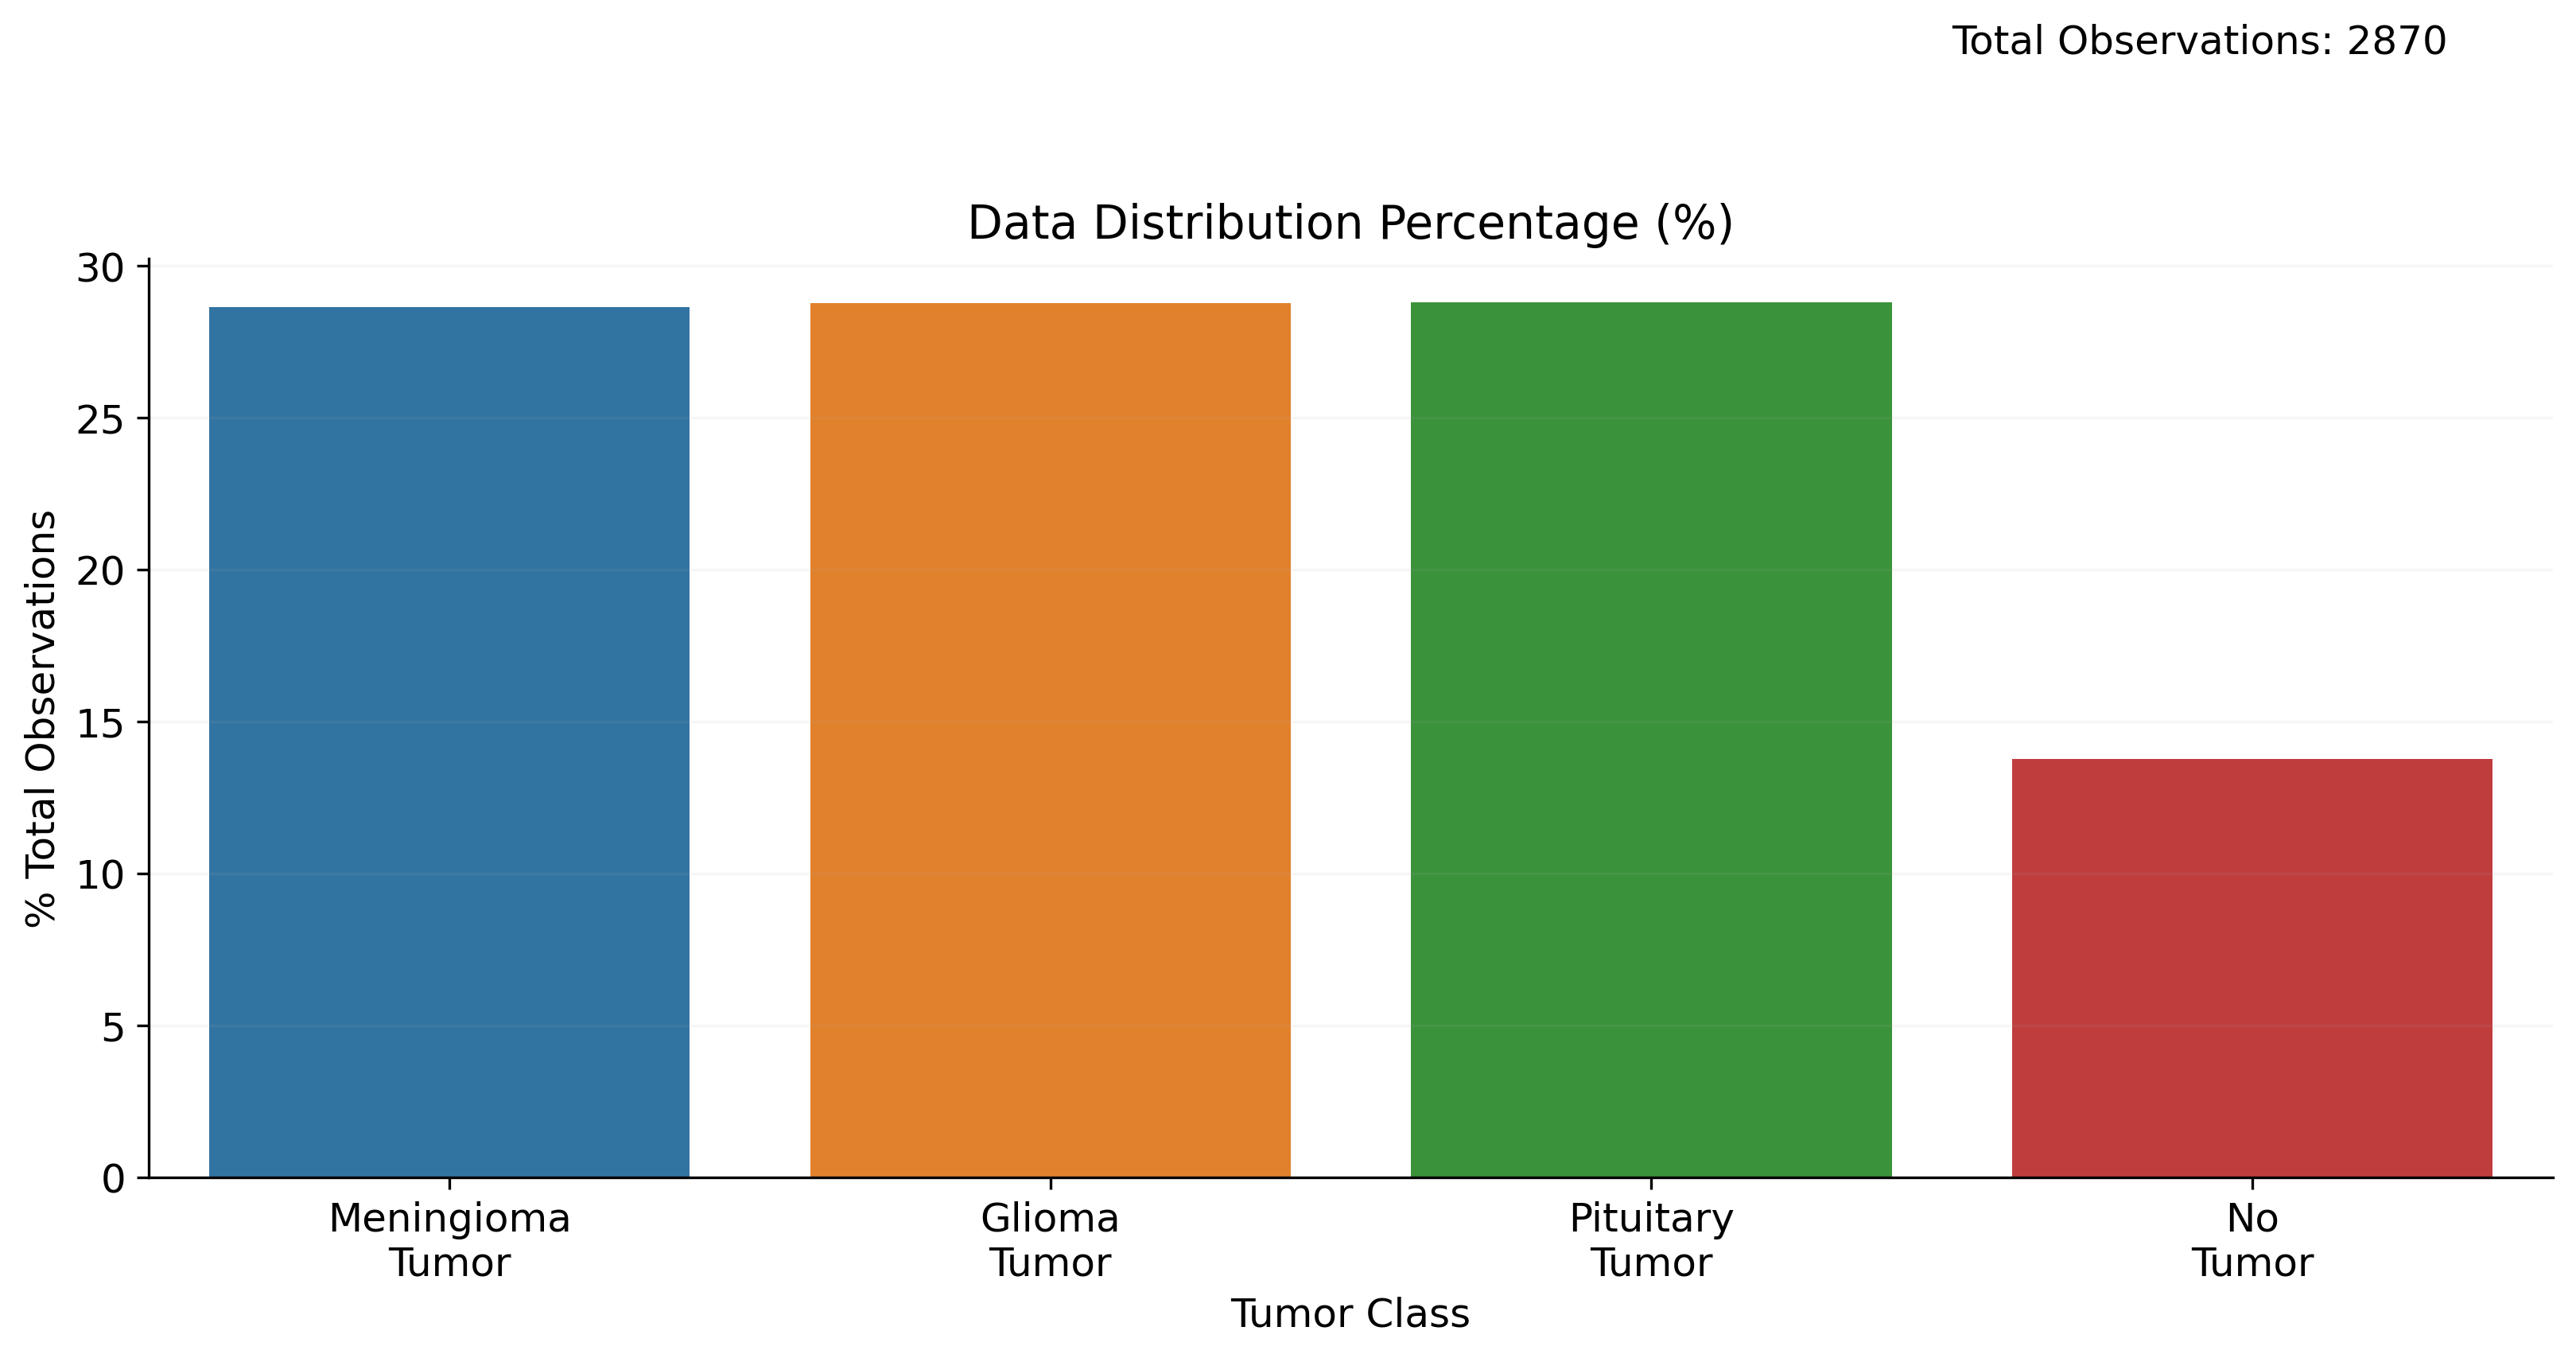

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, axis = plt.subplots(figsize = (13, 5))
axis.grid(True, alpha = 0.1)
axis.set_title("Data Distribution Percentage (%)", fontsize = 14)
sns.barplot(x = ['\n'.join(curr_index.strip().split('_')).title() for curr_index in data_distribution_count.index],
            y = 100 * (data_distribution_count / data_distribution_count.sum()), ax = axis)
axis.set_xlabel("Tumor Class", fontsize = 12)
axis.set_ylabel("% Total Observations", fontsize = 12)
axis.tick_params(which = 'major', labelsize = 12)
axis.text(2.5, 37, f'Total Observations: {data_distribution_count.sum()}', fontdict = dict(size = 12))
sns.despine()

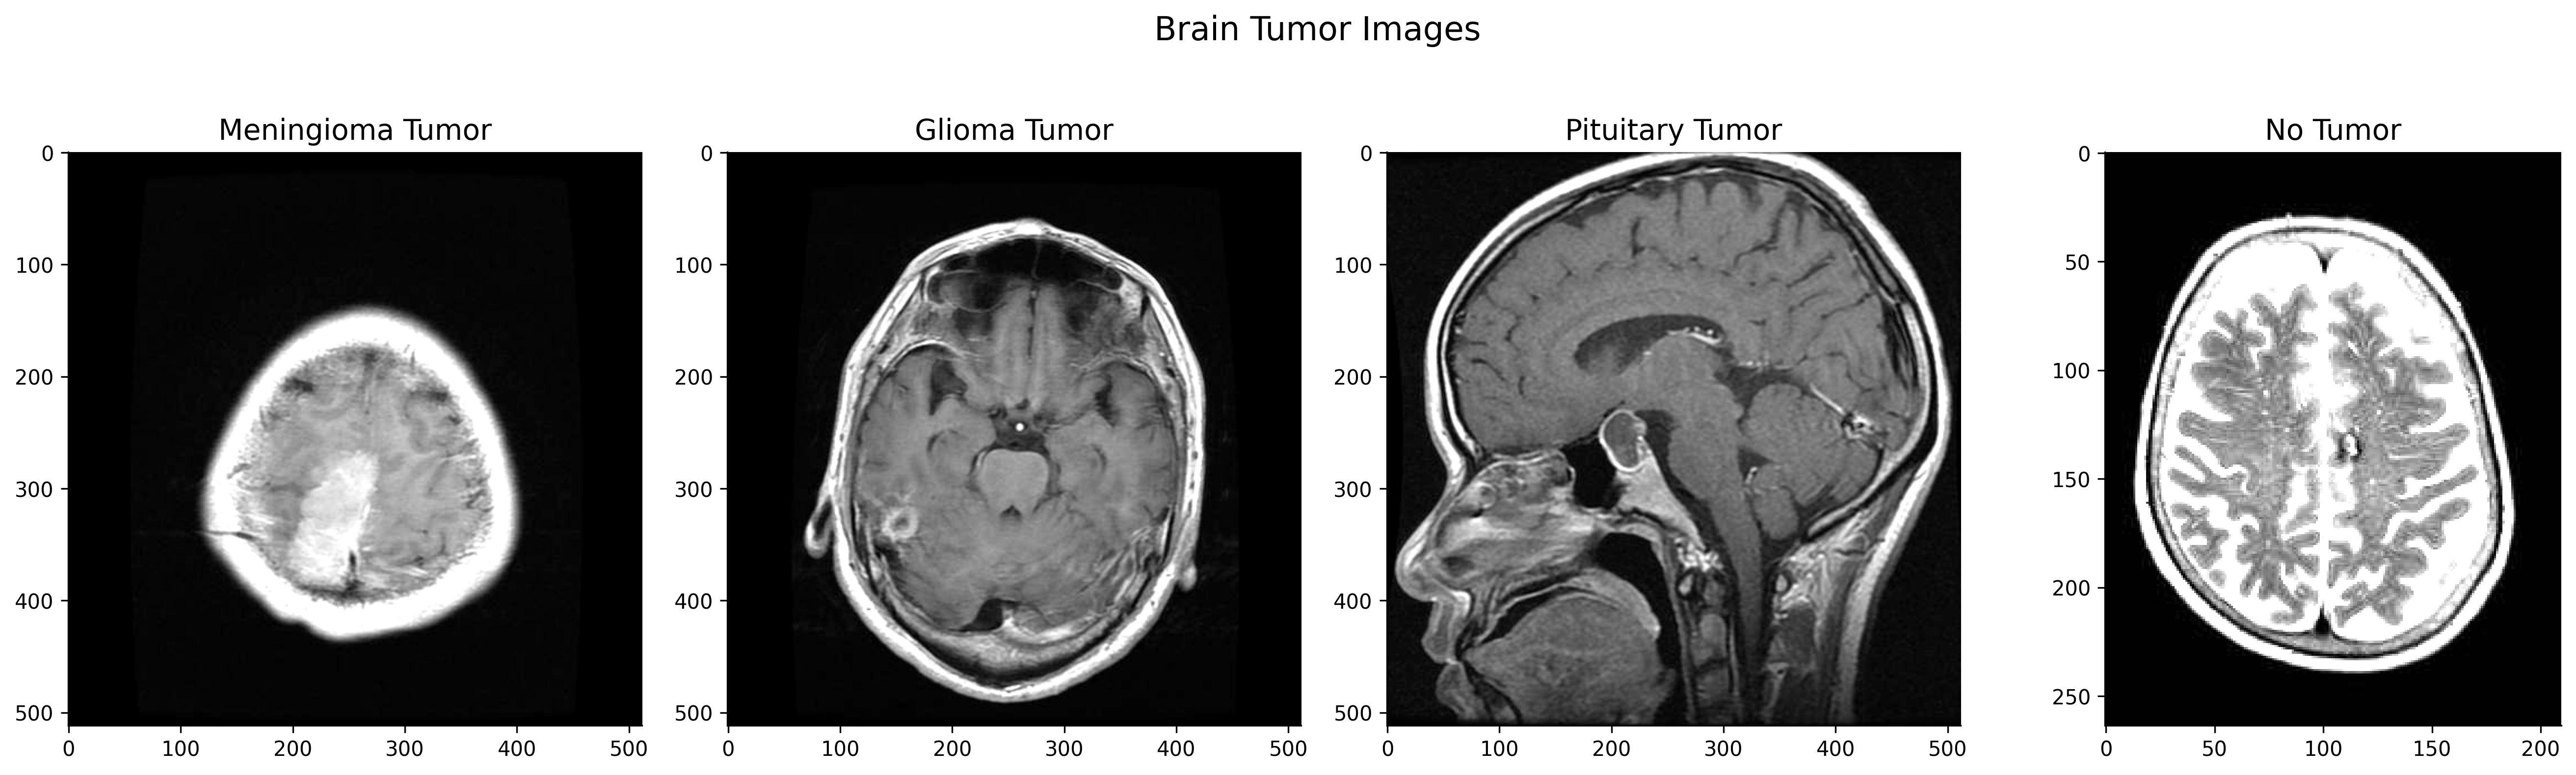

In [17]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance

BRIGHTNESS_FACTOR = 1.7
fig, axes = plt.subplots(nrows = 1, ncols = 4, figsize = (18, 5))
axes = axes.flatten()
fig.suptitle("Brain Tumor Images", fontsize = 16, fontdict = dict(weight = 'bold'), y = 1.04)
for curr_title, filename, curr_axis in zip(TUMOR_CLASS, IMAGE_DATA_PATHS, axes[:4]):
    curr_image = Image.open(os.path.join(filename, os.listdir(filename)[2]))
    img_enhancer = ImageEnhance.Brightness(curr_image)
    curr_axis.imshow(img_enhancer.enhance(BRIGHTNESS_FACTOR))
    curr_axis.set_title(" ".join(curr_title.split('_')).title(), fontsize = 14)

fig.tight_layout()
sns.despine()

## Image Augmentation

In [18]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [19]:
import numpy as np
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.97899187


In [20]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### 1. Inception V3

In [21]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from keras.layers import GlobalAveragePooling2D, Flatten, BatchNormalization, Dense, Dropout
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D

# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

# base_model1 = InceptionV3(
#                     input_shape=(224, 224, 3),
#                     weights='imagenet',
#                     include_top=False)
# # Freeze the first 10 layers
# for layer in base_model1.layers[:10]:
#     layer.trainable = False
# x = base_model1.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(512, activation='relu')(x)
# x = Dropout(0.4)(x)
# predictions1 = Dense(4, activation='softmax')(x)
# model1 = Model(inputs=base_model1.inputs, outputs=predictions1)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


In [22]:

# instantiating the model in the strategy scope creates the model on the TPU
with tpu_strategy.scope():
    base_model1 = InceptionV3(
                    input_shape=(224, 224, 3),
                    weights='imagenet',
                    include_top=False) # define your model normally
    for layer in base_model1.layers[:10]:
        layer.trainable = False
    x = base_model1.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.4)(x)
    predictions1 = Dense(4, activation='softmax')(x)
    model1 = Model(inputs=base_model1.inputs, outputs=predictions1)
    model1.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])
    # Print model summary
    model1.summary()

87910968/87910968 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                  

In [23]:
# model1.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

In [24]:
history1=model1.fit(
  train_ds,
  validation_data=test_ds,
  epochs=100)

model1.save('model1.h5')

Epoch 1/100


2023-08-06 20:52:25.979836: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-06 20:52:26.909137: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


18/18 [==============================] - ETA: 0s - loss: 0.7826 - accuracy: 0.7091

2023-08-06 20:54:00.192672: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-06 20:54:00.491019: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


18/18 [==============================] - 153s 5s/step - loss: 0.7826 - accuracy: 0.7091 - val_loss: 23.4187 - val_accuracy: 0.2892
Epoch 2/100
18/18 [==============================] - 3s 185ms/step - loss: 0.2908 - accuracy: 0.9016 - val_loss: 5.1266 - val_accuracy: 0.2892
Epoch 3/100
18/18 [==============================] - 3s 144ms/step - loss: 0.1276 - accuracy: 0.9652 - val_loss: 11.6566 - val_accuracy: 0.1394
Epoch 4/100
18/18 [==============================] - 3s 150ms/step - loss: 0.0983 - accuracy: 0.9743 - val_loss: 3.9014 - val_accuracy: 0.1411
Epoch 5/100
18/18 [==============================] - 2s 141ms/step - loss: 0.1045 - accuracy: 0.9639 - val_loss: 3.6030 - val_accuracy: 0.2178
Epoch 6/100
18/18 [==============================] - 3s 153ms/step - loss: 0.0678 - accuracy: 0.9778 - val_loss: 6.3348 - val_accuracy: 0.1638
Epoch 7/100
18/18 [==============================] - 2s 140ms/step - loss: 0.0897 - accuracy: 0.9717 - val_loss: 4.1177 - val_accuracy: 0.1760
Epoch 8/10

In [25]:
inceptionv3_evaluation = model1.evaluate(val_ds)
inceptionv3_evaluation[1]*100

4/4 [==============================] - 11s 3s/step - loss: 3.3699 - accuracy: 0.7437


74.36548471450806

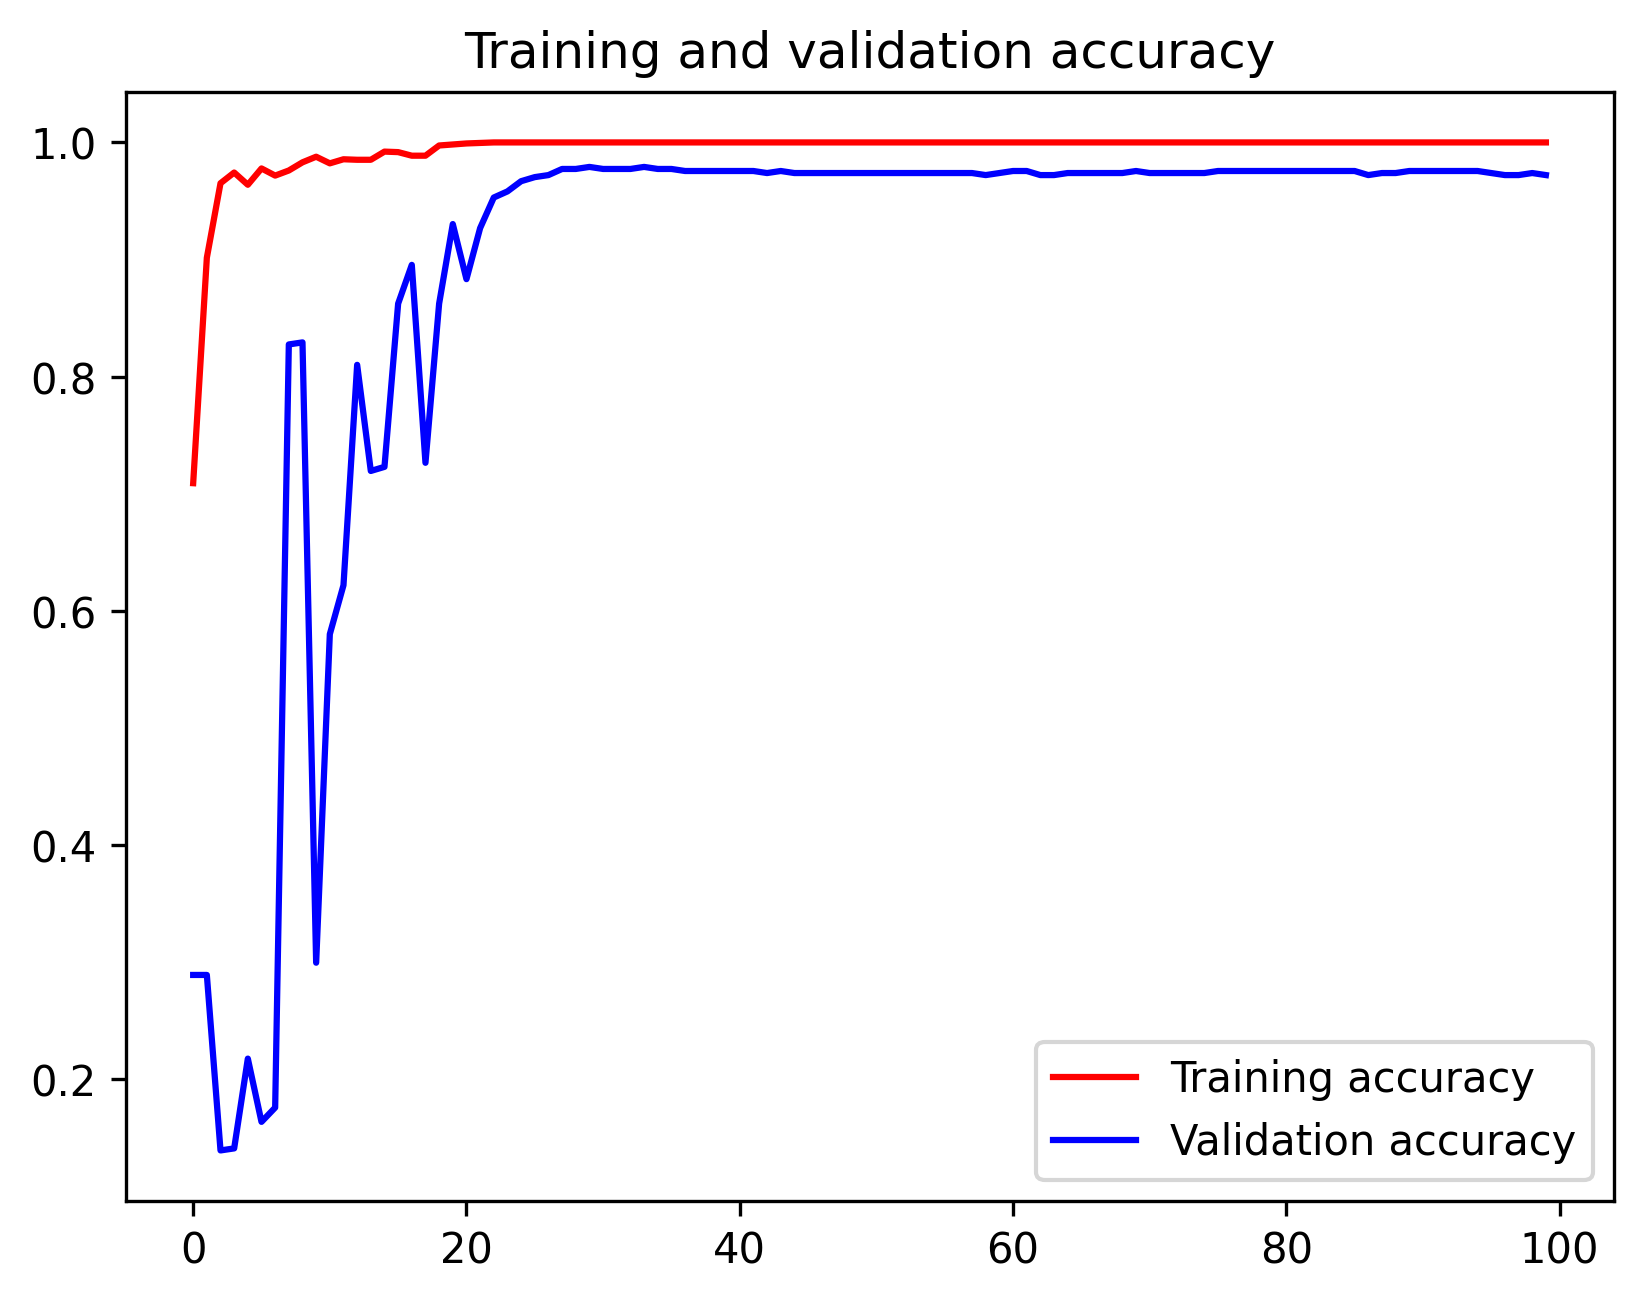

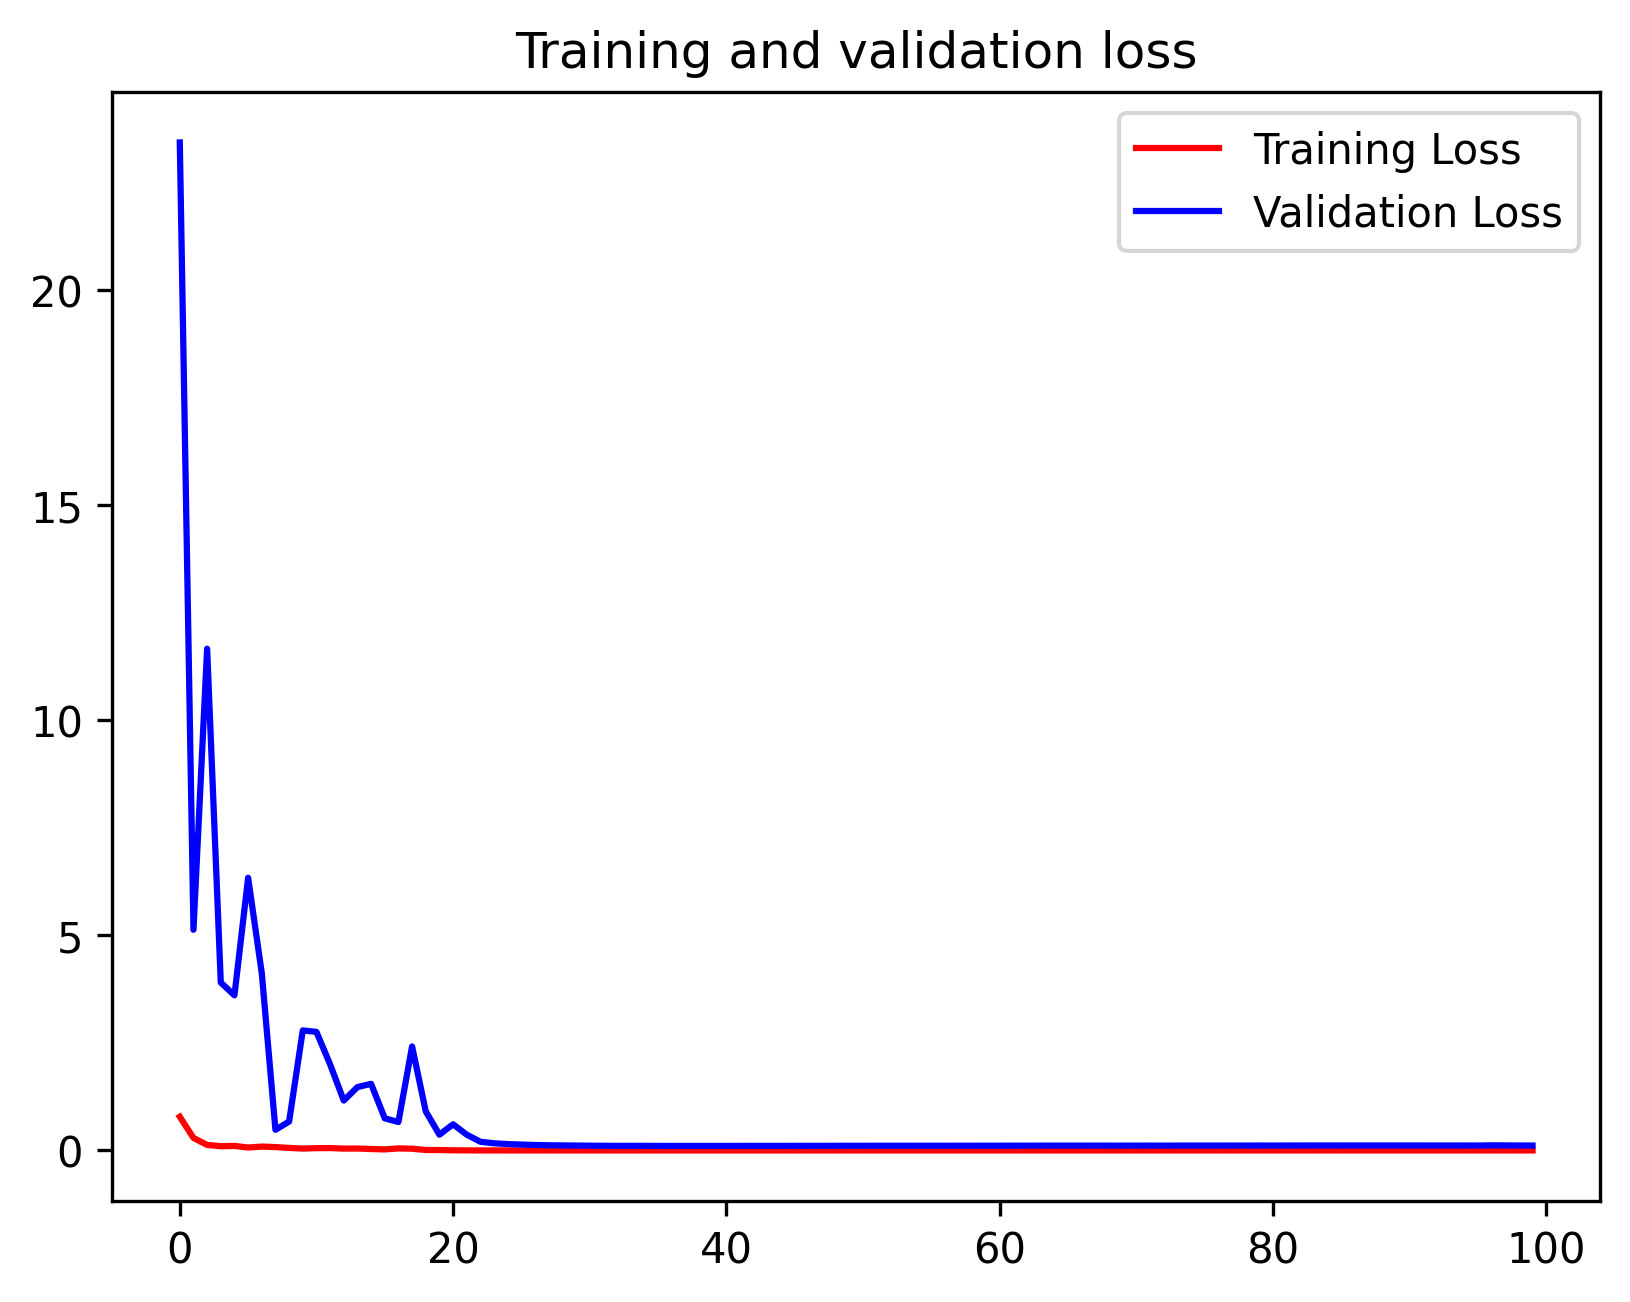

In [26]:
import matplotlib.pyplot as plt
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

2023-08-06 20:59:51.436339: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-06 20:59:51.608821: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


4/4 [==============================] - 1s 18ms/step


2023-08-06 21:00:09.591155: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-06 21:00:09.821040: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


1/1 [==============================] - 12s 12s/step
                  precision    recall  f1-score   support

meningioma_tumor       0.96      0.23      0.37       100
    glioma_tumor       0.67      0.97      0.79       115
 pituitary_tumor       0.72      0.97      0.83       105
        no_tumor       0.95      0.77      0.85        74

        accuracy                           0.75       394
       macro avg       0.82      0.74      0.71       394
    weighted avg       0.81      0.75      0.71       394



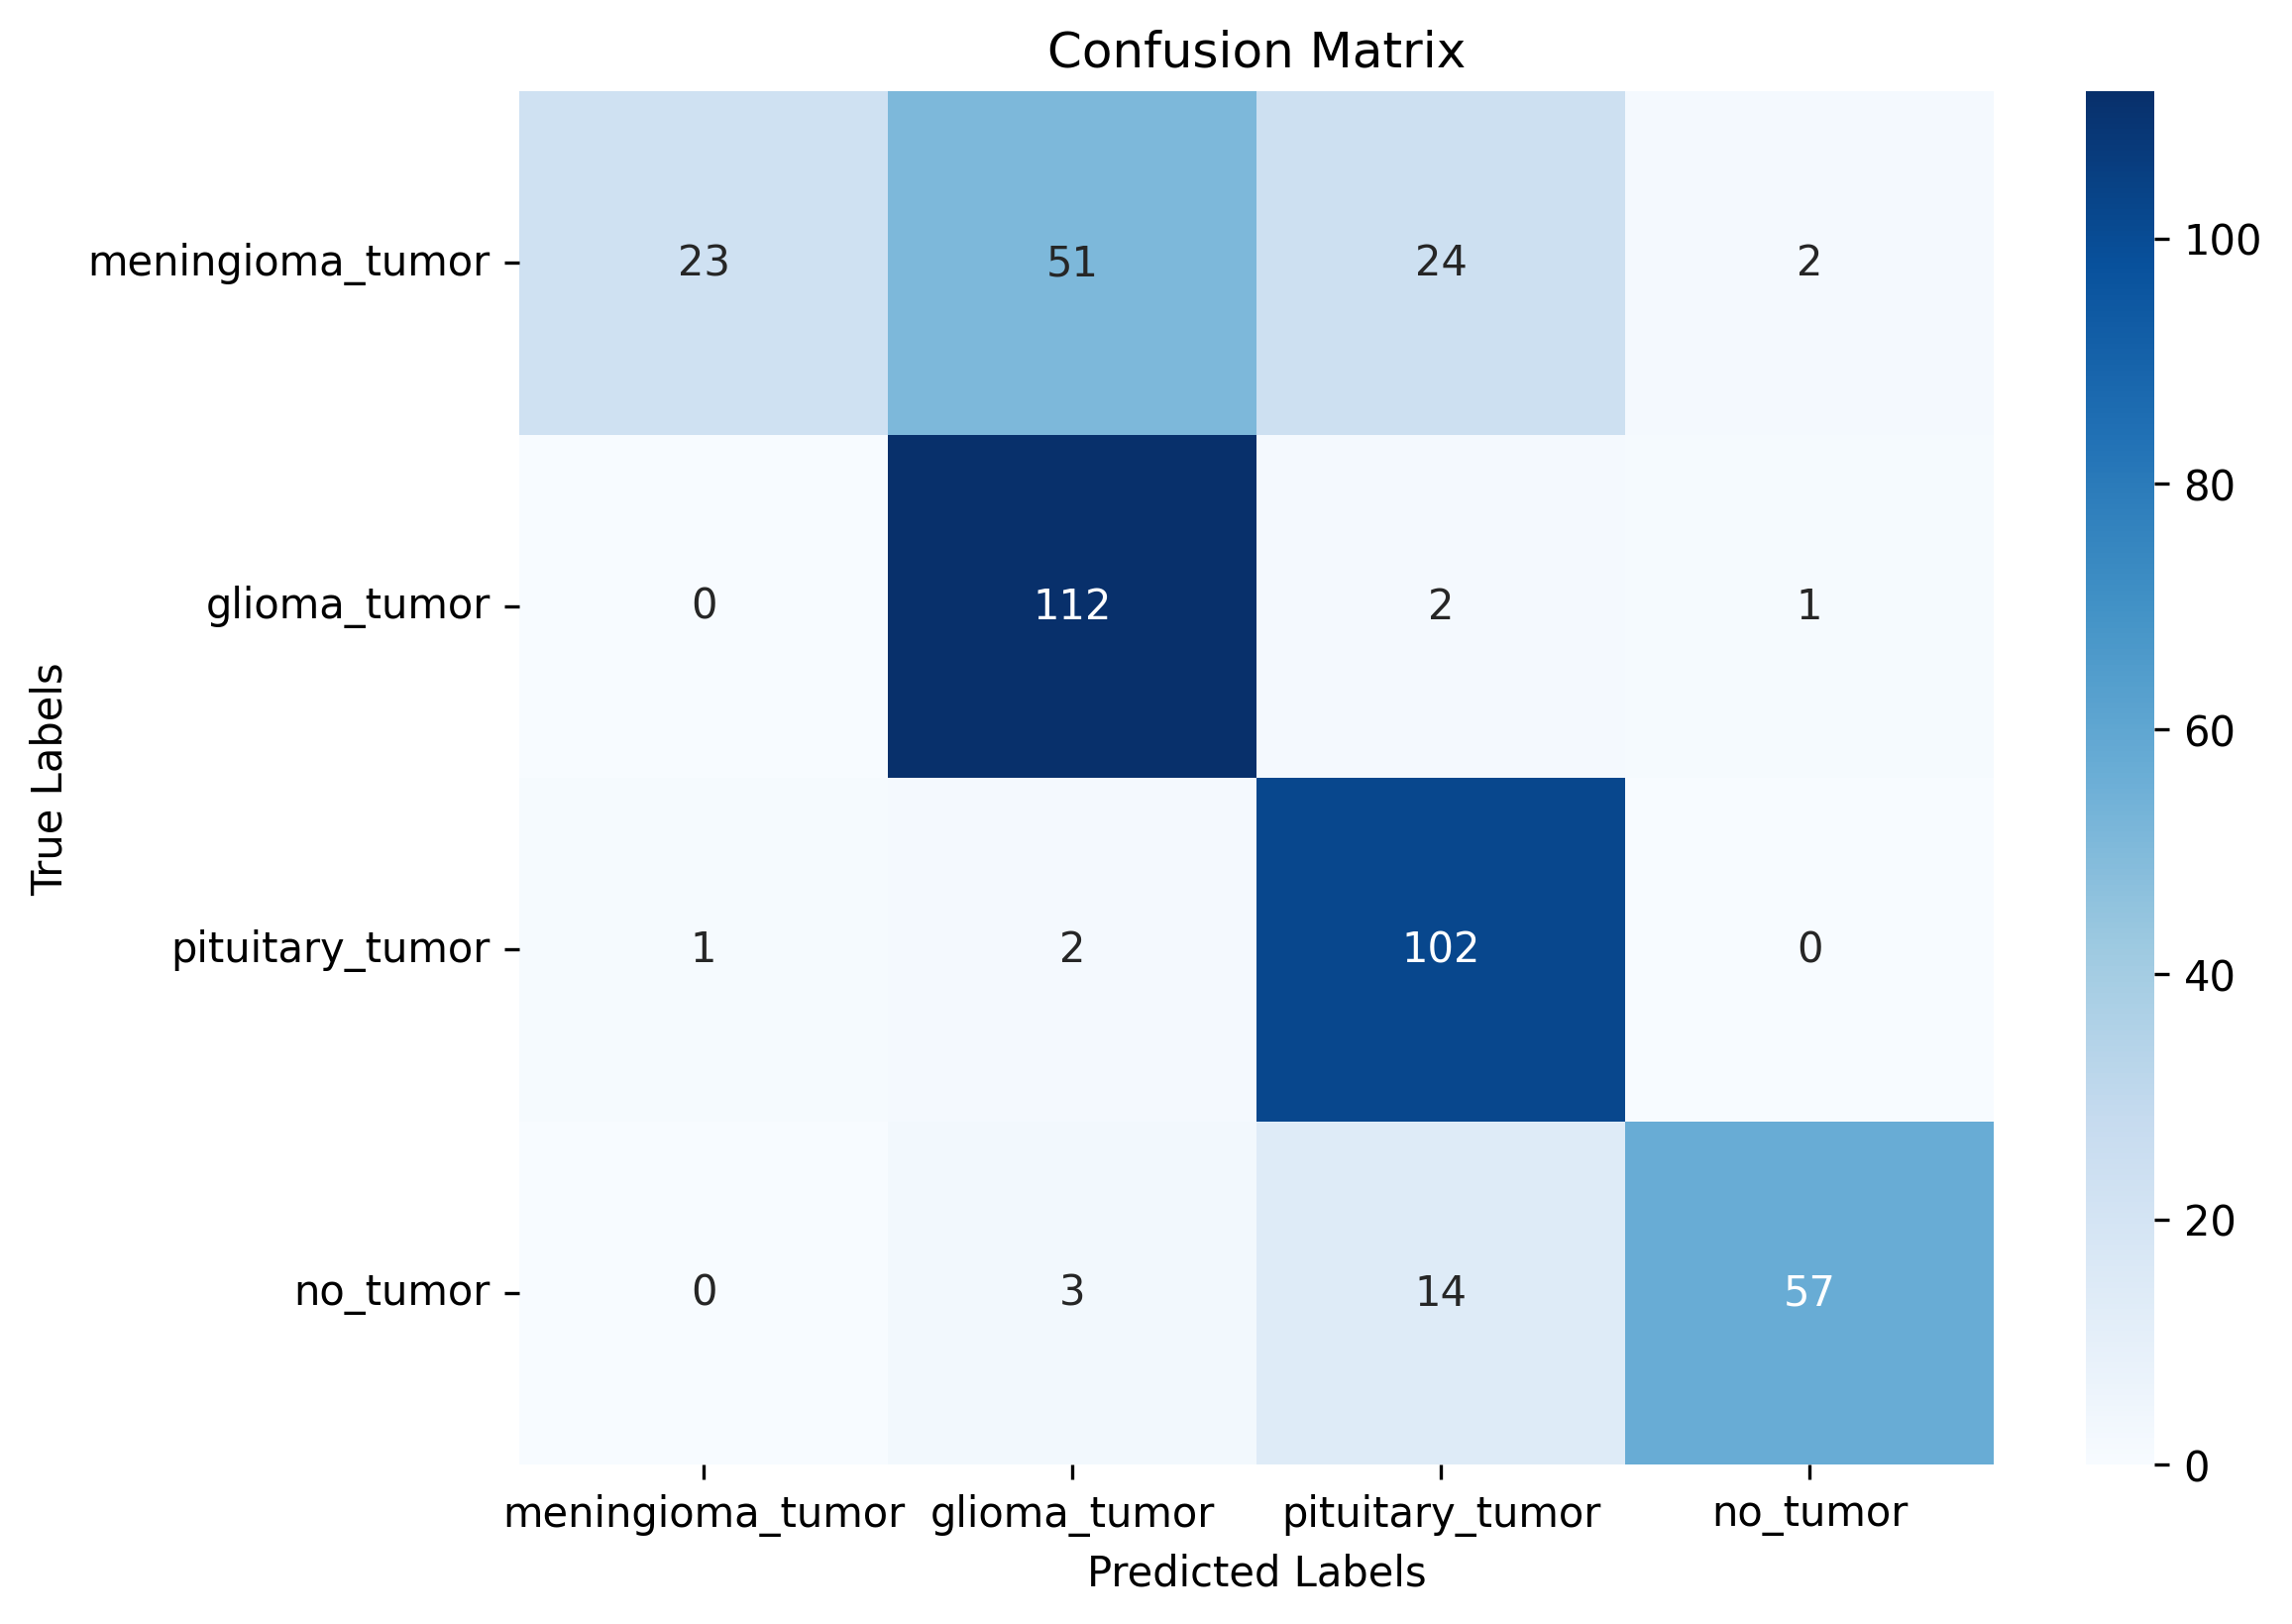

In [27]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have the 'val_ds' data set and 'model' loaded

# Create lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate over 'val_ds' and make predictions
for images, labels in val_ds:
    true_labels.extend(labels)  # Use one-hot encoded labels directly
    predicted_labels.extend(np.argmax(model1.predict(images), axis=1))

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Generate the classification report
class_names = ['meningioma_tumor', 'glioma_tumor', 'pituitary_tumor', 'no_tumor']  # Update with your class names
print(classification_report(true_labels, predicted_labels, target_names=class_names))

# Generate the confusion matrix
confusion = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


### 2. VGG16

In [28]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D

with tpu_strategy.scope():
    base_model2 = VGG16(
                        input_shape=(224, 224, 3),
                        weights='imagenet',
                        include_top=False)
    # Freeze the first 10 layers
    for layer in base_model2.layers:
        layer.trainable = False
    x = base_model2.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.4)(x)
    predictions2 = Dense(4, activation='softmax')(x)
    model2 = Model(inputs=base_model2.inputs, outputs=predictions2)
    model2.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])
    model2.summary()
    

58889256/58889256 [==============================] - 0s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [29]:
# model2.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

In [30]:
history2=model2.fit(
  train_ds,
  validation_data=test_ds,
  epochs=100)

model2.save('model2.h5')

Epoch 1/100


2023-08-06 21:00:28.479092: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-06 21:00:28.603344: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


18/18 [==============================] - ETA: 0s - loss: 2.4079 - accuracy: 0.5388

2023-08-06 21:00:44.566050: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-06 21:00:44.676598: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


18/18 [==============================] - 31s 1s/step - loss: 2.4079 - accuracy: 0.5388 - val_loss: 0.5575 - val_accuracy: 0.8136
Epoch 2/100
18/18 [==============================] - 2s 117ms/step - loss: 0.8676 - accuracy: 0.7609 - val_loss: 0.4217 - val_accuracy: 0.8519
Epoch 3/100
18/18 [==============================] - 2s 116ms/step - loss: 0.4975 - accuracy: 0.8253 - val_loss: 0.3406 - val_accuracy: 0.8746
Epoch 4/100
18/18 [==============================] - 2s 113ms/step - loss: 0.3987 - accuracy: 0.8593 - val_loss: 0.3186 - val_accuracy: 0.8746
Epoch 5/100
18/18 [==============================] - 2s 116ms/step - loss: 0.3059 - accuracy: 0.8889 - val_loss: 0.2943 - val_accuracy: 0.8972
Epoch 6/100
18/18 [==============================] - 2s 109ms/step - loss: 0.2982 - accuracy: 0.8911 - val_loss: 0.3377 - val_accuracy: 0.8676
Epoch 7/100
18/18 [==============================] - 2s 117ms/step - loss: 0.2521 - accuracy: 0.9051 - val_loss: 0.2800 - val_accuracy: 0.8955
Epoch 8/100
1

In [31]:
vgg16_evaluation = model2.evaluate(val_ds)
vgg16_evaluation[1]*100

4/4 [==============================] - 7s 2s/step - loss: 3.4033 - accuracy: 0.7665


76.64974331855774

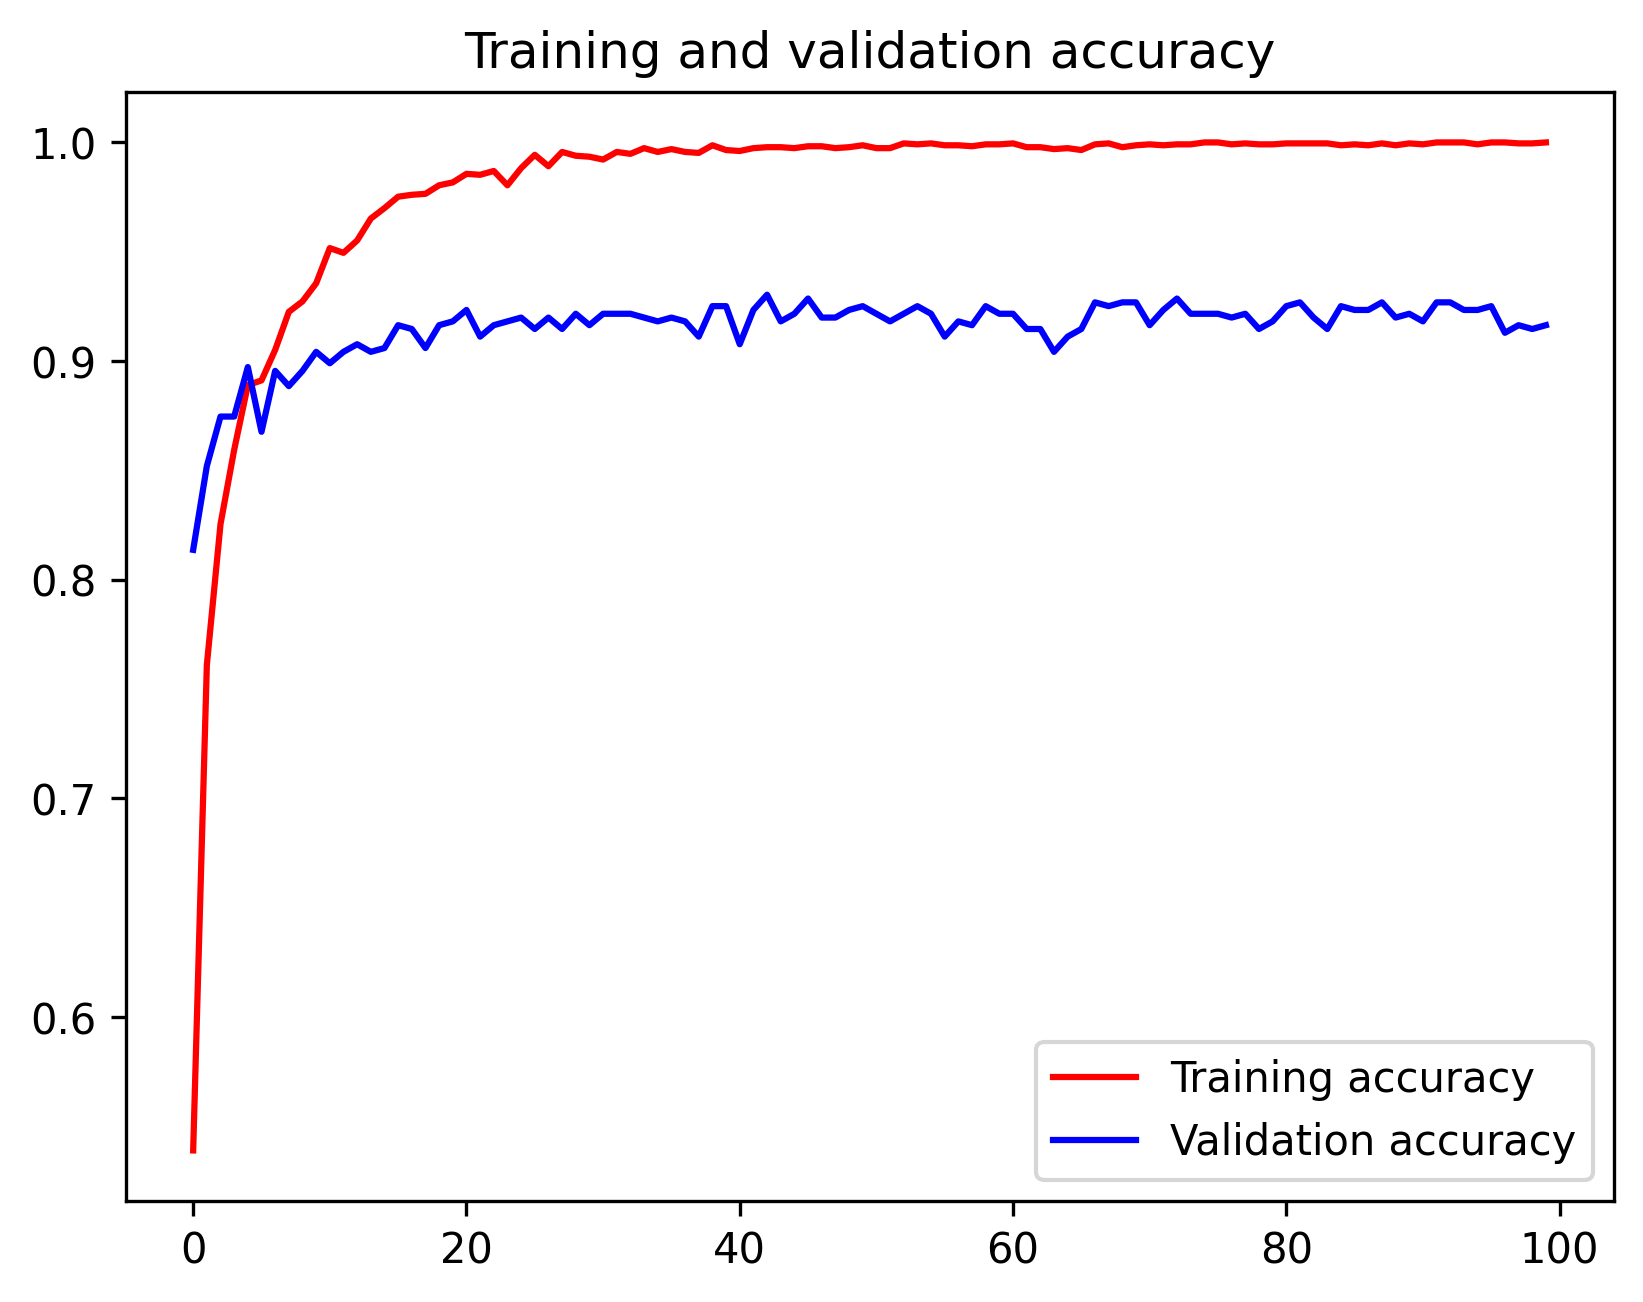

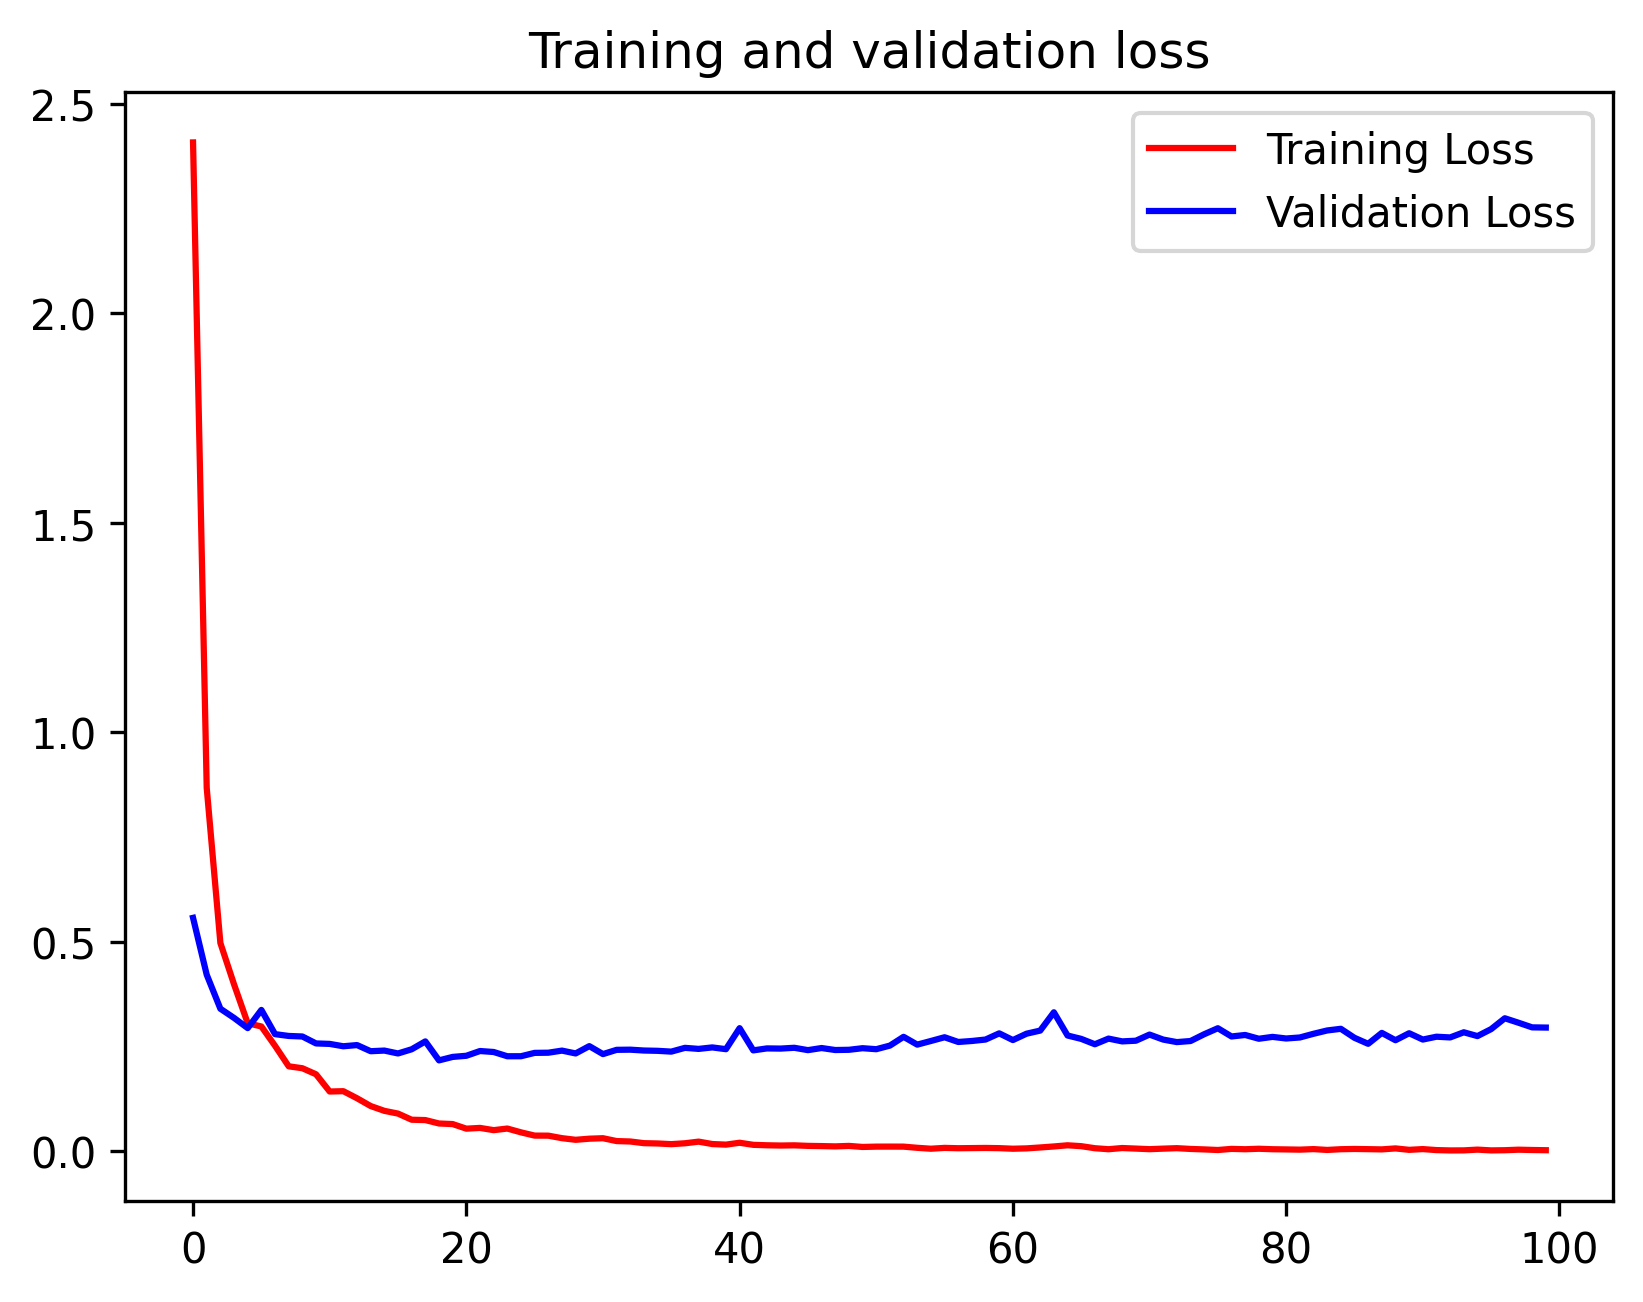

In [32]:
import matplotlib.pyplot as plt
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

2023-08-06 21:05:18.858215: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-06 21:05:18.880458: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


4/4 [==============================] - 0s 11ms/step


2023-08-06 21:05:27.571735: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-06 21:05:27.647667: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


1/1 [==============================] - 7s 7s/step
                  precision    recall  f1-score   support

meningioma_tumor       0.90      0.28      0.43       100
    glioma_tumor       0.72      0.93      0.81       115
 pituitary_tumor       0.71      0.94      0.81       105
        no_tumor       0.91      0.92      0.91        74

        accuracy                           0.77       394
       macro avg       0.81      0.77      0.74       394
    weighted avg       0.80      0.77      0.73       394



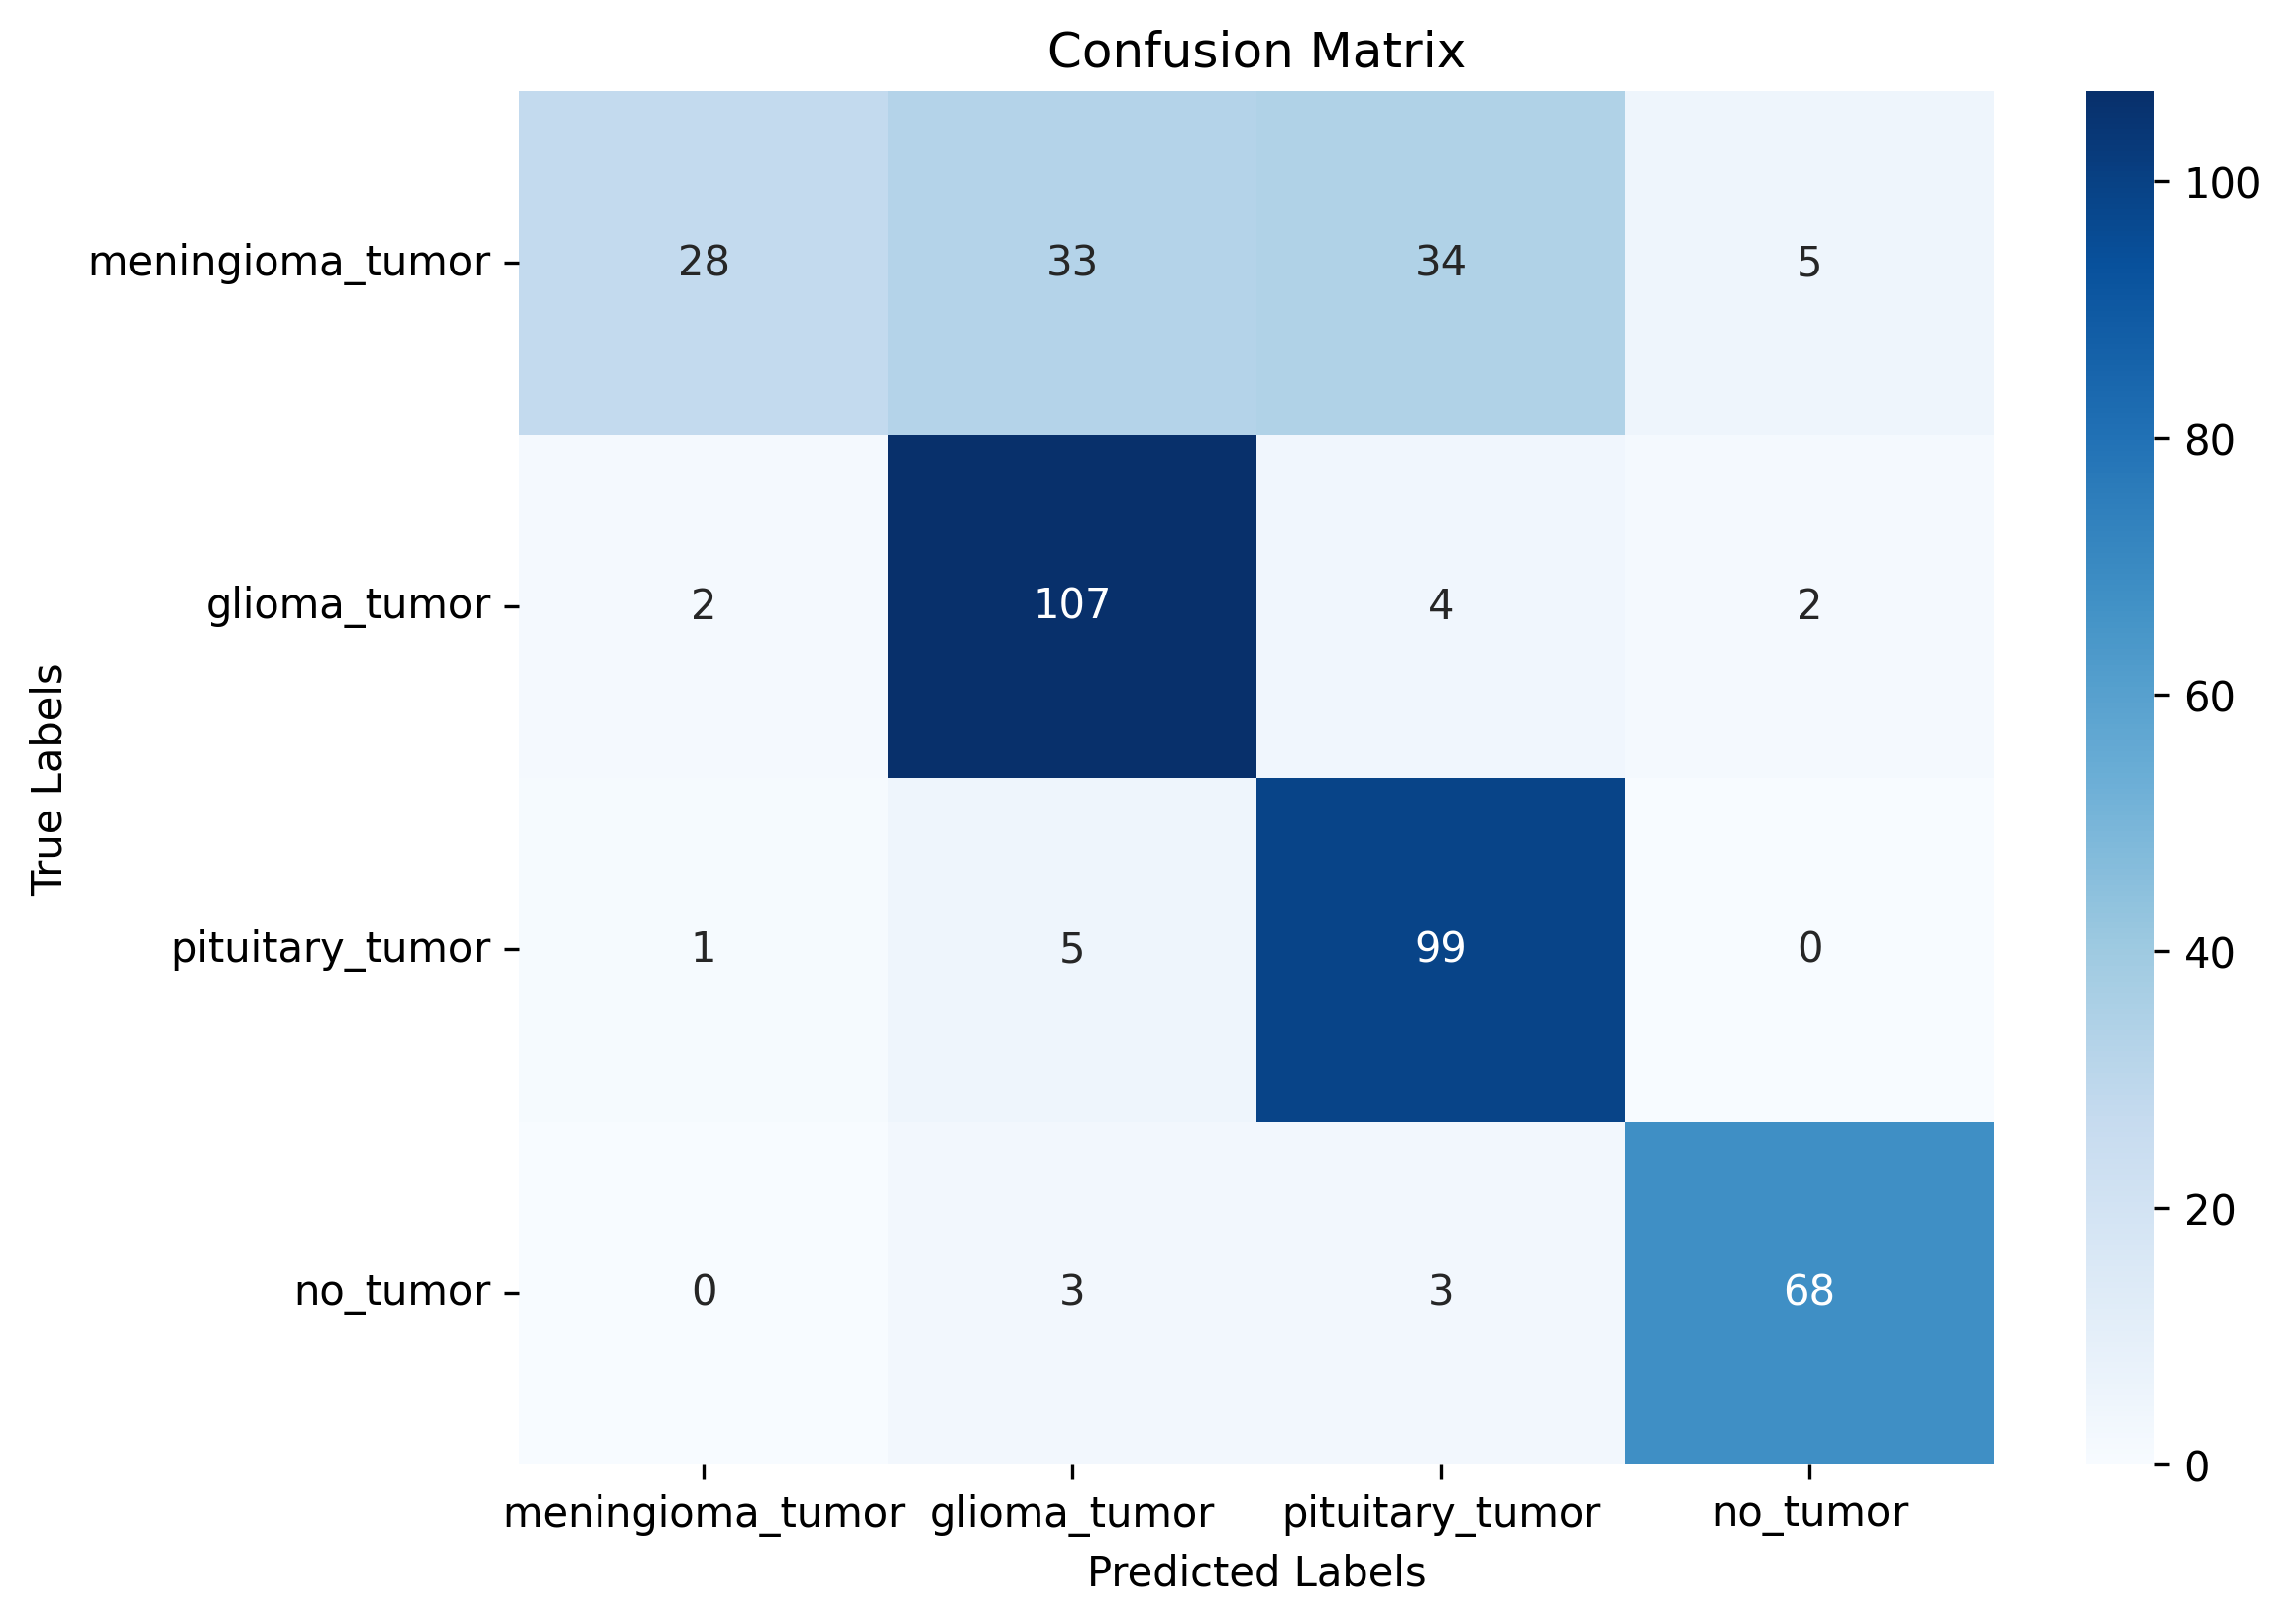

In [33]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have the 'val_ds' data set and 'model' loaded

# Create lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate over 'val_ds' and make predictions
for images, labels in val_ds:
    true_labels.extend(labels)  # Use one-hot encoded labels directly
    predicted_labels.extend(np.argmax(model2.predict(images), axis=1))

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Generate the classification report
class_names = ['meningioma_tumor', 'glioma_tumor', 'pituitary_tumor', 'no_tumor']  # Update with your class names
print(classification_report(true_labels, predicted_labels, target_names=class_names))

# Generate the confusion matrix
confusion = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


### 3. VGG19

In [34]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D

with tpu_strategy.scope():

    base_model3 = VGG19(
                        input_shape=(224, 224, 3),
                        weights='imagenet',
                        include_top=False)
    # Freeze the first 10 layers
    for layer in base_model3.layers[:10]:
        layer.trainable = False
    x = base_model3.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.4)(x)
    predictions3 = Dense(4, activation='softmax')(x)
    model3 = Model(inputs=base_model3.inputs, outputs=predictions3)
    model3.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])
    model3.summary()

80134624/80134624 [==============================] - 1s 0us/step
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [35]:
# model3.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

In [36]:
history3=model3.fit(
  train_ds,
  validation_data=test_ds,
  epochs=100)

model3.save('model3.h5')

Epoch 1/100


2023-08-06 21:05:41.140772: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-06 21:05:41.297363: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


18/18 [==============================] - ETA: 0s - loss: 5.2211 - accuracy: 0.2831

2023-08-06 21:06:15.651662: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-06 21:06:15.760775: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


18/18 [==============================] - 51s 2s/step - loss: 5.2211 - accuracy: 0.2831 - val_loss: 1.3824 - val_accuracy: 0.2892
Epoch 2/100
18/18 [==============================] - 2s 128ms/step - loss: 1.5643 - accuracy: 0.2679 - val_loss: 1.3723 - val_accuracy: 0.2927
Epoch 3/100
18/18 [==============================] - 2s 129ms/step - loss: 1.3642 - accuracy: 0.3193 - val_loss: 1.3639 - val_accuracy: 0.3920
Epoch 4/100
18/18 [==============================] - 3s 180ms/step - loss: 1.3562 - accuracy: 0.3171 - val_loss: 1.3399 - val_accuracy: 0.2892
Epoch 5/100
18/18 [==============================] - 2s 135ms/step - loss: 1.3226 - accuracy: 0.3685 - val_loss: 1.2889 - val_accuracy: 0.3850
Epoch 6/100
18/18 [==============================] - 2s 132ms/step - loss: 1.2718 - accuracy: 0.4608 - val_loss: 1.2758 - val_accuracy: 0.4599
Epoch 7/100
18/18 [==============================] - 2s 133ms/step - loss: 1.2563 - accuracy: 0.4377 - val_loss: 1.2454 - val_accuracy: 0.4652
Epoch 8/100
1

In [37]:
vgg19_evaluation = model3.evaluate(val_ds)
vgg19_evaluation[1]*100

4/4 [==============================] - 7s 2s/step - loss: 6.5776 - accuracy: 0.6777


67.76649951934814

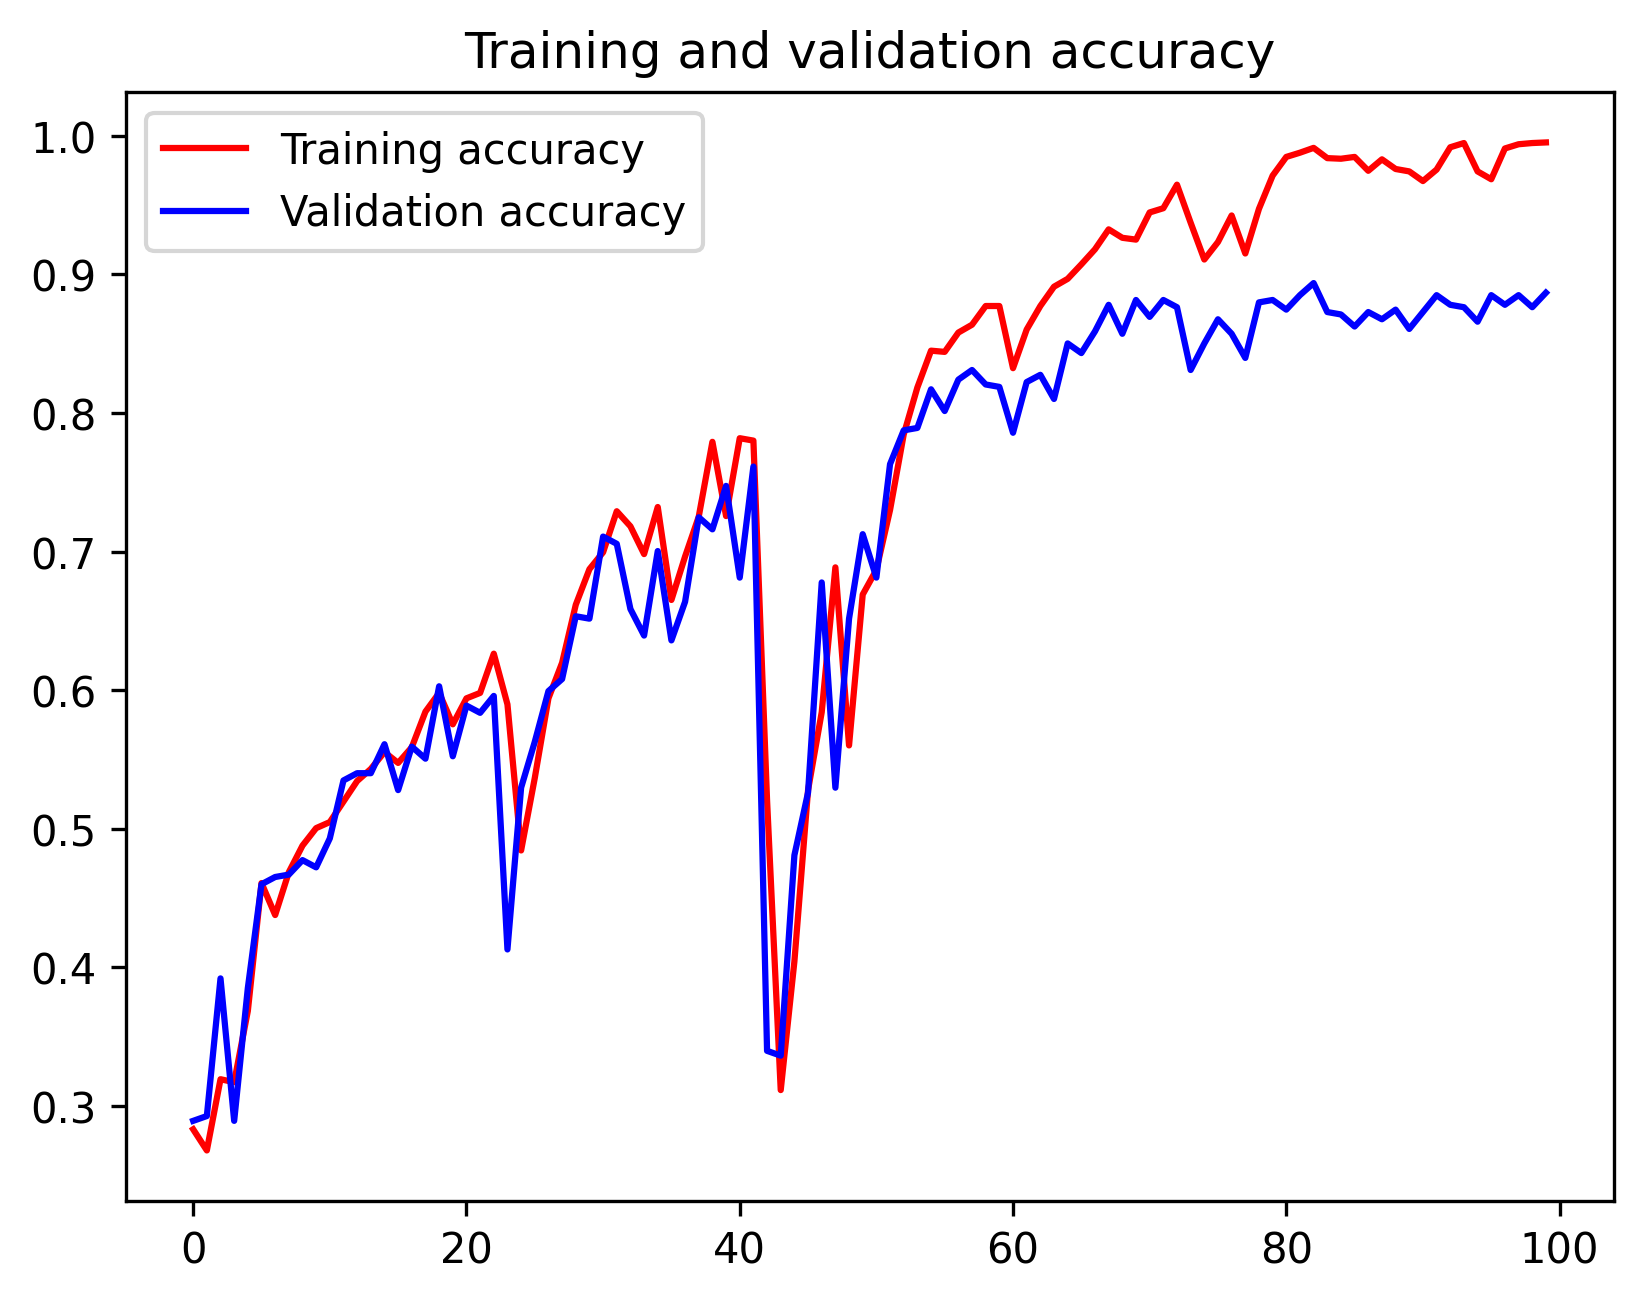

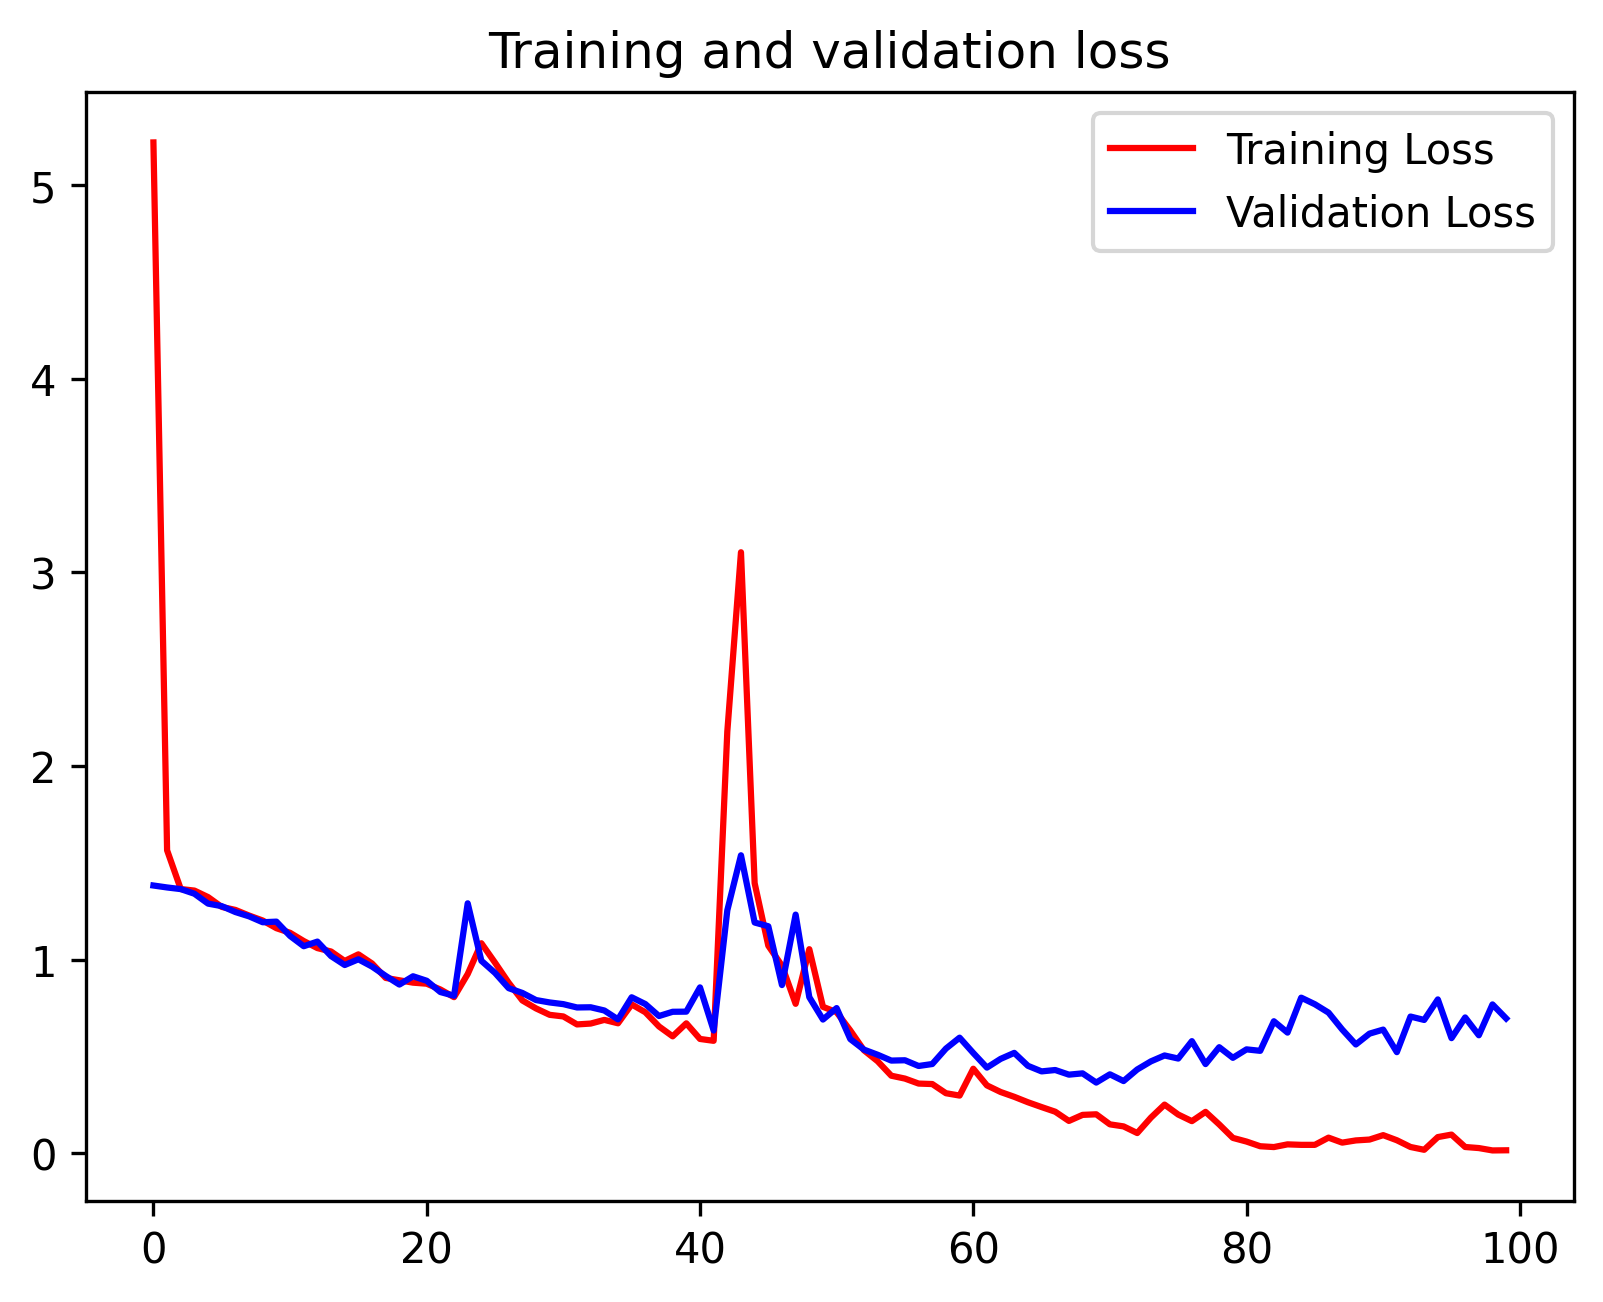

In [38]:
import matplotlib.pyplot as plt
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']
loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

2023-08-06 21:11:24.383355: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-06 21:11:24.405962: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


4/4 [==============================] - 0s 12ms/step


2023-08-06 21:11:33.254800: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-06 21:11:33.333886: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


1/1 [==============================] - 7s 7s/step
                  precision    recall  f1-score   support

meningioma_tumor       0.81      0.22      0.35       100
    glioma_tumor       0.59      0.91      0.71       115
 pituitary_tumor       0.72      0.94      0.82       105
        no_tumor       0.80      0.55      0.66        74

        accuracy                           0.68       394
       macro avg       0.73      0.66      0.63       394
    weighted avg       0.72      0.68      0.64       394



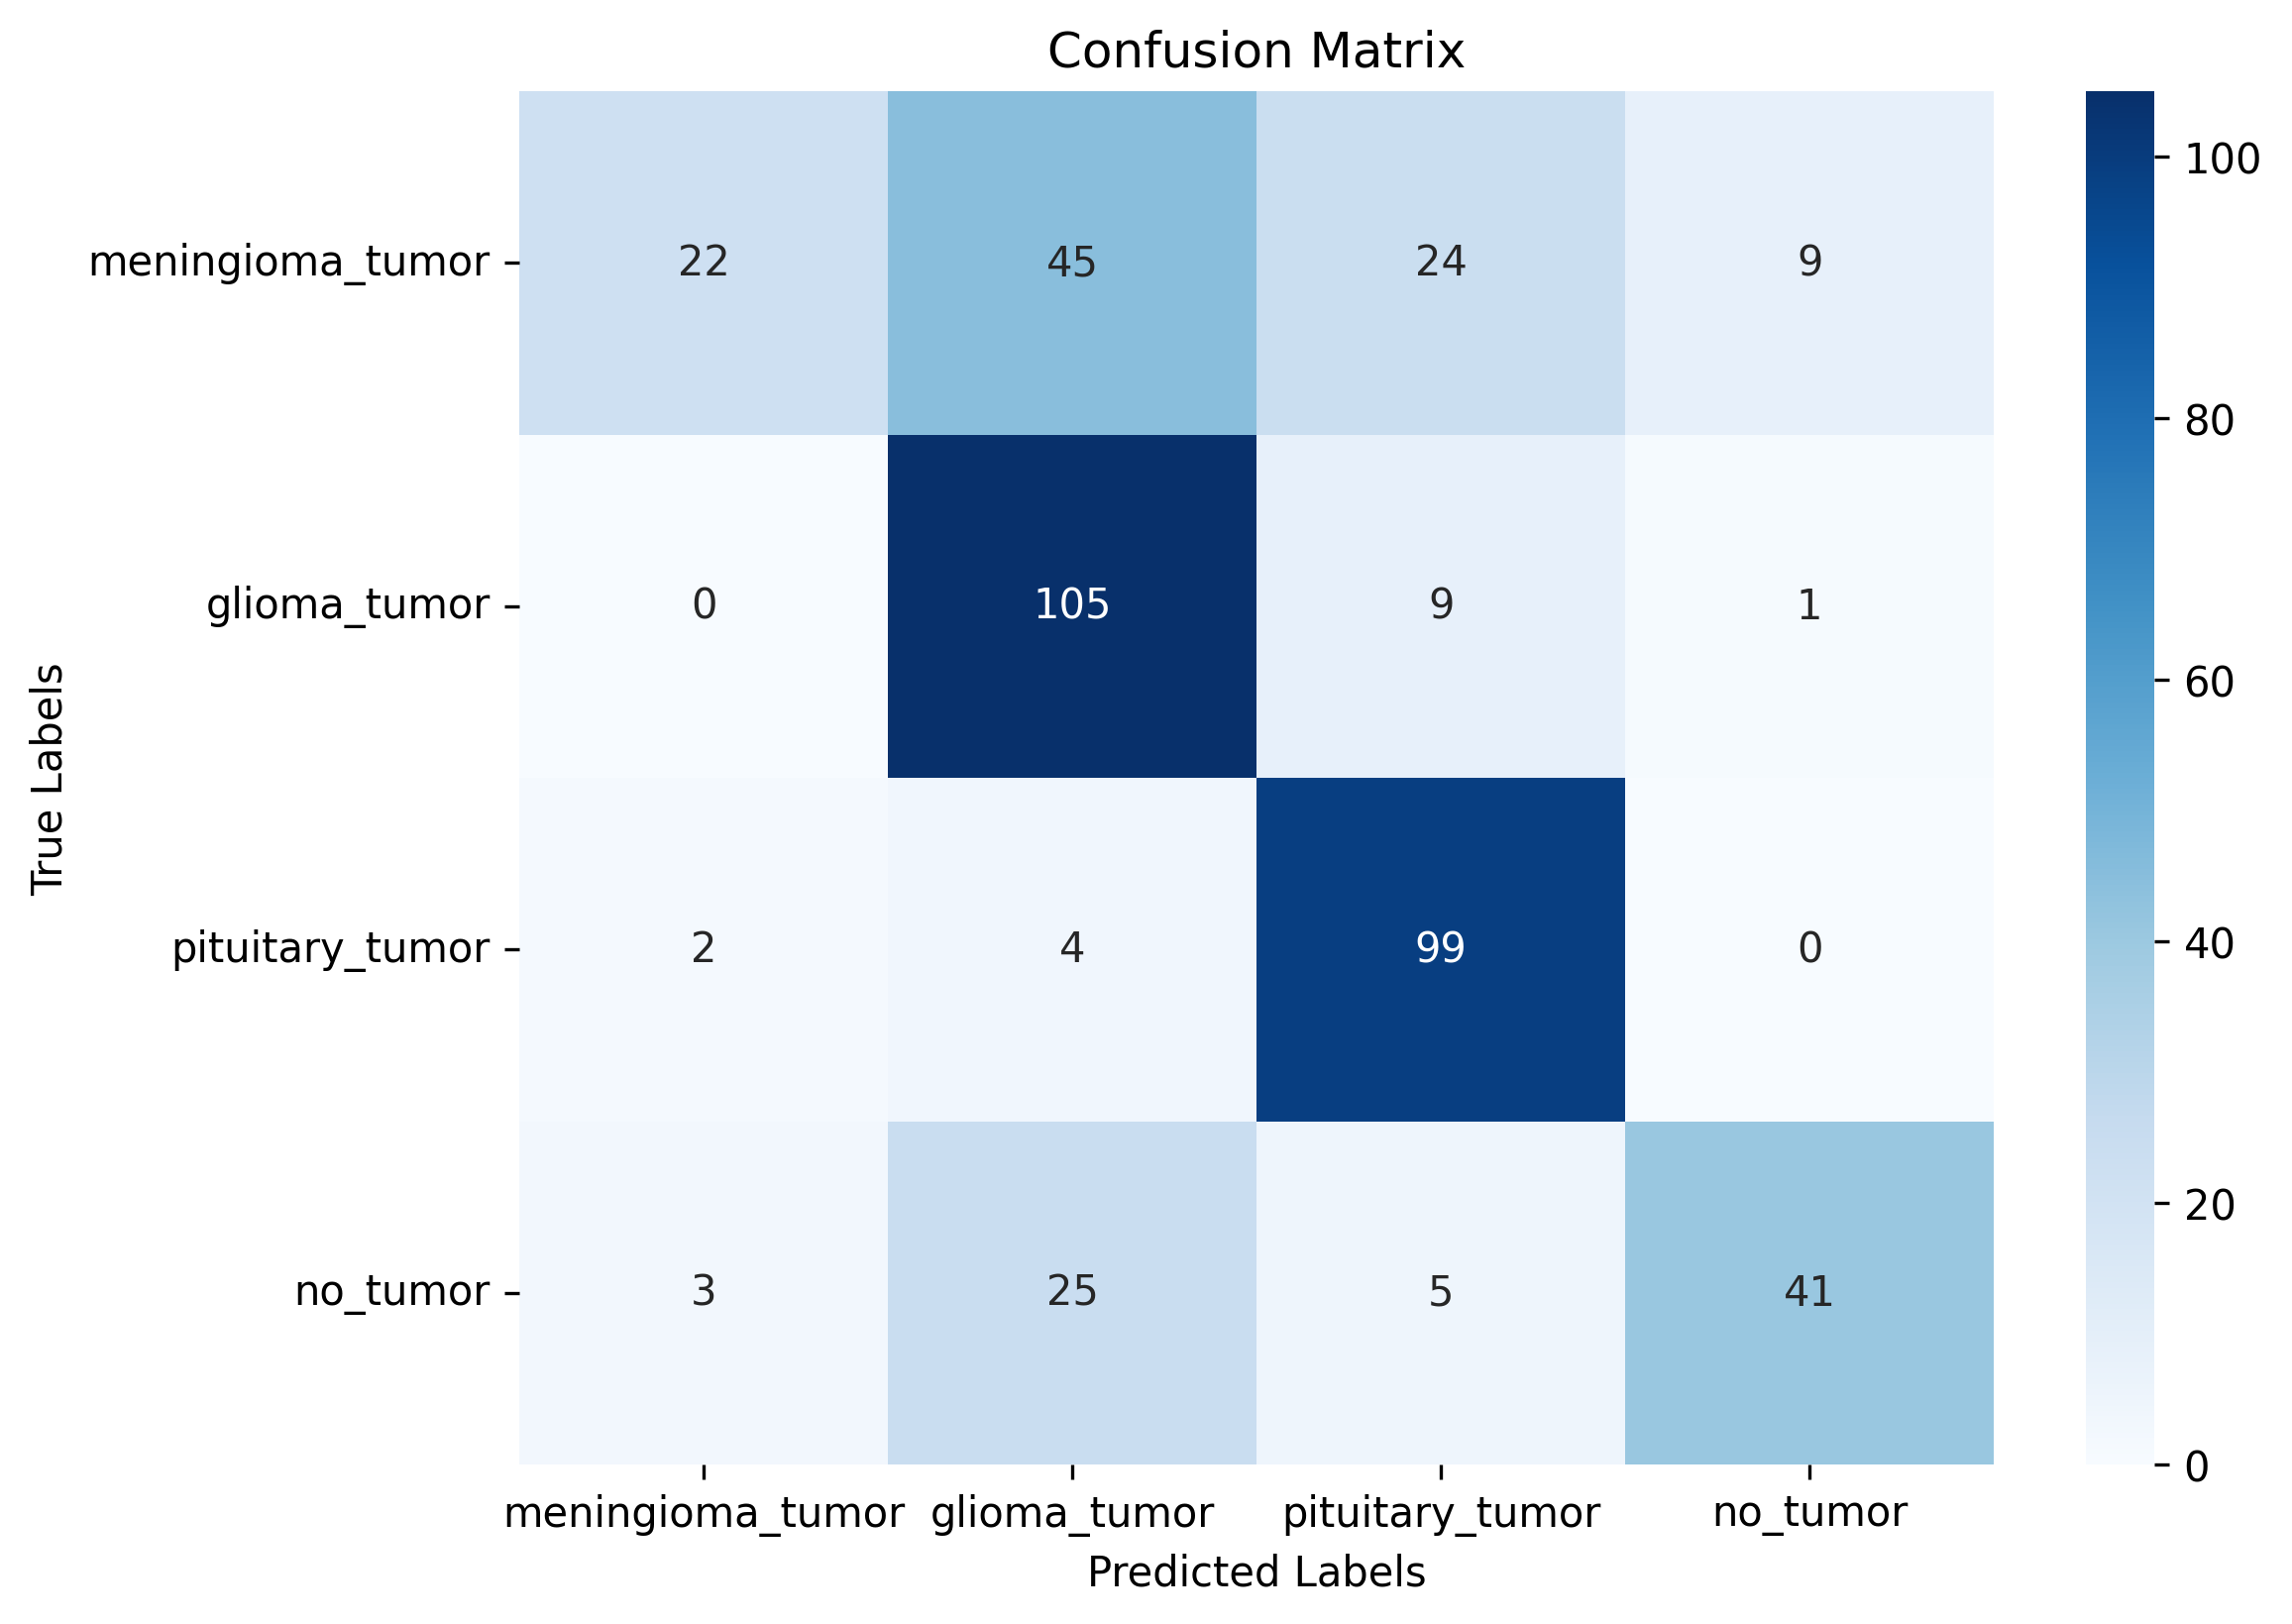

In [39]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have the 'val_ds' data set and 'model' loaded

# Create lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate over 'val_ds' and make predictions
for images, labels in val_ds:
    true_labels.extend(labels)  # Use one-hot encoded labels directly
    predicted_labels.extend(np.argmax(model3.predict(images), axis=1))

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Generate the classification report
class_names = ['meningioma_tumor', 'glioma_tumor', 'pituitary_tumor', 'no_tumor']  # Update with your class names
print(classification_report(true_labels, predicted_labels, target_names=class_names))

# Generate the confusion matrix
confusion = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


### 4. RESNET50

In [40]:
from tensorflow.keras.applications import ResNet50

with tpu_strategy.scope():

    base_model4 = ResNet50(
                        input_shape=(224, 224, 3),
                        weights='imagenet',
                        include_top=False)
    # Freeze the first 10 layers
    for layer in base_model4.layers[:10]:
        layer.trainable = False
    x = base_model4.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.4)(x)
    predictions4 = Dense(4, activation='softmax')(x)
    model4 = Model(inputs=base_model4.inputs, outputs=predictions4)
    model4.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])
    model4.summary()

94765736/94765736 [==============================] - 0s 0us/step
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                           

In [41]:
# model4.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

In [42]:
history4=model4.fit(
  train_ds,
  validation_data=test_ds,
  epochs=100)

model4.save('model4.h5')

Epoch 1/100


2023-08-06 21:12:26.014866: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-06 21:12:26.887299: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


18/18 [==============================] - ETA: 0s - loss: 0.9521 - accuracy: 0.7130

2023-08-06 21:13:36.451209: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-06 21:13:36.674778: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


18/18 [==============================] - 112s 3s/step - loss: 0.9521 - accuracy: 0.7130 - val_loss: 841.7683 - val_accuracy: 0.1394
Epoch 2/100
18/18 [==============================] - 3s 152ms/step - loss: 0.2578 - accuracy: 0.9072 - val_loss: 33.9429 - val_accuracy: 0.2125
Epoch 3/100
18/18 [==============================] - 3s 146ms/step - loss: 0.1169 - accuracy: 0.9599 - val_loss: 7.7325 - val_accuracy: 0.4181
Epoch 4/100
18/18 [==============================] - 3s 147ms/step - loss: 0.0659 - accuracy: 0.9774 - val_loss: 13.2958 - val_accuracy: 0.4321
Epoch 5/100
18/18 [==============================] - 3s 146ms/step - loss: 0.0502 - accuracy: 0.9830 - val_loss: 9.2361 - val_accuracy: 0.3990
Epoch 6/100
18/18 [==============================] - 3s 148ms/step - loss: 0.0490 - accuracy: 0.9874 - val_loss: 11.5585 - val_accuracy: 0.4199
Epoch 7/100
18/18 [==============================] - 3s 143ms/step - loss: 0.0609 - accuracy: 0.9791 - val_loss: 3.0721 - val_accuracy: 0.5958
Epoch 8

In [43]:
resnet50_evaluation = model4.evaluate(val_ds)
resnet50_evaluation[1]*100

4/4 [==============================] - 9s 3s/step - loss: 2.9419 - accuracy: 0.7614


76.14213228225708

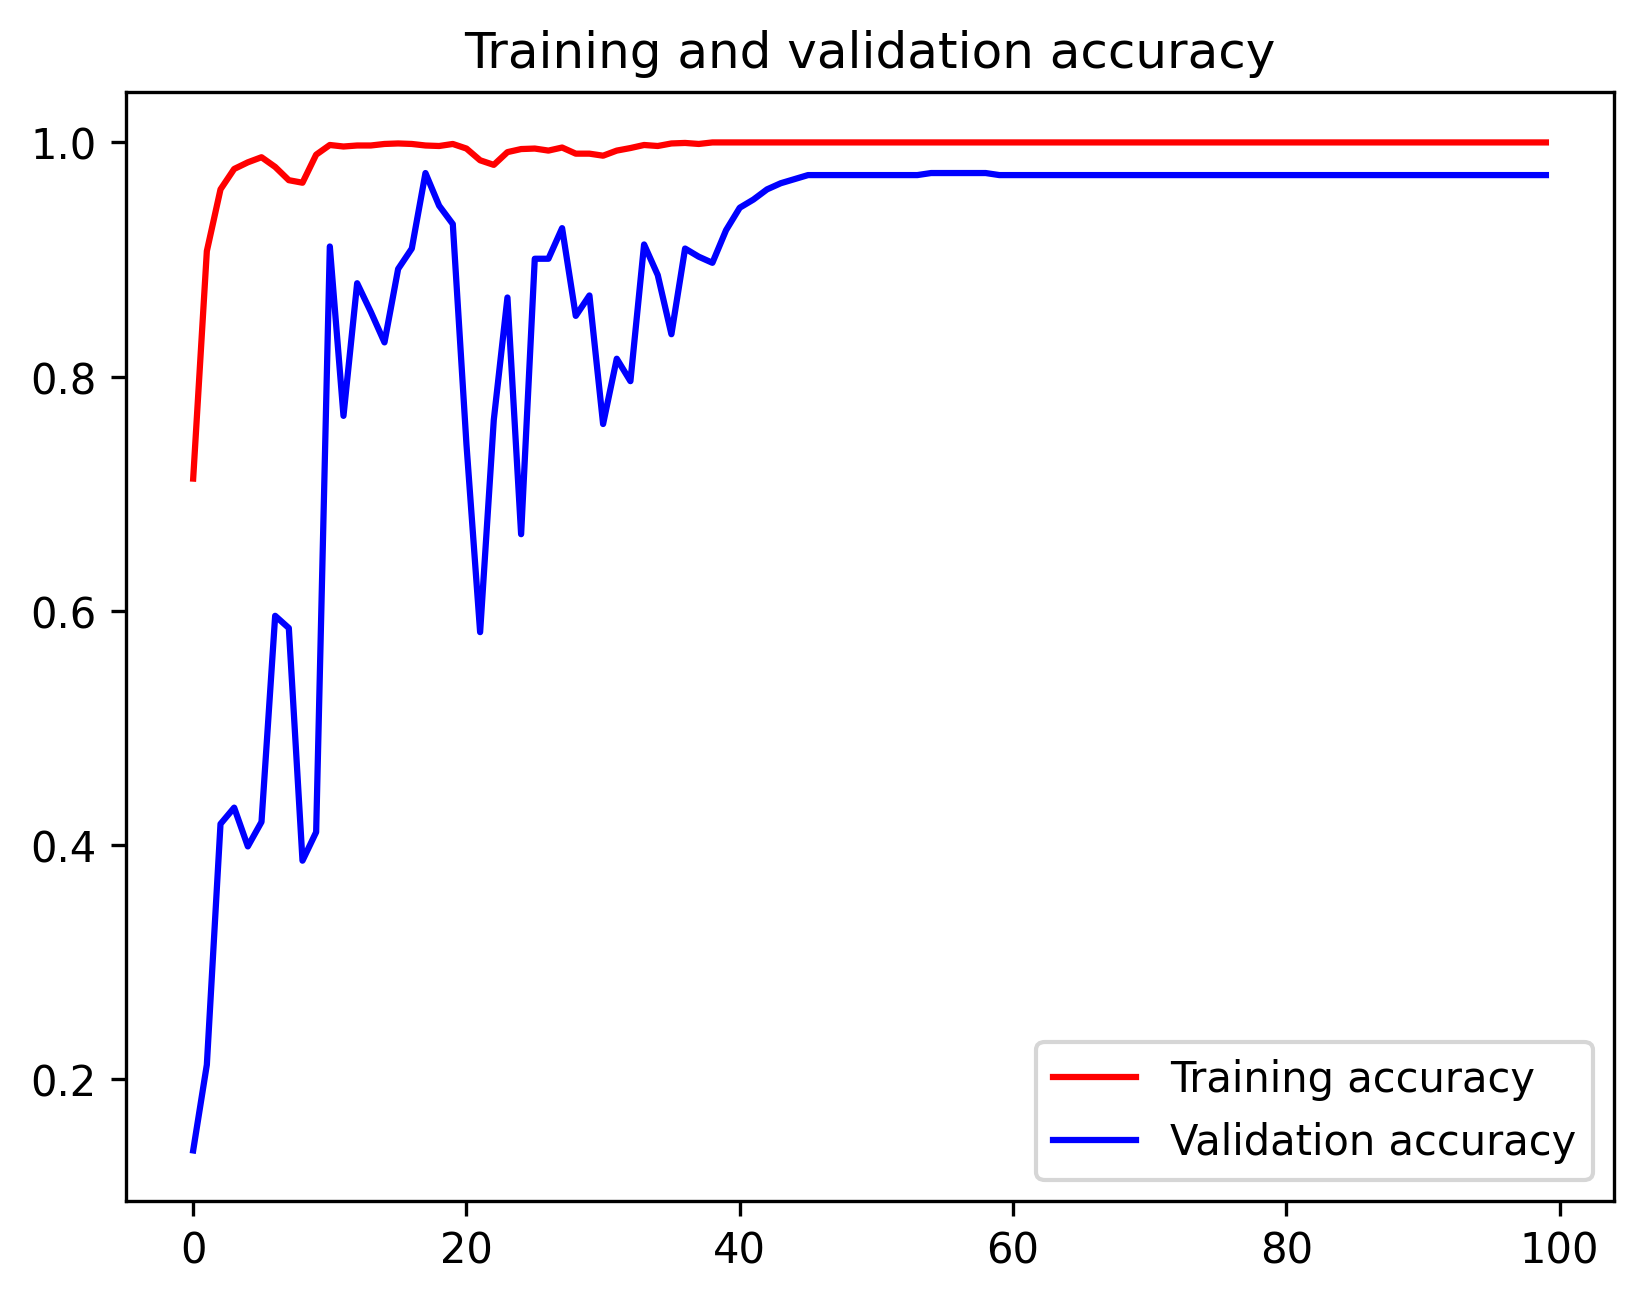

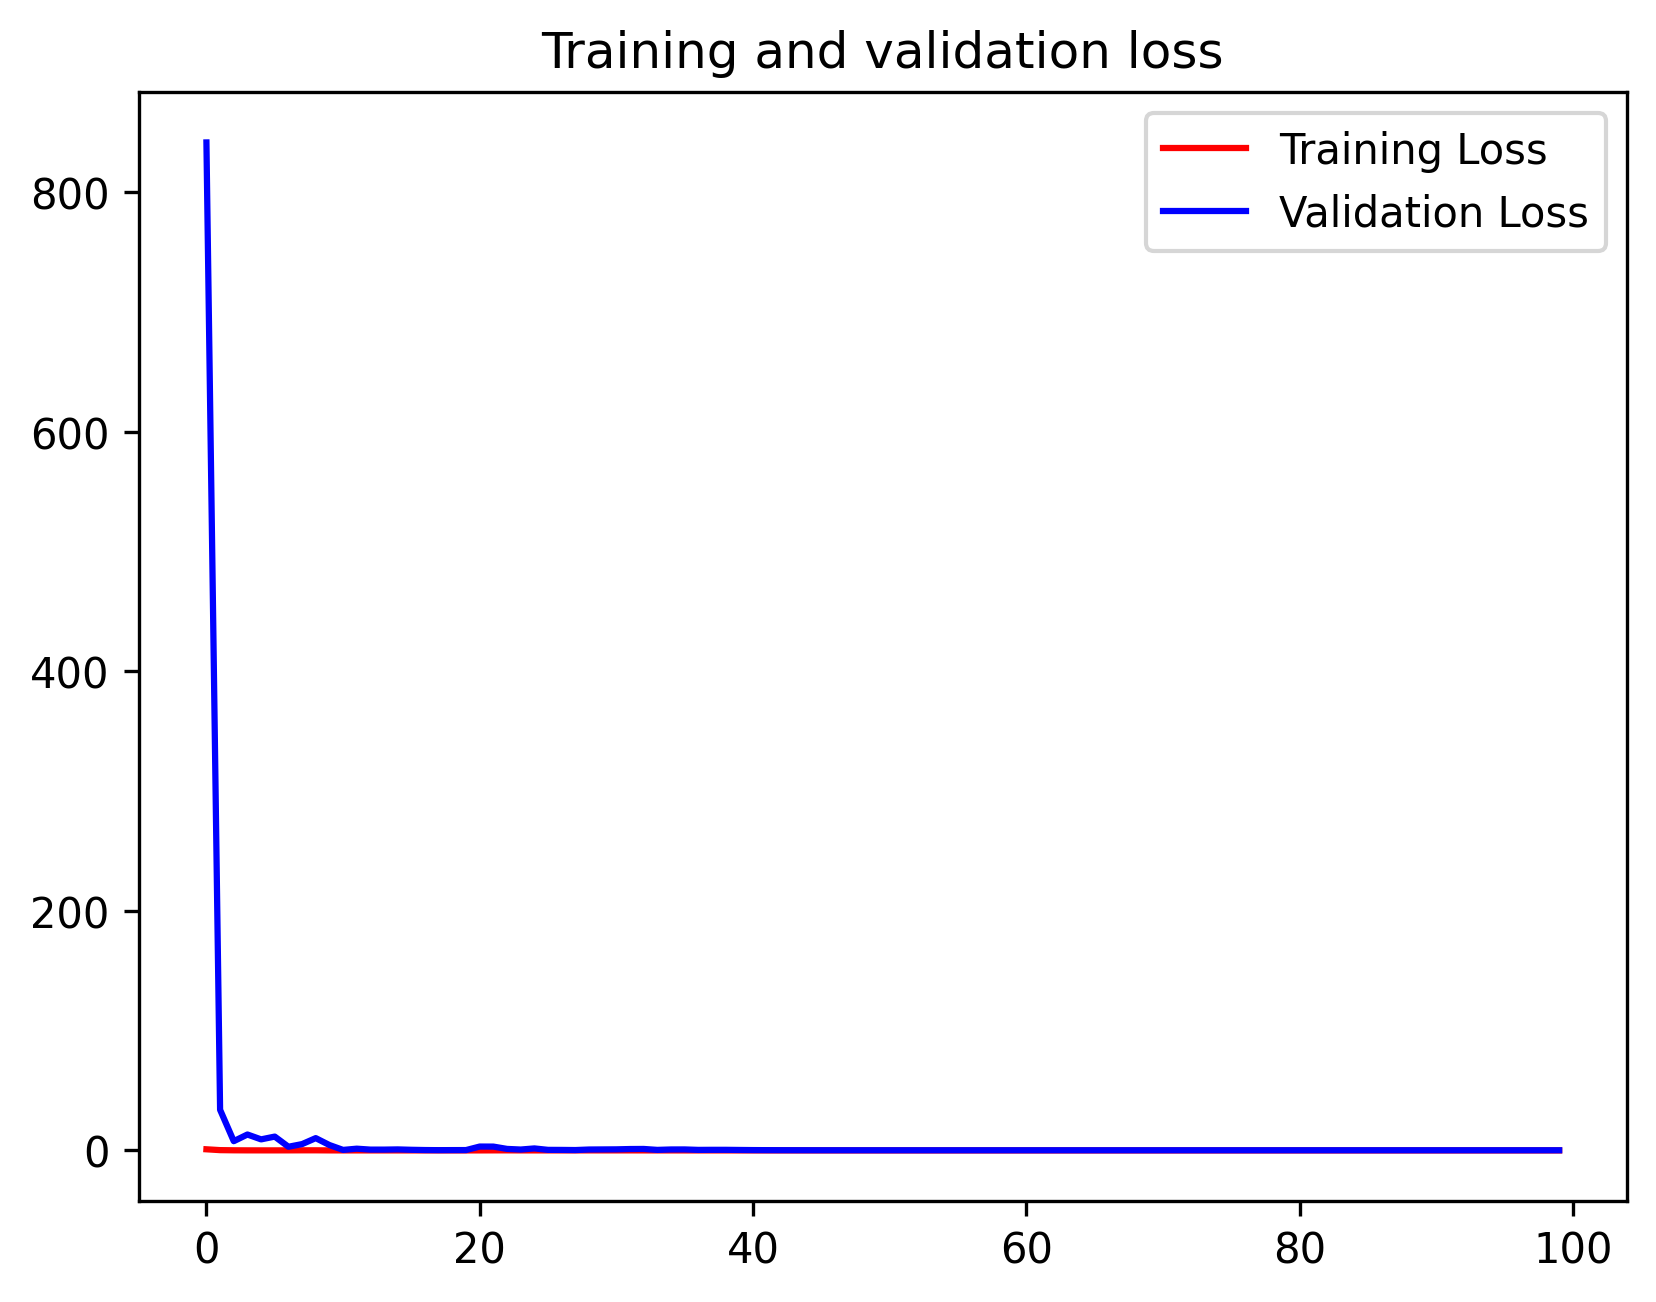

In [44]:
import matplotlib.pyplot as plt
acc = history4.history['accuracy']
val_acc = history4.history['val_accuracy']
loss = history4.history['loss']
val_loss = history4.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

2023-08-06 21:19:20.661844: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-06 21:19:20.853520: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


4/4 [==============================] - 1s 15ms/step


2023-08-06 21:19:32.728522: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-06 21:19:32.930145: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


1/1 [==============================] - 10s 10s/step
                  precision    recall  f1-score   support

meningioma_tumor       1.00      0.25      0.40       100
    glioma_tumor       0.78      0.97      0.86       115
 pituitary_tumor       0.65      0.97      0.78       105
        no_tumor       0.93      0.85      0.89        74

        accuracy                           0.77       394
       macro avg       0.84      0.76      0.73       394
    weighted avg       0.83      0.77      0.73       394



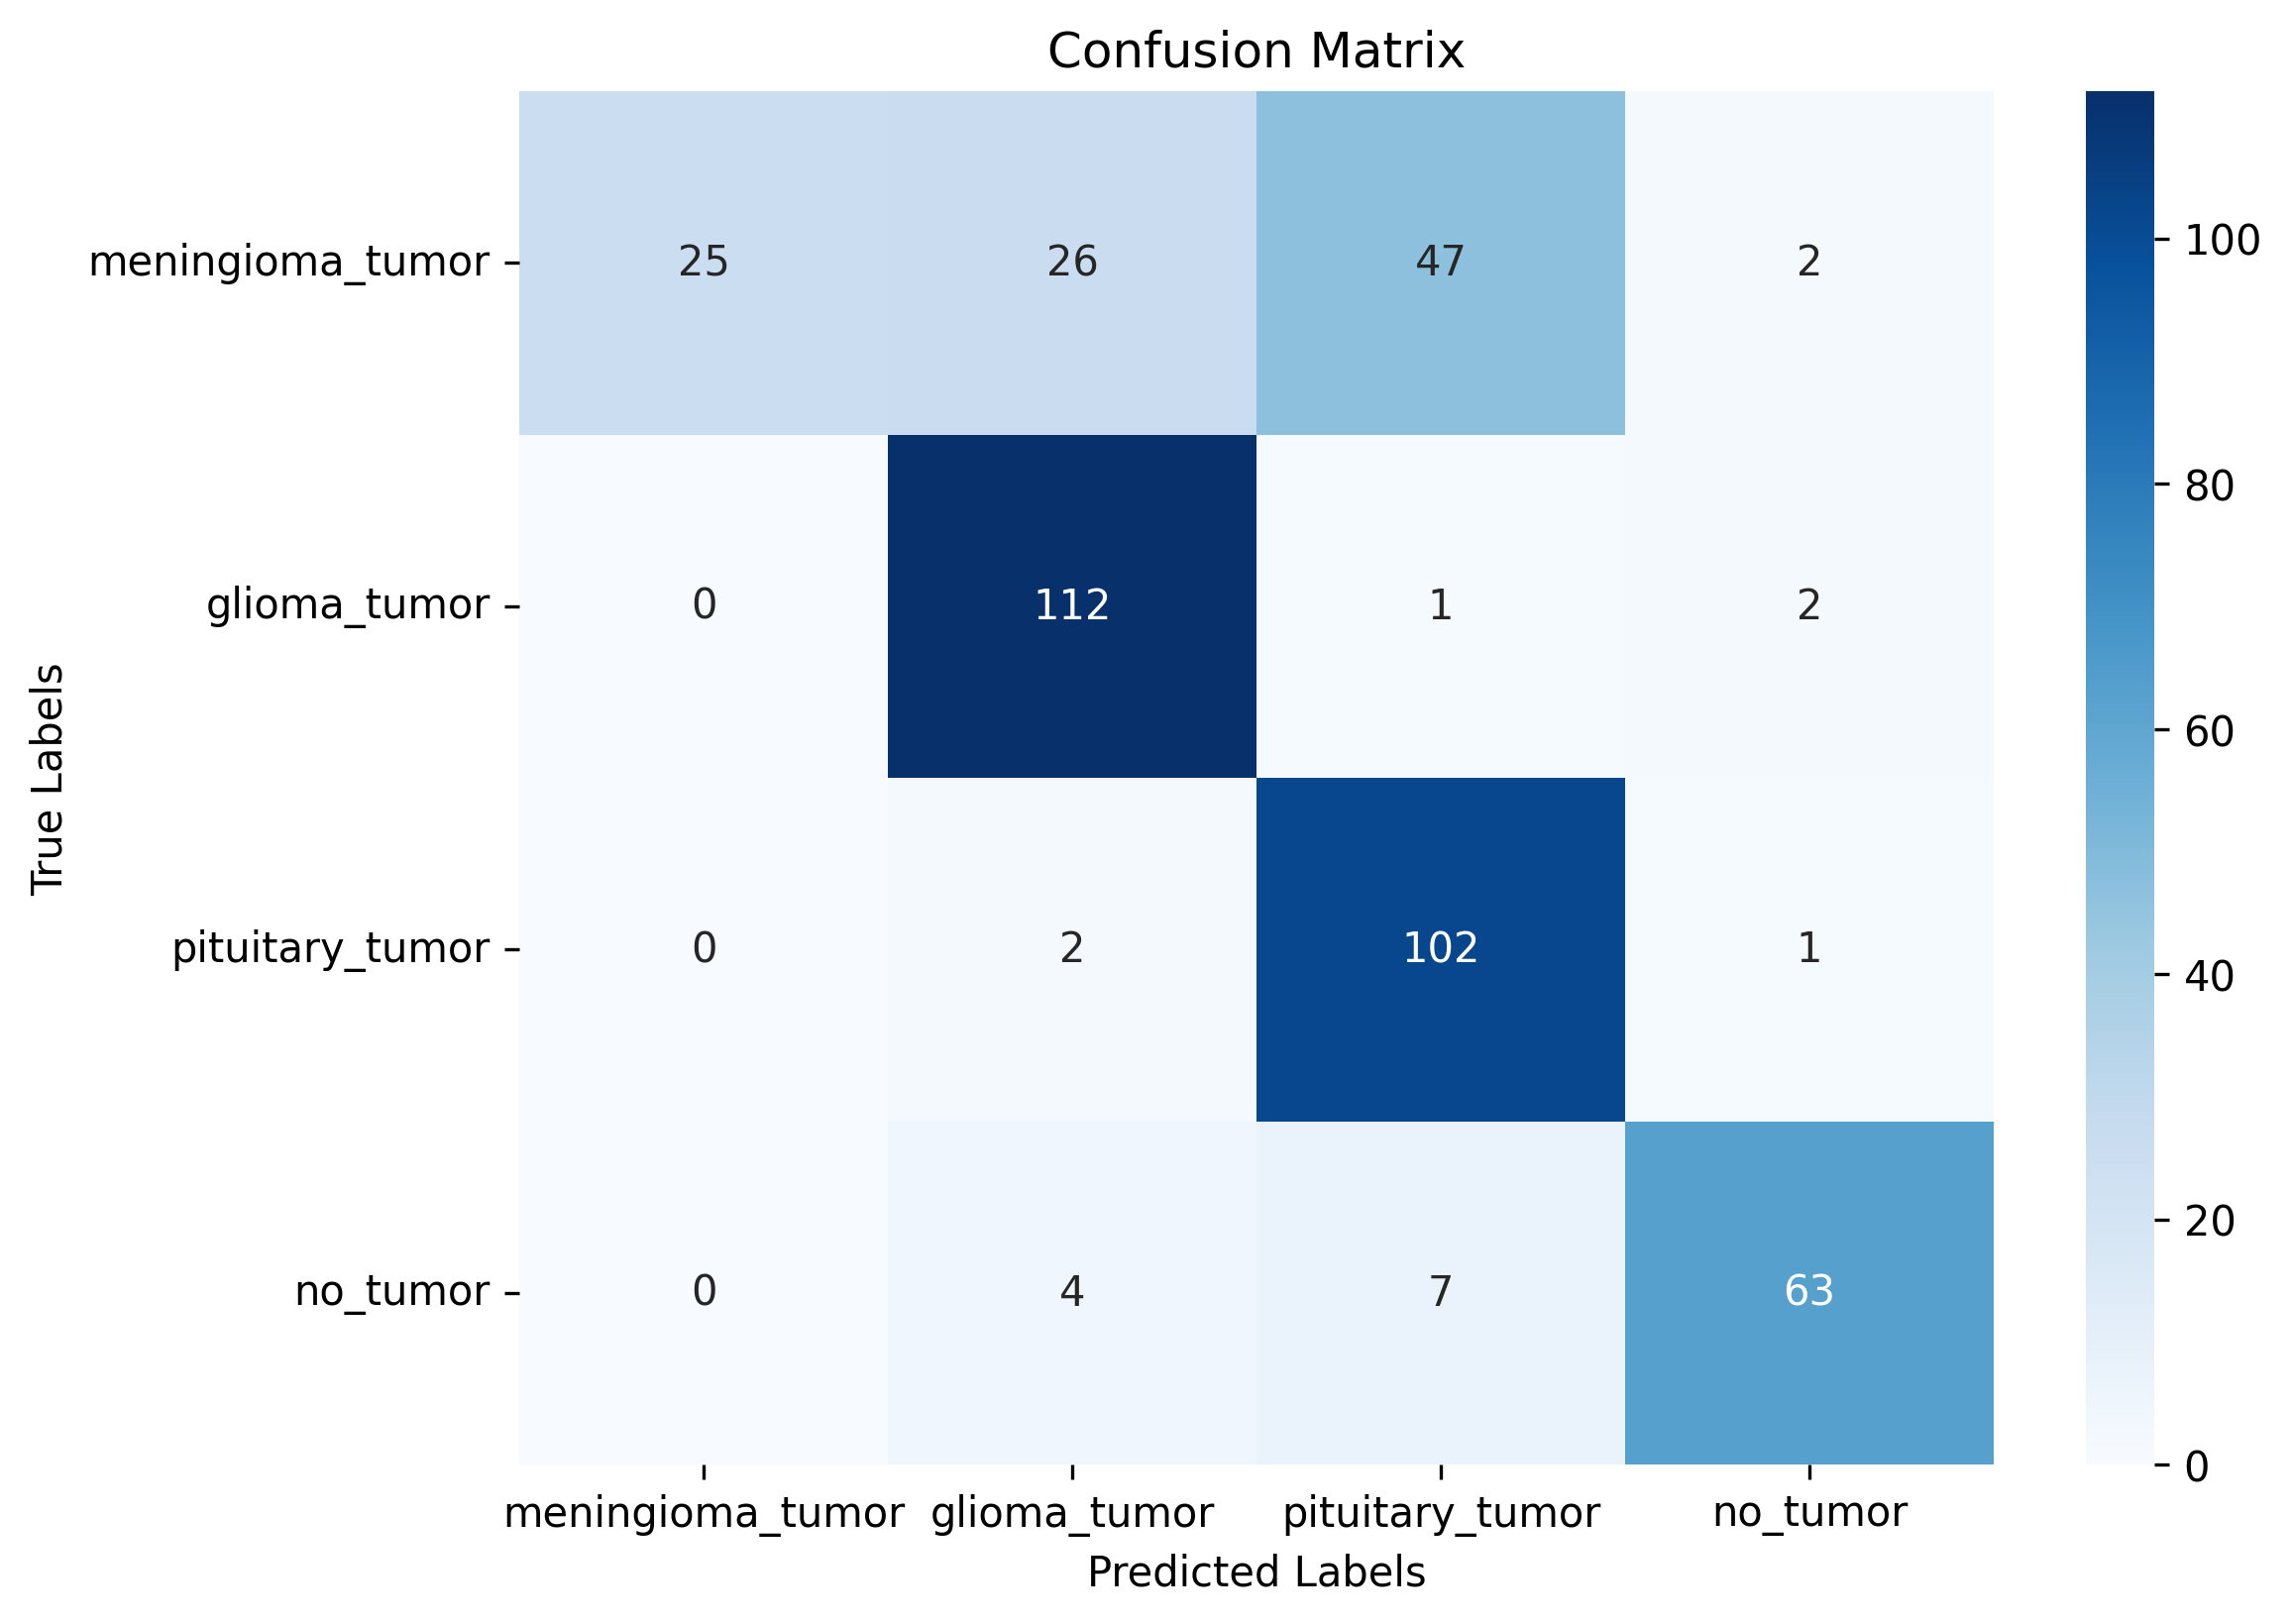

In [45]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have the 'val_ds' data set and 'model' loaded

# Create lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate over 'val_ds' and make predictions
for images, labels in val_ds:
    true_labels.extend(labels)  # Use one-hot encoded labels directly
    predicted_labels.extend(np.argmax(model4.predict(images), axis=1))

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Generate the classification report
class_names = ['meningioma_tumor', 'glioma_tumor', 'pituitary_tumor', 'no_tumor']  # Update with your class names
print(classification_report(true_labels, predicted_labels, target_names=class_names))

# Generate the confusion matrix
confusion = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


## to write

### 5. Inception-ResNet-v2

In [46]:
with tpu_strategy.scope():

    base_model5 = tf.keras.applications.InceptionResNetV2(
                        input_shape=(224, 224, 3),
                        weights='imagenet',
                        include_top=False)
    # Freeze the first 10 layers
    for layer in base_model5.layers[:10]:
        layer.trainable = False
    x = base_model5.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.4)(x)
    predictions5 = Dense(4, activation='softmax')(x)
    model5 = Model(inputs=base_model5.inputs, outputs=predictions5)
    model5.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])
    model5.summary()

219055592/219055592 [==============================] - 1s 0us/step
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 111, 111, 32  864         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 111, 111, 32  96         ['conv2d_94[0][0]']              
 ormalization)           

In [47]:
# model5.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

In [48]:
history5=model5.fit(
  train_ds,
  validation_data=test_ds,
  epochs=100)

model5.save('model5.h5')

Epoch 1/100


2023-08-06 21:21:37.628236: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-06 21:21:39.834858: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


18/18 [==============================] - ETA: 0s - loss: 0.7290 - accuracy: 0.7330

2023-08-06 21:24:59.460786: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-06 21:24:59.991987: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


18/18 [==============================] - 309s 8s/step - loss: 0.7290 - accuracy: 0.7330 - val_loss: 4.4513 - val_accuracy: 0.2230
Epoch 2/100
18/18 [==============================] - 4s 218ms/step - loss: 0.2028 - accuracy: 0.9338 - val_loss: 4.1597 - val_accuracy: 0.2056
Epoch 3/100
18/18 [==============================] - 4s 218ms/step - loss: 0.0925 - accuracy: 0.9721 - val_loss: 5.4488 - val_accuracy: 0.3136
Epoch 4/100
18/18 [==============================] - 4s 218ms/step - loss: 0.0893 - accuracy: 0.9660 - val_loss: 3.3483 - val_accuracy: 0.3310
Epoch 5/100
18/18 [==============================] - 4s 216ms/step - loss: 0.0646 - accuracy: 0.9769 - val_loss: 3.7747 - val_accuracy: 0.2683
Epoch 6/100
18/18 [==============================] - 4s 218ms/step - loss: 0.0363 - accuracy: 0.9865 - val_loss: 1.1374 - val_accuracy: 0.6063
Epoch 7/100
18/18 [==============================] - 4s 219ms/step - loss: 0.0366 - accuracy: 0.9865 - val_loss: 1.9883 - val_accuracy: 0.5854
Epoch 8/100


In [49]:
inceptionresnetv2_evaluation = model5.evaluate(val_ds)
inceptionresnetv2_evaluation[1]*100

4/4 [==============================] - 14s 4s/step - loss: 3.3323 - accuracy: 0.7665


76.64974331855774

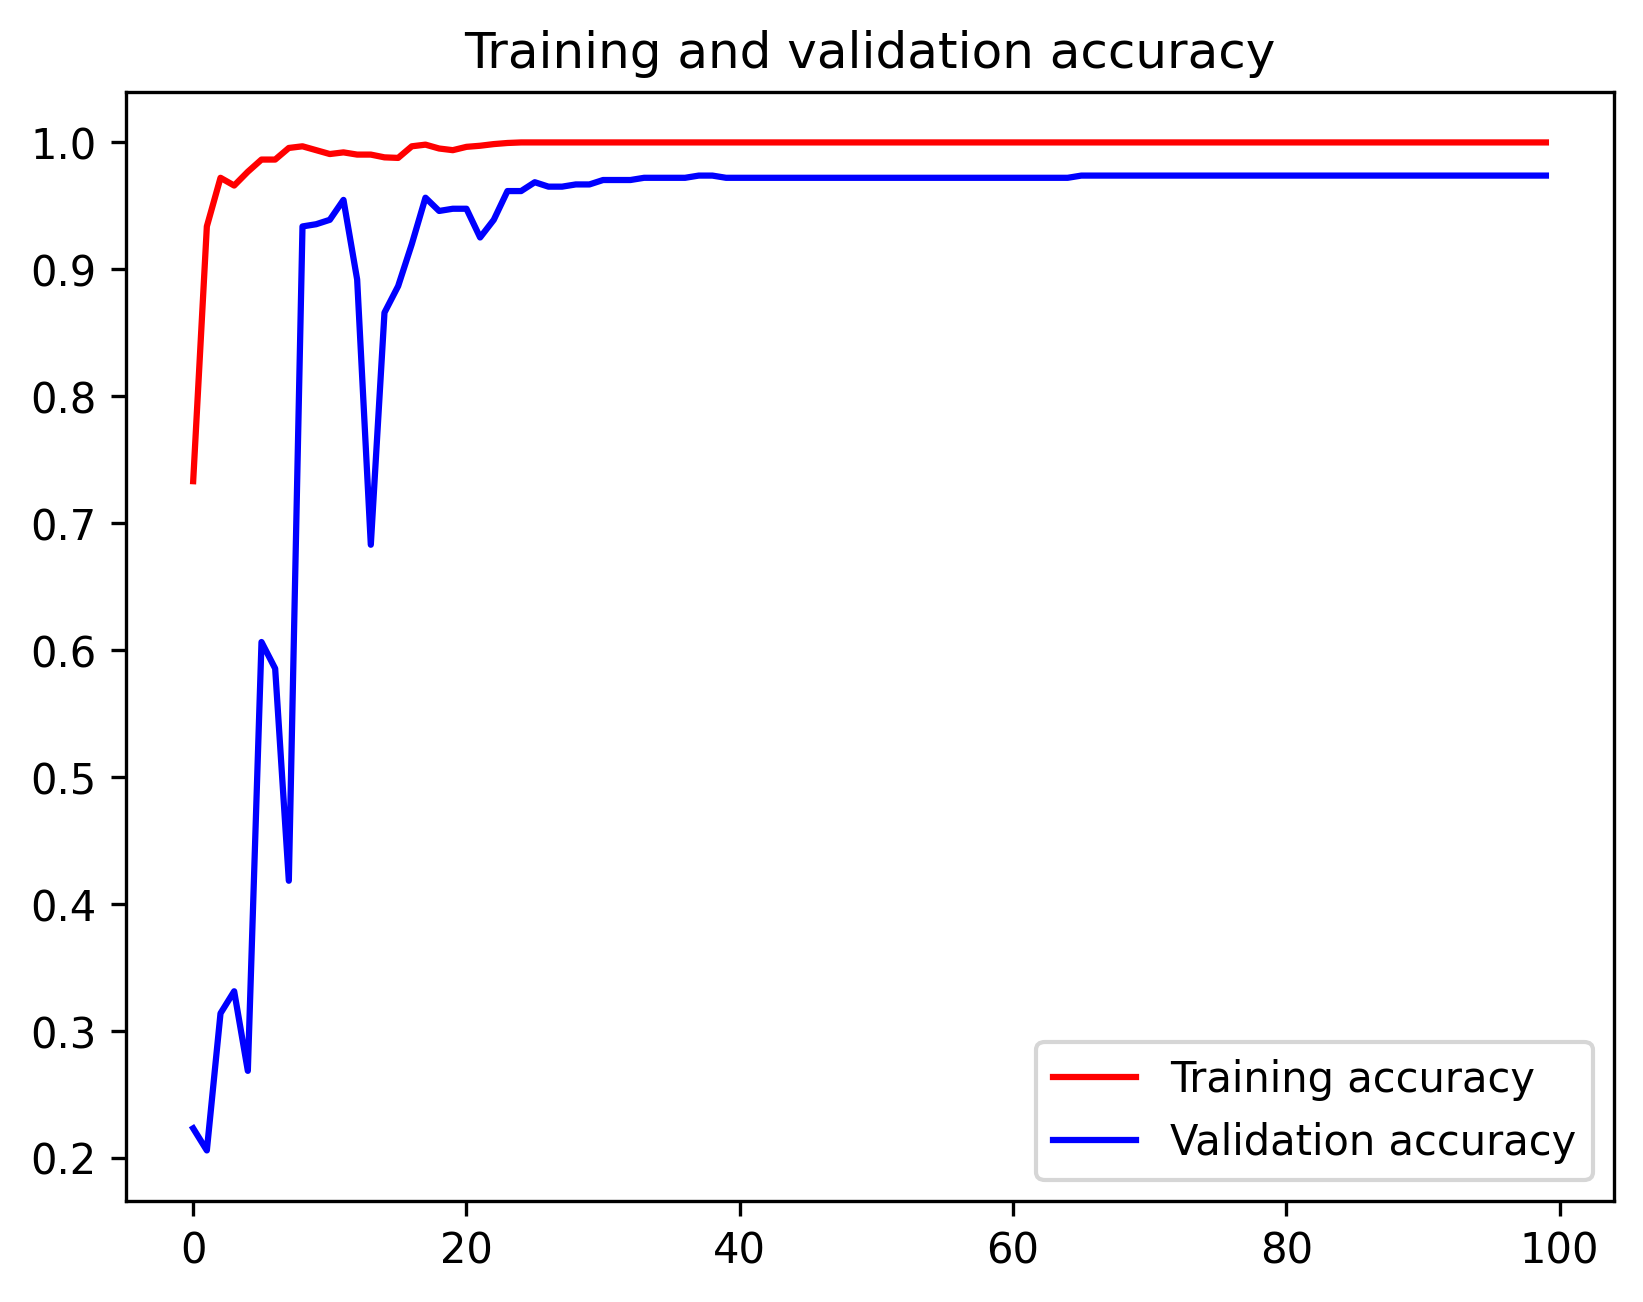

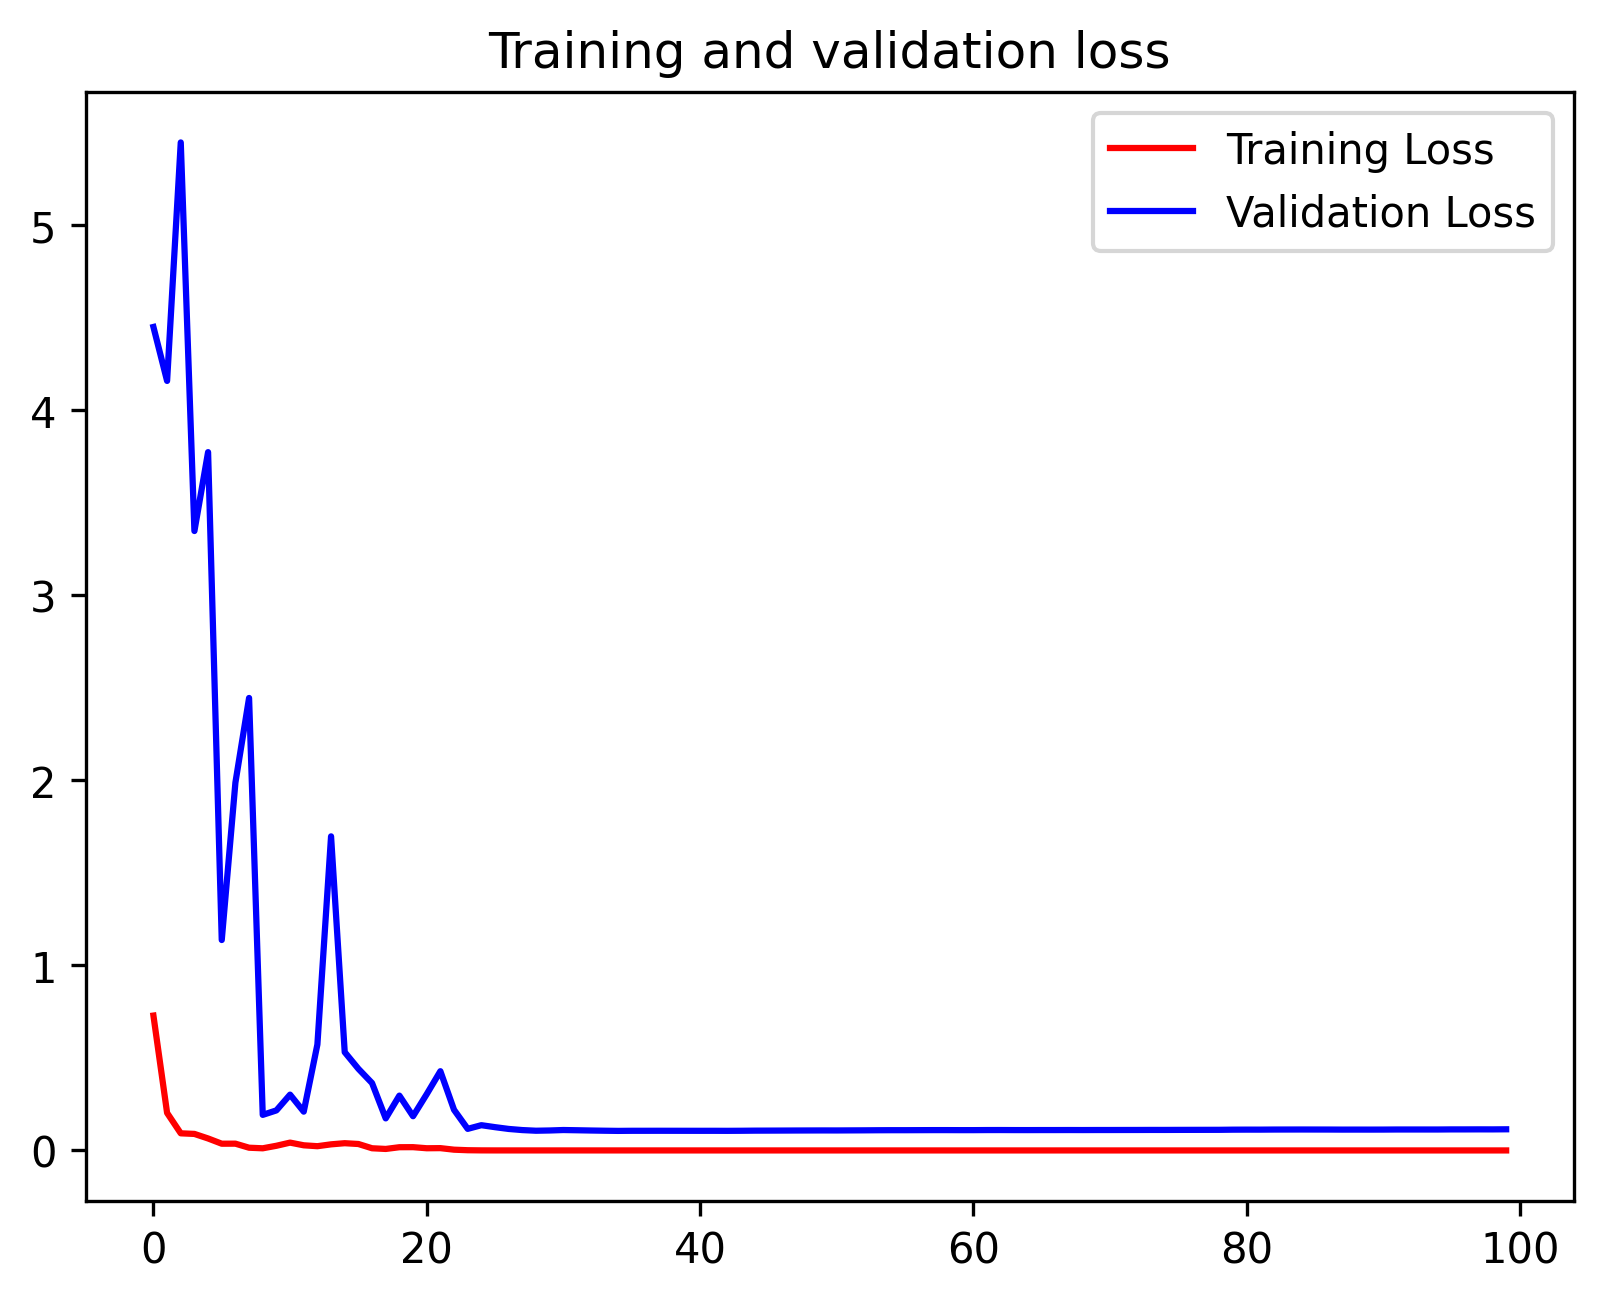

In [50]:
import matplotlib.pyplot as plt
acc = history5.history['accuracy']
val_acc = history5.history['val_accuracy']
loss = history5.history['loss']
val_loss = history5.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

2023-08-06 21:33:34.665034: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-06 21:33:35.118390: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


4/4 [==============================] - 1s 34ms/step


2023-08-06 21:33:57.697085: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-06 21:33:58.216486: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


1/1 [==============================] - 19s 19s/step
                  precision    recall  f1-score   support

meningioma_tumor       0.93      0.26      0.41       100
    glioma_tumor       0.65      0.98      0.78       115
 pituitary_tumor       0.76      0.97      0.85       105
        no_tumor       1.00      0.80      0.89        74

        accuracy                           0.76       394
       macro avg       0.84      0.75      0.73       394
    weighted avg       0.82      0.76      0.73       394



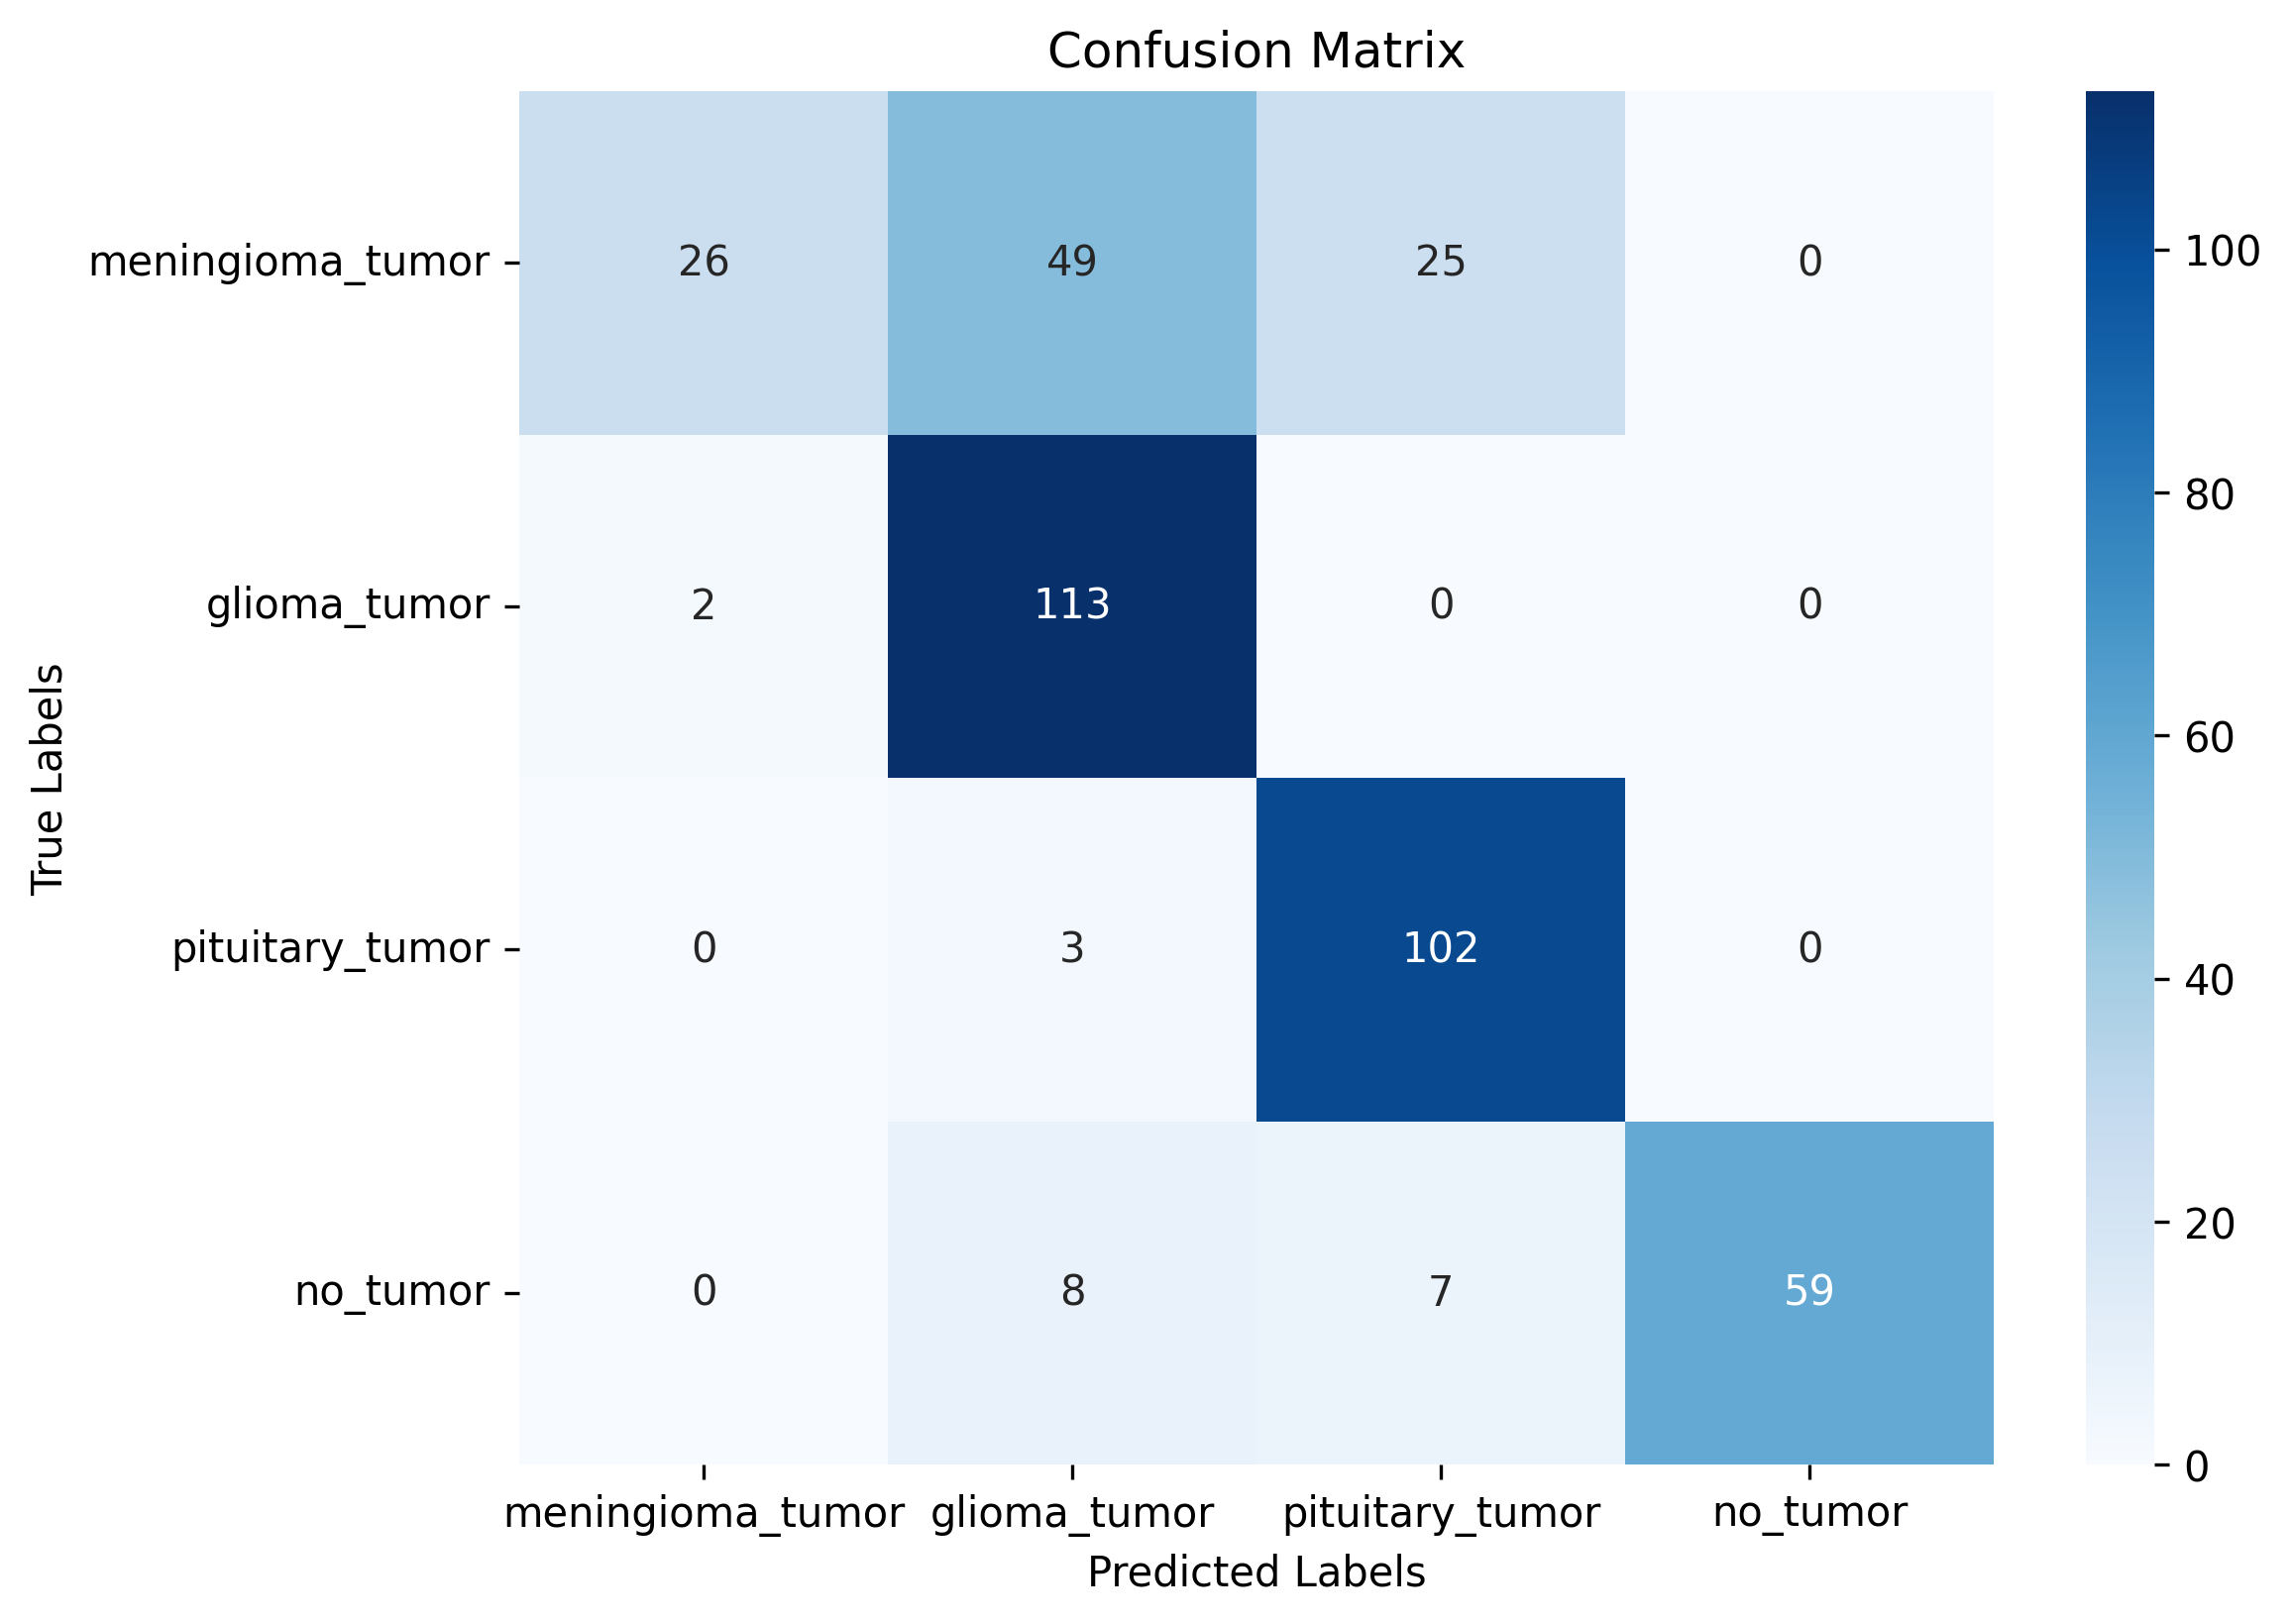

In [51]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have the 'val_ds' data set and 'model' loaded

# Create lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate over 'val_ds' and make predictions
for images, labels in val_ds:
    true_labels.extend(labels)  # Use one-hot encoded labels directly
    predicted_labels.extend(np.argmax(model5.predict(images), axis=1))

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Generate the classification report
class_names = ['meningioma_tumor', 'glioma_tumor', 'pituitary_tumor', 'no_tumor']  # Update with your class names
print(classification_report(true_labels, predicted_labels, target_names=class_names))

# Generate the confusion matrix
confusion = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


### 6. DenseNet-201

In [52]:
with tpu_strategy.scope():

    base_model6 = tf.keras.applications.DenseNet201(
                        input_shape=(224, 224, 3),
                        weights='imagenet',
                        include_top=False)
    # Freeze the first 10 layers
    for layer in base_model6.layers[:10]:
        layer.trainable = False
    x = base_model6.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.4)(x)
    predictions6 = Dense(4, activation='softmax')(x)
    model6 = Model(inputs=base_model6.inputs, outputs=predictions6)
    model6.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])
    model6.summary()

74836368/74836368 [==============================] - 1s 0us/step
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_6[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                           

In [53]:
# model6.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

In [54]:
history6=model6.fit(
  train_ds,
  validation_data=test_ds,
  epochs=100)

model6.save('model6.h5')

Epoch 1/100


2023-08-06 21:36:33.292496: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-06 21:36:35.953048: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


18/18 [==============================] - ETA: 0s - loss: 0.6043 - accuracy: 0.7770

2023-08-06 21:40:24.462181: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-06 21:40:25.013053: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


18/18 [==============================] - 355s 9s/step - loss: 0.6043 - accuracy: 0.7770 - val_loss: 8.7384 - val_accuracy: 0.2683
Epoch 2/100
18/18 [==============================] - 5s 256ms/step - loss: 0.2200 - accuracy: 0.9273 - val_loss: 10.2033 - val_accuracy: 0.3833
Epoch 3/100
18/18 [==============================] - 5s 256ms/step - loss: 0.1430 - accuracy: 0.9543 - val_loss: 7.5900 - val_accuracy: 0.4233
Epoch 4/100
18/18 [==============================] - 5s 271ms/step - loss: 0.0644 - accuracy: 0.9800 - val_loss: 2.8729 - val_accuracy: 0.6951
Epoch 5/100
18/18 [==============================] - 5s 256ms/step - loss: 0.0540 - accuracy: 0.9852 - val_loss: 9.1622 - val_accuracy: 0.4808
Epoch 6/100
18/18 [==============================] - 5s 255ms/step - loss: 0.0625 - accuracy: 0.9800 - val_loss: 4.0161 - val_accuracy: 0.6969
Epoch 7/100
18/18 [==============================] - 5s 258ms/step - loss: 0.0784 - accuracy: 0.9756 - val_loss: 11.4305 - val_accuracy: 0.4146
Epoch 8/10

In [55]:
densenet201_evaluation = model6.evaluate(val_ds)
densenet201_evaluation[1]*100

4/4 [==============================] - 27s 9s/step - loss: 3.3591 - accuracy: 0.7792


77.9187798500061

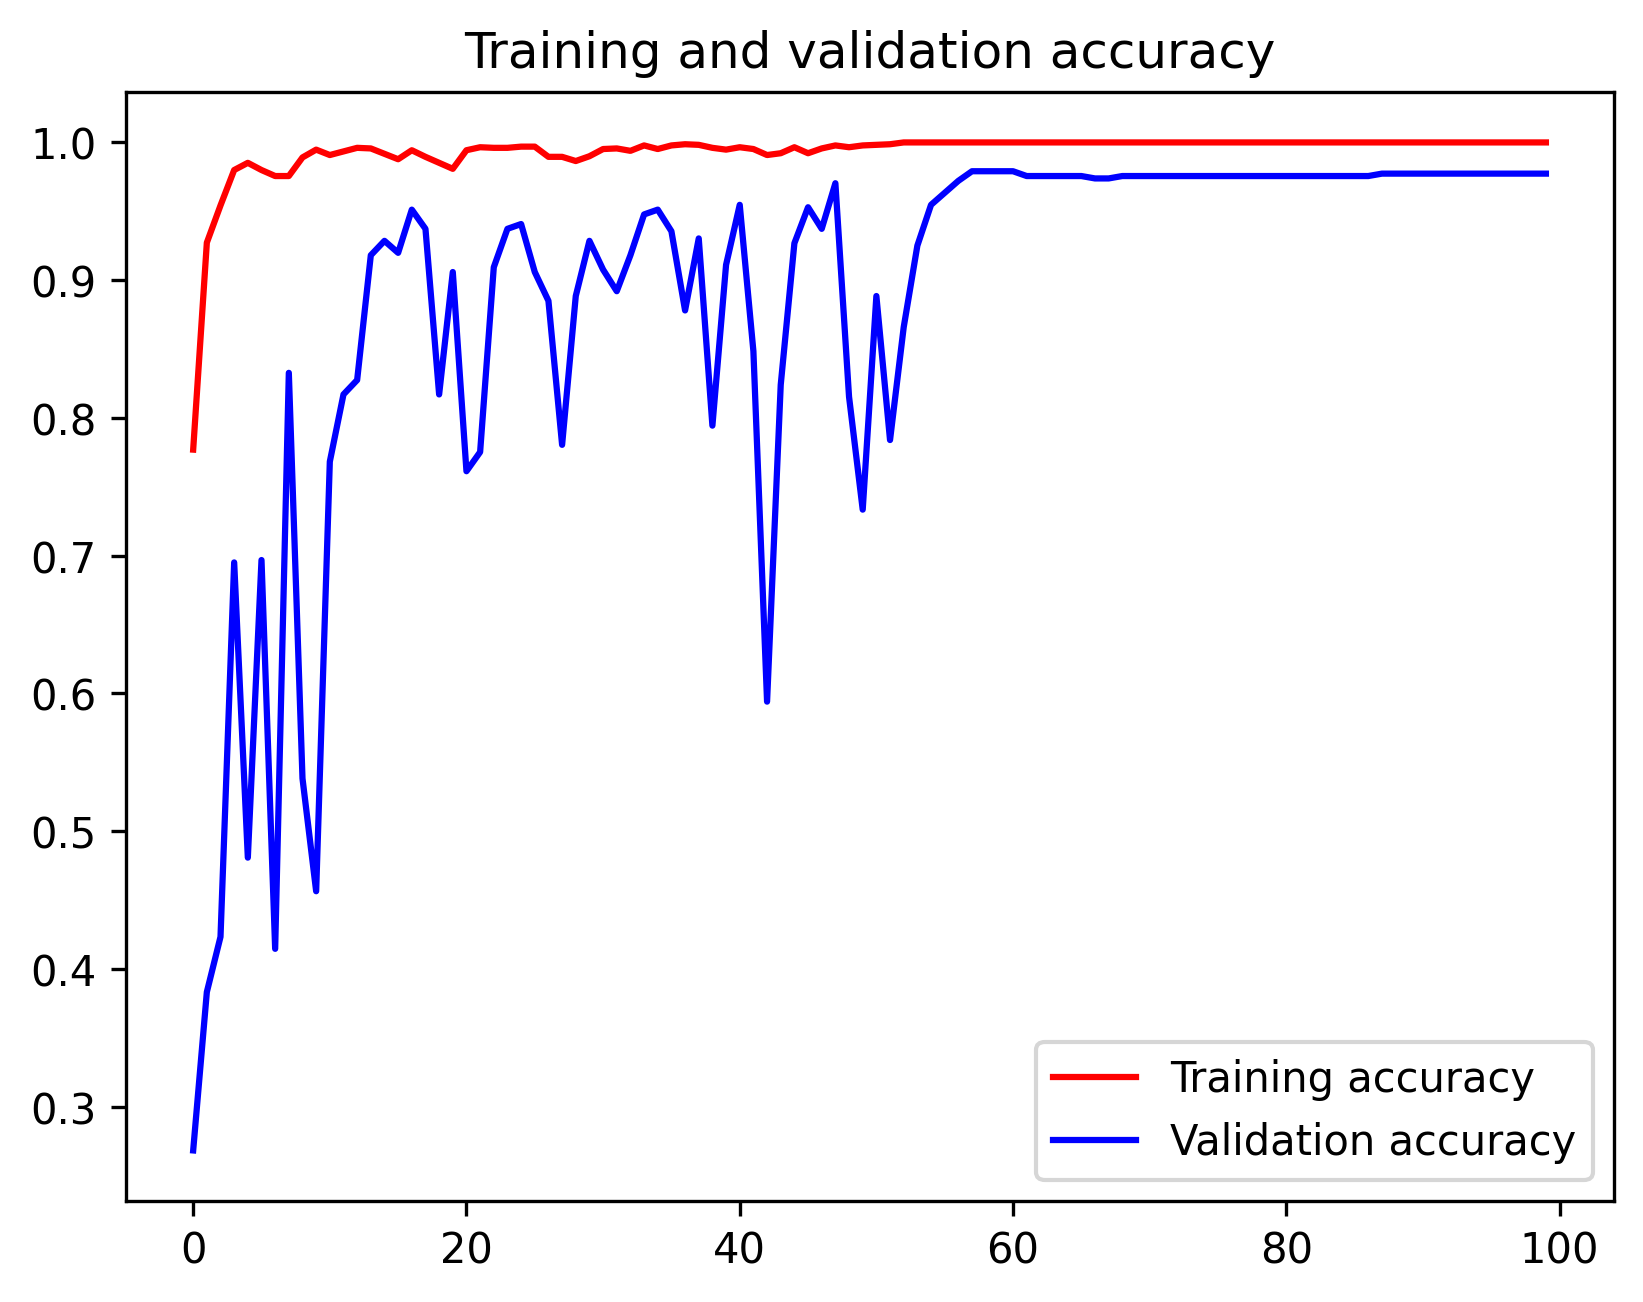

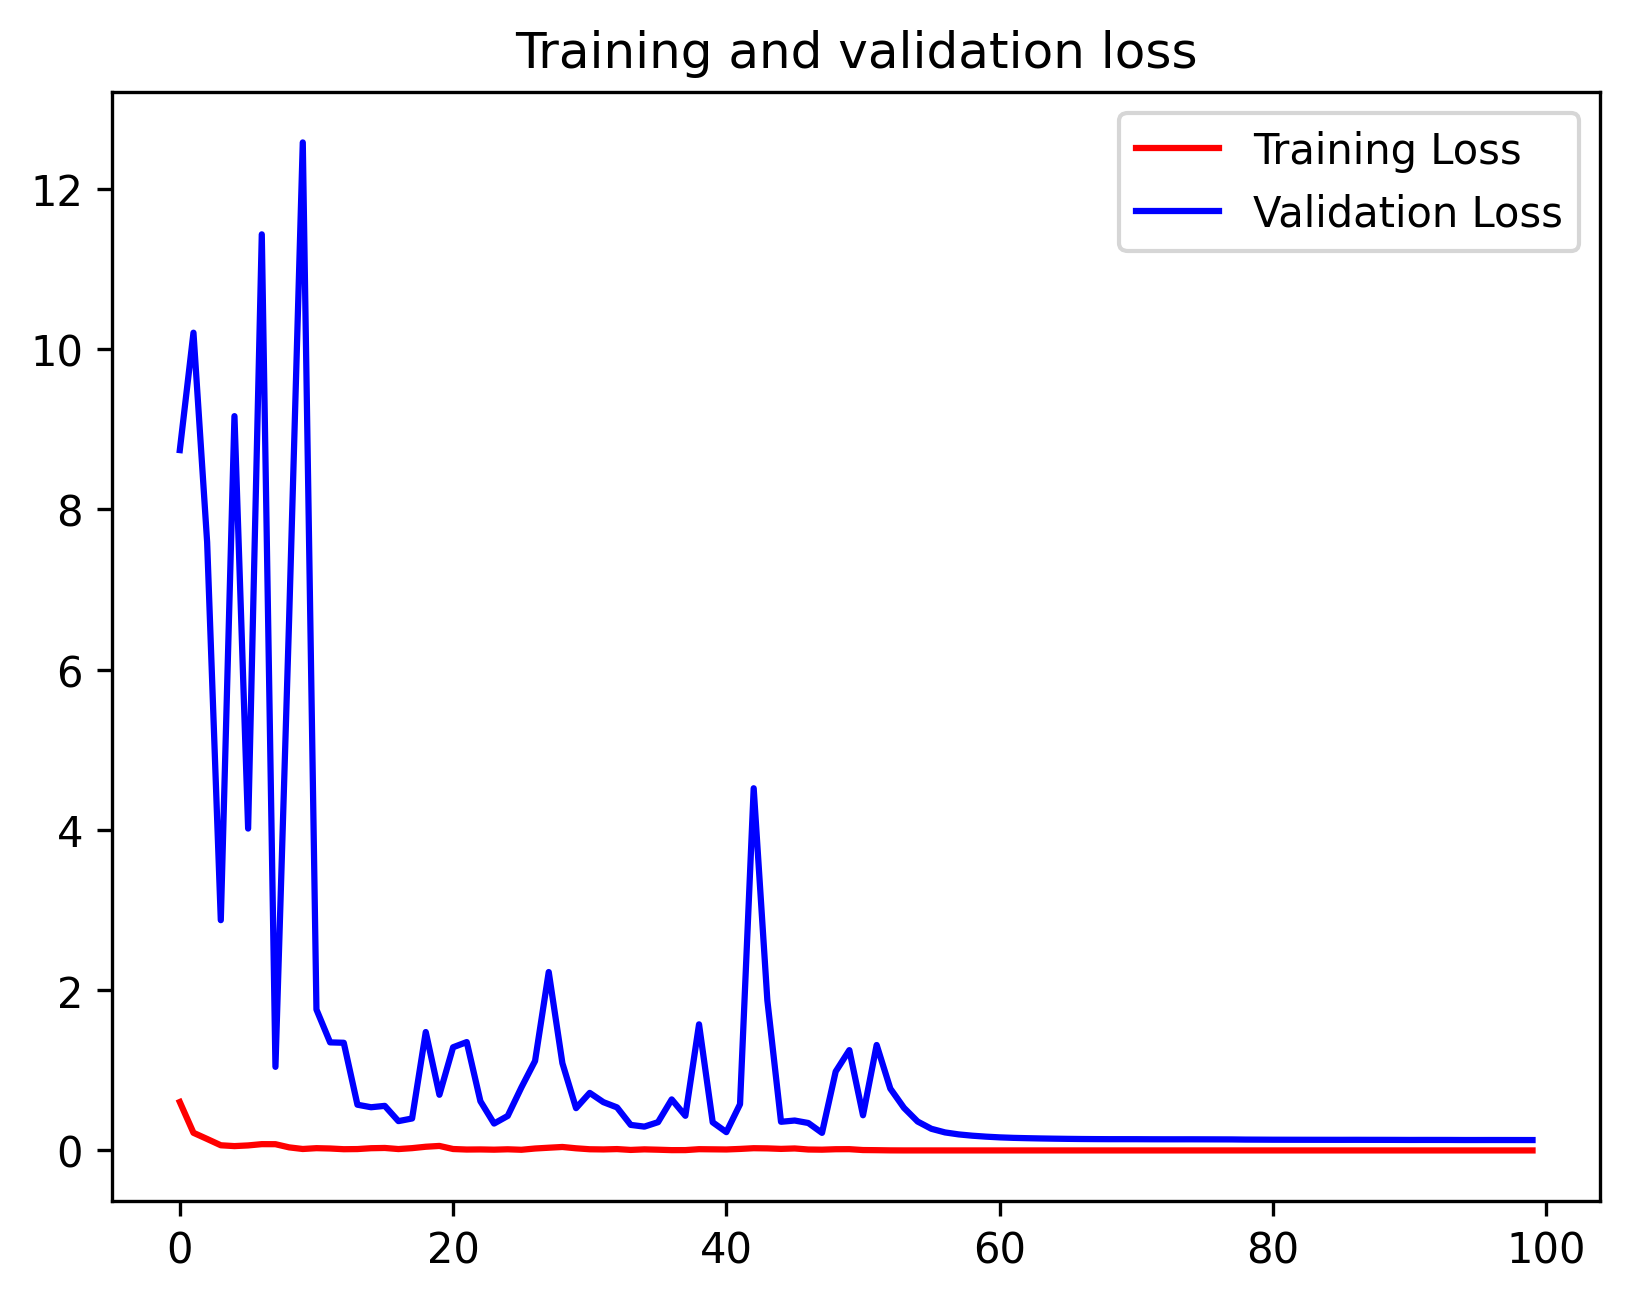

In [56]:
import matplotlib.pyplot as plt
acc = history6.history['accuracy']
val_acc = history6.history['val_accuracy']
loss = history6.history['loss']
val_loss = history6.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

2023-08-06 21:50:17.665639: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-06 21:50:18.099509: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


4/4 [==============================] - 1s 39ms/step


2023-08-06 21:50:49.458815: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-06 21:50:49.962138: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


1/1 [==============================] - 32s 32s/step
                  precision    recall  f1-score   support

meningioma_tumor       1.00      0.27      0.43       100
    glioma_tumor       0.74      0.97      0.84       115
 pituitary_tumor       0.71      0.99      0.83       105
        no_tumor       0.93      0.86      0.90        74

        accuracy                           0.78       394
       macro avg       0.84      0.77      0.75       394
    weighted avg       0.83      0.78      0.74       394



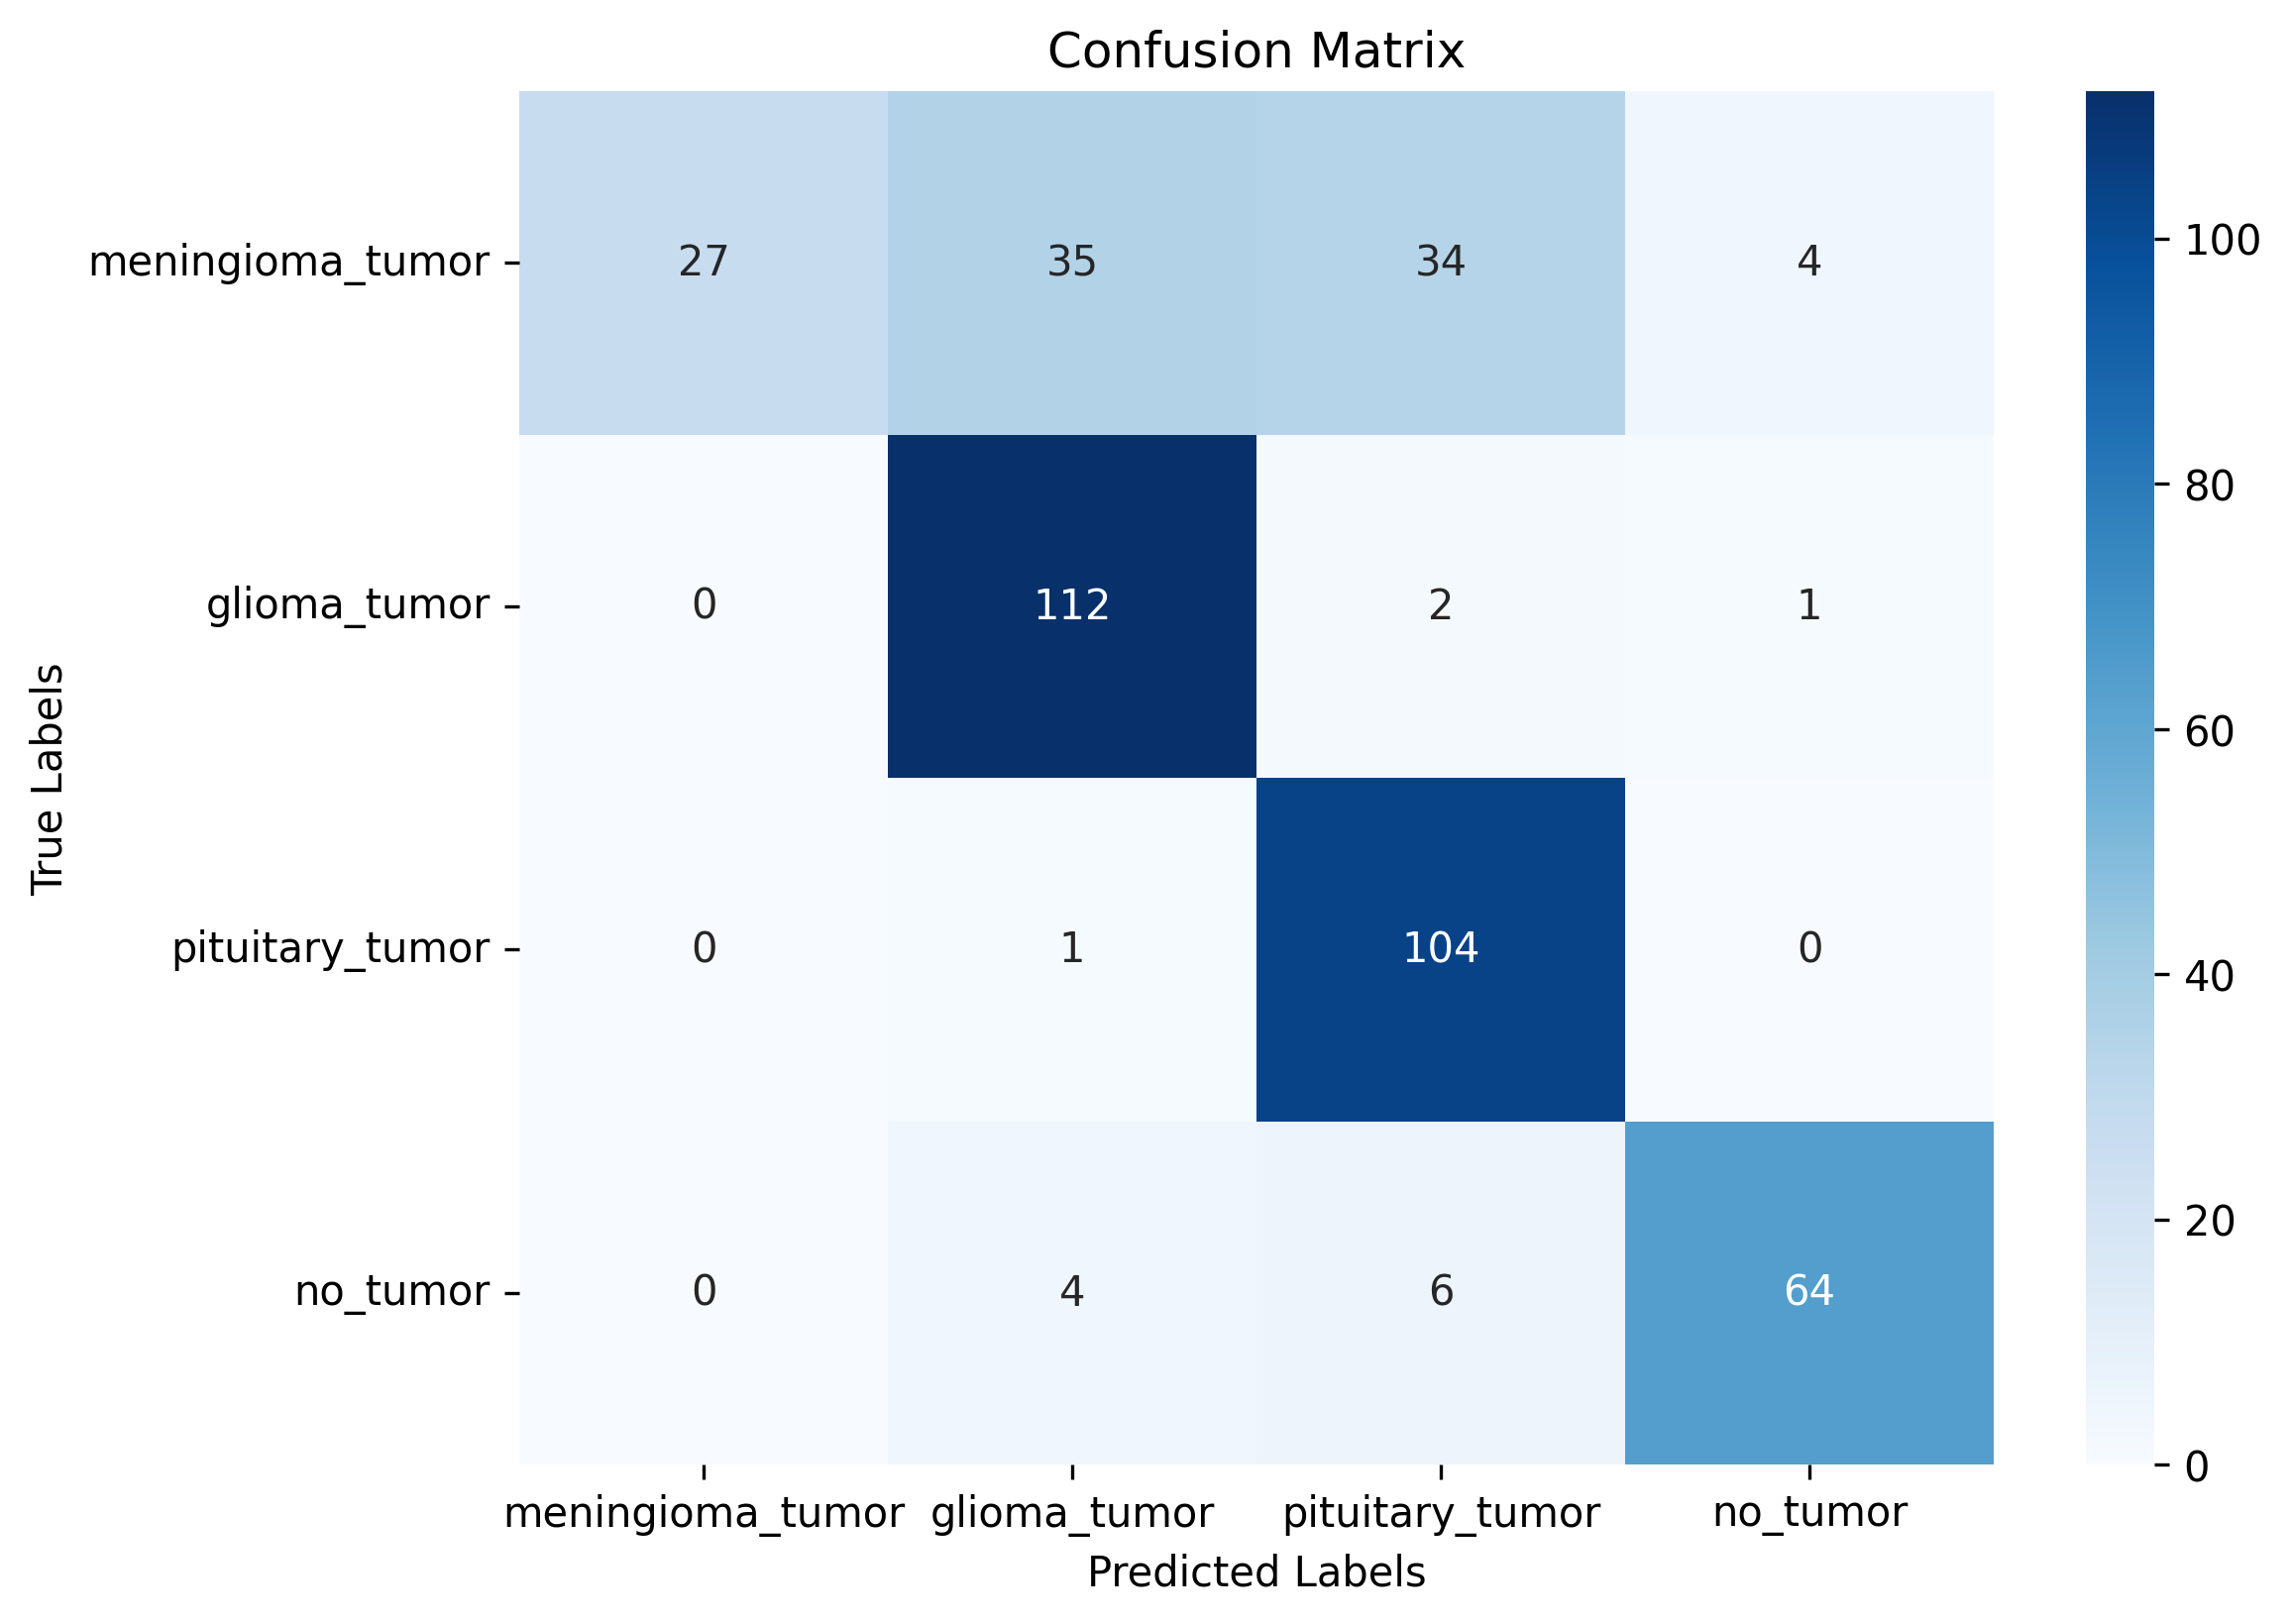

In [57]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have the 'val_ds' data set and 'model' loaded

# Create lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate over 'val_ds' and make predictions
for images, labels in val_ds:
    true_labels.extend(labels)  # Use one-hot encoded labels directly
    predicted_labels.extend(np.argmax(model6.predict(images), axis=1))

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Generate the classification report
class_names = ['meningioma_tumor', 'glioma_tumor', 'pituitary_tumor', 'no_tumor']  # Update with your class names
print(classification_report(true_labels, predicted_labels, target_names=class_names))

# Generate the confusion matrix
confusion = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


### AlexNet

### 7. ResNet-101

In [58]:
with tpu_strategy.scope():

    base_model7 = tf.keras.applications.ResNet101(
                        input_shape=(224, 224, 3),
                        weights='imagenet',
                        include_top=False)
    # Freeze the first 10 layers
    for layer in base_model7.layers[:10]:
        layer.trainable = False
    x = base_model7.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.4)(x)
    predictions7 = Dense(4, activation='softmax')(x)
    model7 = Model(inputs=base_model7.inputs, outputs=predictions7)
    model7.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])
    model7.summary()

171446536/171446536 [==============================] - 1s 0us/step
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_7[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                         

In [59]:
# model7.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

In [60]:
history7=model7.fit(
  train_ds,
  validation_data=test_ds,
  epochs=100)

model7.save('model7.h5')

Epoch 1/100


2023-08-06 21:52:34.667170: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-06 21:52:36.291181: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


18/18 [==============================] - ETA: 0s - loss: 0.8675 - accuracy: 0.7317

2023-08-06 21:54:40.201498: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-06 21:54:40.552578: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


18/18 [==============================] - 197s 5s/step - loss: 0.8675 - accuracy: 0.7317 - val_loss: 58131340.0000 - val_accuracy: 0.2857
Epoch 2/100
18/18 [==============================] - 3s 187ms/step - loss: 0.2985 - accuracy: 0.8863 - val_loss: 640069696.0000 - val_accuracy: 0.2857
Epoch 3/100
18/18 [==============================] - 3s 191ms/step - loss: 0.1533 - accuracy: 0.9460 - val_loss: 126043080.0000 - val_accuracy: 0.2857
Epoch 4/100
18/18 [==============================] - 3s 191ms/step - loss: 0.0790 - accuracy: 0.9730 - val_loss: 383139.2188 - val_accuracy: 0.2892
Epoch 5/100
18/18 [==============================] - 3s 194ms/step - loss: 0.0734 - accuracy: 0.9760 - val_loss: 13736.5723 - val_accuracy: 0.2822
Epoch 6/100
18/18 [==============================] - 3s 188ms/step - loss: 0.0713 - accuracy: 0.9726 - val_loss: 37921.2500 - val_accuracy: 0.2631
Epoch 7/100
18/18 [==============================] - 3s 189ms/step - loss: 0.0746 - accuracy: 0.9752 - val_loss: 19520.

In [61]:
resnet101_evaluation = model7.evaluate(val_ds)
resnet101_evaluation[1]*100

4/4 [==============================] - 11s 3s/step - loss: 3.6942 - accuracy: 0.7538


75.38071274757385

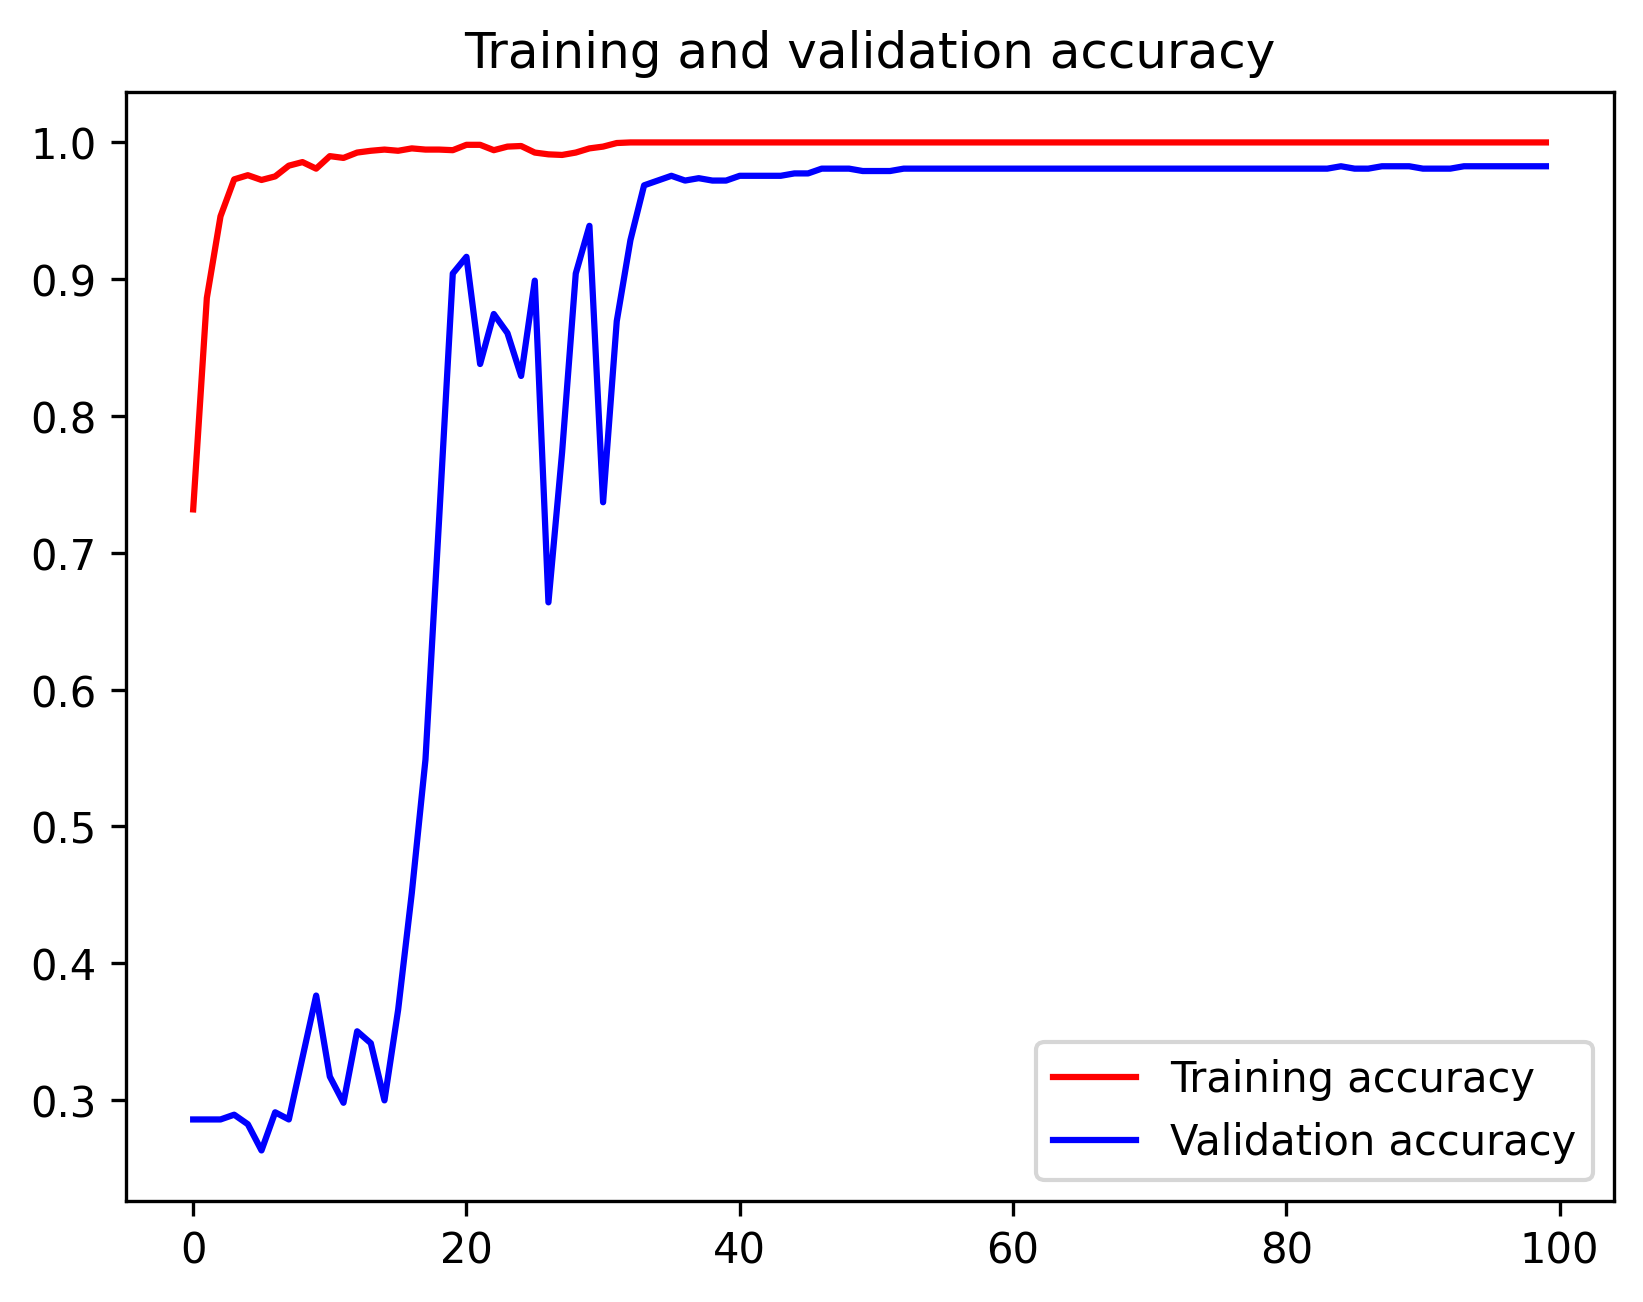

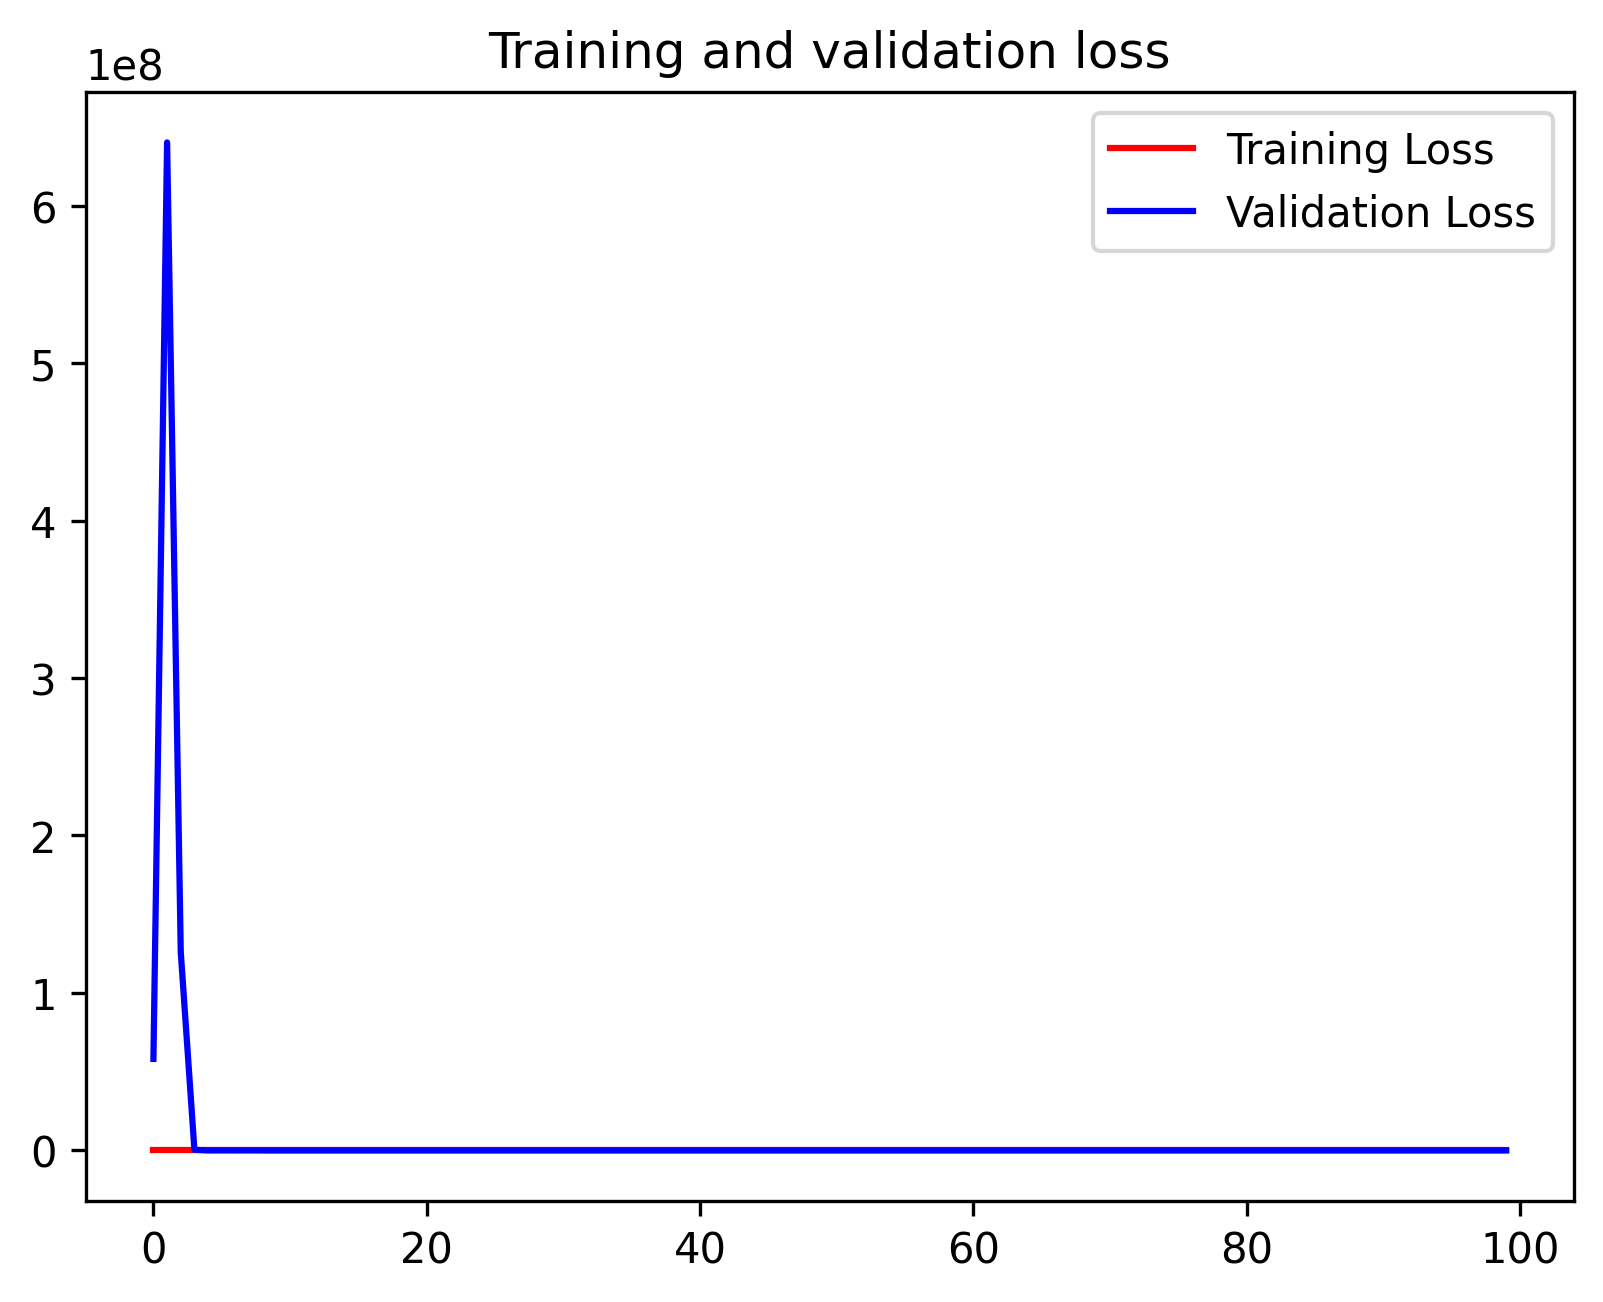

In [62]:
import matplotlib.pyplot as plt
acc = history7.history['accuracy']
val_acc = history7.history['val_accuracy']
loss = history7.history['loss']
val_loss = history7.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

2023-08-06 22:01:56.260800: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-06 22:01:56.528977: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


4/4 [==============================] - 1s 23ms/step


2023-08-06 22:02:12.482785: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-06 22:02:12.804656: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


1/1 [==============================] - 14s 14s/step
                  precision    recall  f1-score   support

meningioma_tumor       1.00      0.21      0.35       100
    glioma_tumor       0.76      0.98      0.86       115
 pituitary_tumor       0.63      0.99      0.77       105
        no_tumor       0.98      0.80      0.88        74

        accuracy                           0.75       394
       macro avg       0.84      0.75      0.71       394
    weighted avg       0.83      0.75      0.71       394



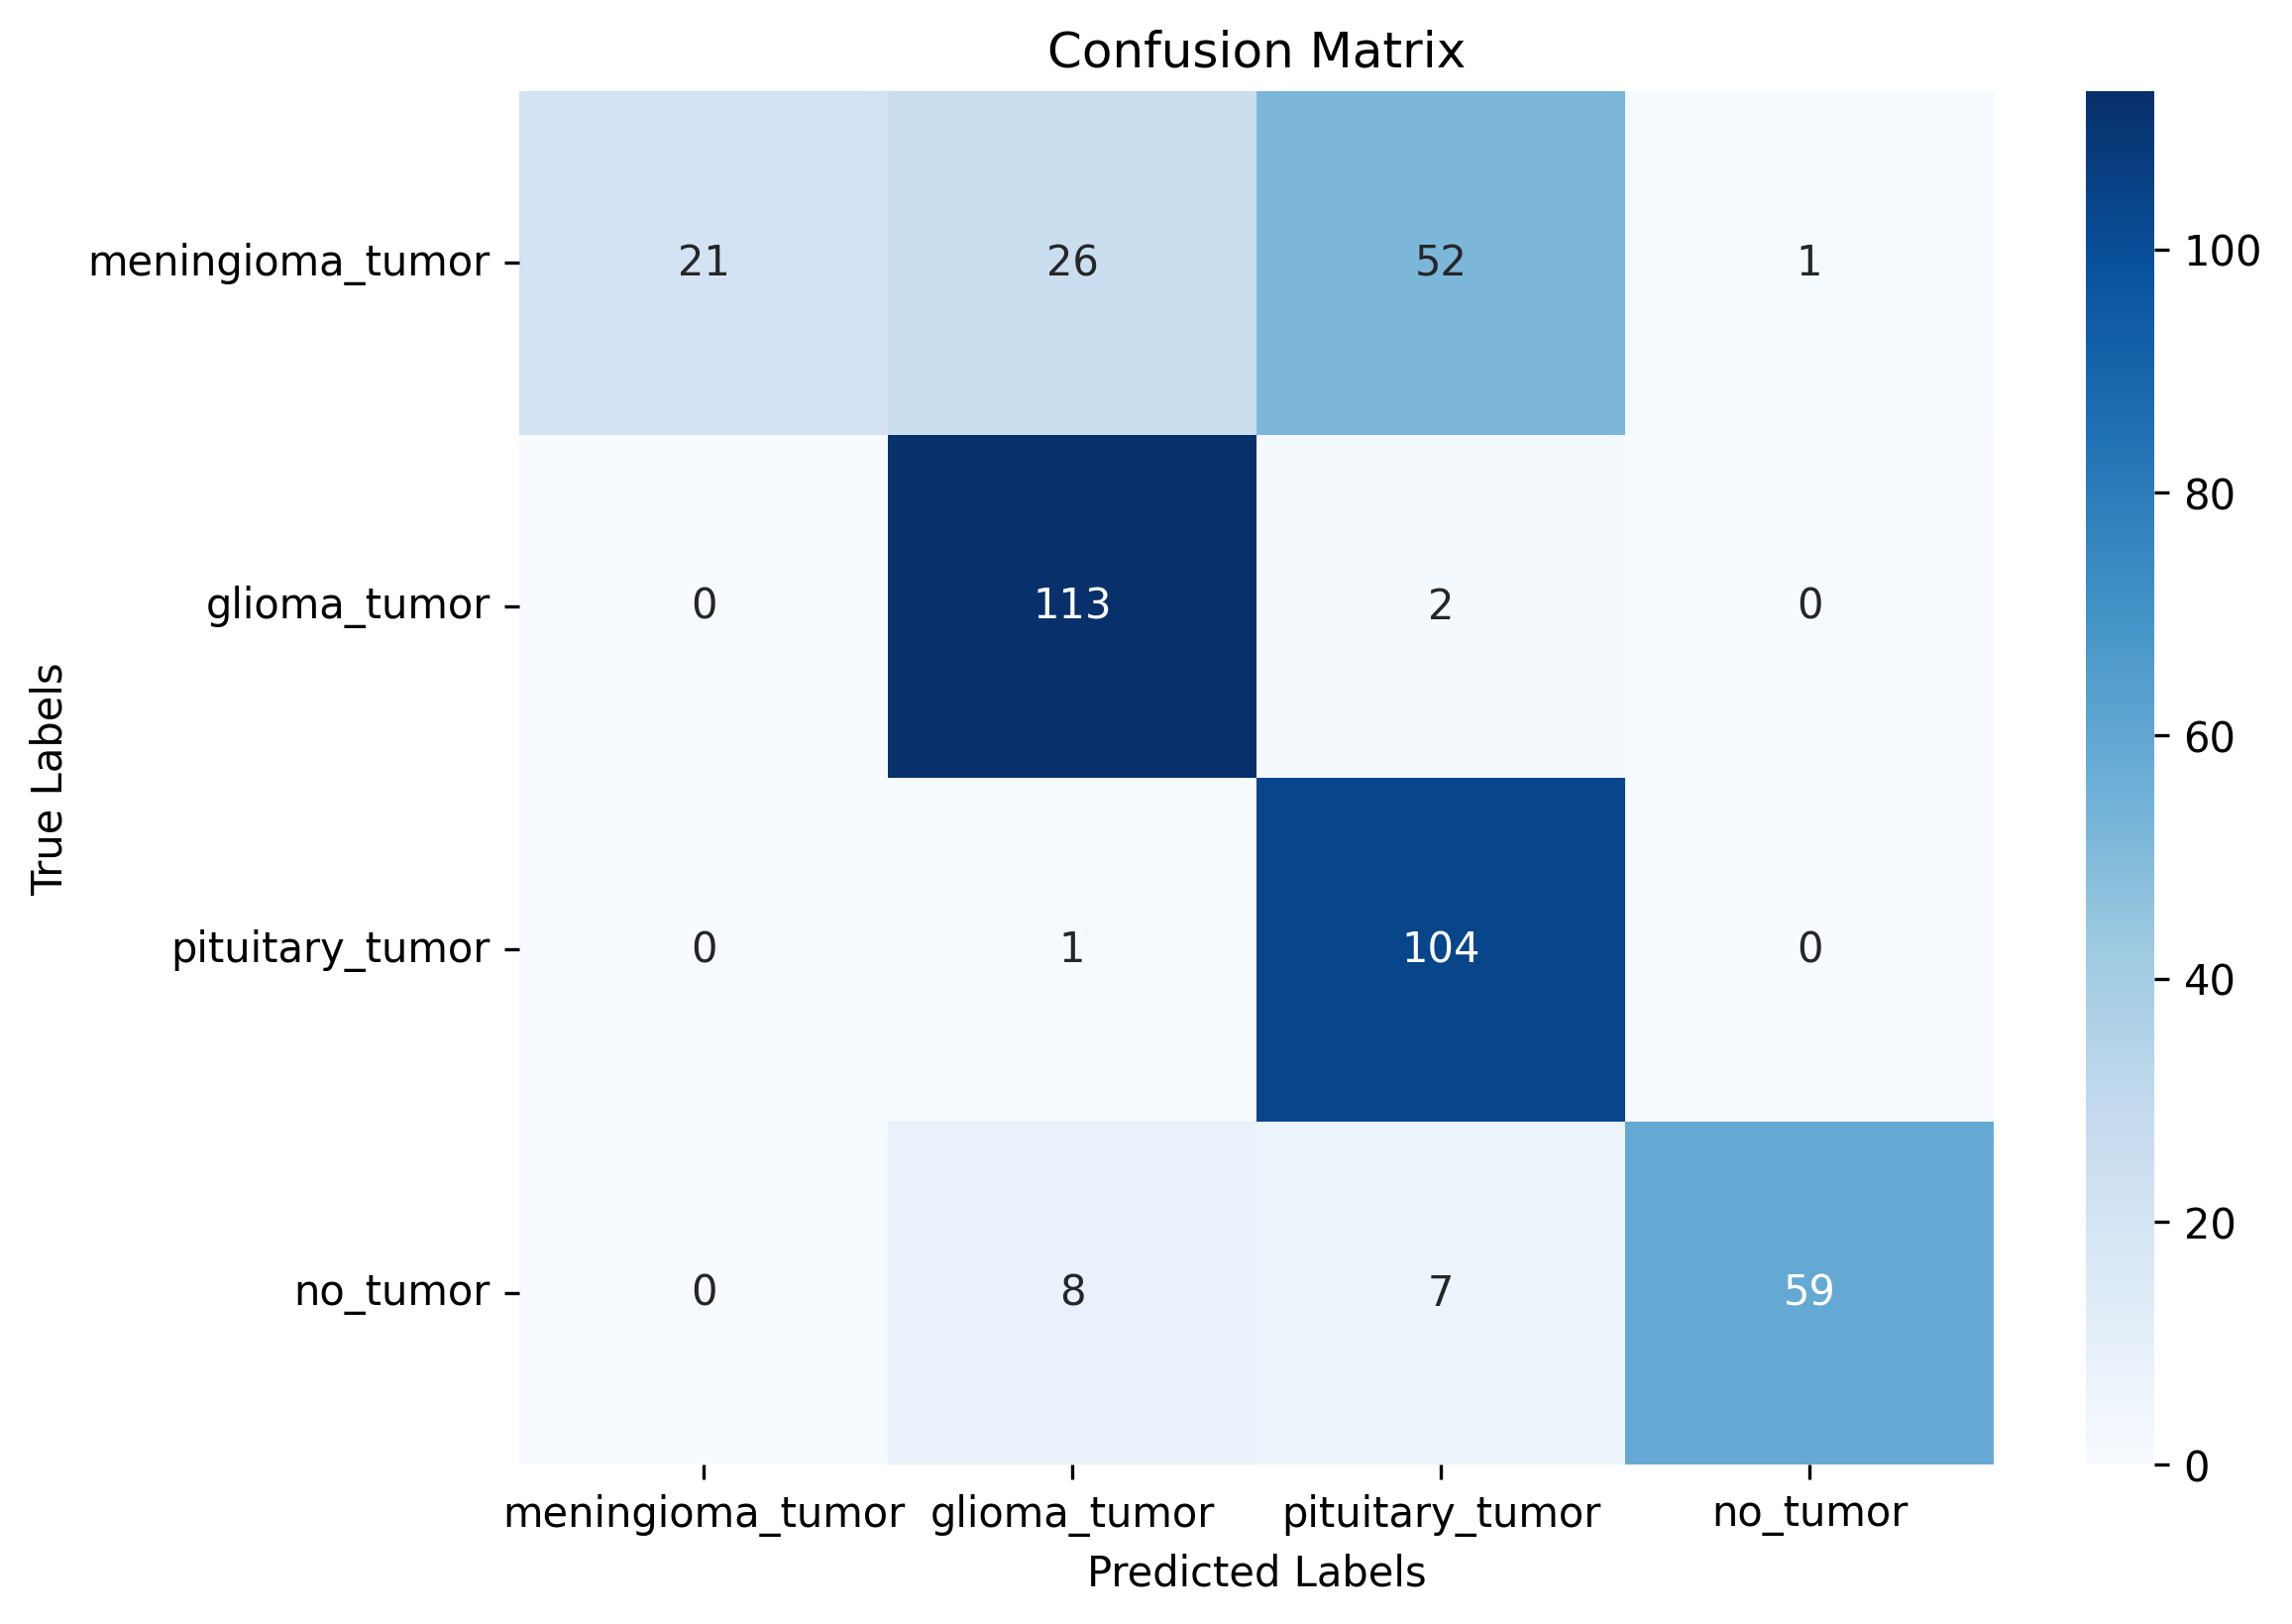

In [63]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have the 'val_ds' data set and 'model' loaded

# Create lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate over 'val_ds' and make predictions
for images, labels in val_ds:
    true_labels.extend(labels)  # Use one-hot encoded labels directly
    predicted_labels.extend(np.argmax(model7.predict(images), axis=1))

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Generate the classification report
class_names = ['meningioma_tumor', 'glioma_tumor', 'pituitary_tumor', 'no_tumor']  # Update with your class names
print(classification_report(true_labels, predicted_labels, target_names=class_names))

# Generate the confusion matrix
confusion = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


### Mask R-CNN

### 8. MobileNet

In [64]:
with tpu_strategy.scope():

    base_model8 = tf.keras.applications.MobileNet(
                        input_shape=(224, 224, 3),
                        weights='imagenet',
                        include_top=False)
    # Freeze the first 10 layers
    for layer in base_model8.layers[:10]:
        layer.trainable = False
    x = base_model8.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.4)(x)
    predictions8 = Dense(4, activation='softmax')(x)
    model8 = Model(inputs=base_model8.inputs, outputs=predictions8)
    model8.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])
    model8.summary()

17225924/17225924 [==============================] - 0s 0us/step
Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128  

In [65]:
# model8.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

In [66]:
history8=model8.fit(
  train_ds,
  validation_data=test_ds,
  epochs=100)

model8.save('model8.h5')

Epoch 1/100


2023-08-06 22:02:42.603550: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-06 22:02:42.945760: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


17/18 [===========================>..] - ETA: 0s - loss: 0.7656 - accuracy: 0.7228

2023-08-06 22:03:14.628076: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-06 22:03:14.779549: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


18/18 [==============================] - 51s 2s/step - loss: 0.7435 - accuracy: 0.7317 - val_loss: 1.9552 - val_accuracy: 0.5348
Epoch 2/100
18/18 [==============================] - 2s 105ms/step - loss: 0.2409 - accuracy: 0.9133 - val_loss: 3.3528 - val_accuracy: 0.2805
Epoch 3/100
18/18 [==============================] - 2s 102ms/step - loss: 0.0969 - accuracy: 0.9647 - val_loss: 3.5283 - val_accuracy: 0.4373
Epoch 4/100
18/18 [==============================] - 2s 106ms/step - loss: 0.0566 - accuracy: 0.9782 - val_loss: 2.8302 - val_accuracy: 0.4617
Epoch 5/100
18/18 [==============================] - 2s 103ms/step - loss: 0.0471 - accuracy: 0.9852 - val_loss: 0.8932 - val_accuracy: 0.7909
Epoch 6/100
18/18 [==============================] - 2s 106ms/step - loss: 0.0678 - accuracy: 0.9765 - val_loss: 1.4498 - val_accuracy: 0.6916
Epoch 7/100
18/18 [==============================] - 2s 106ms/step - loss: 0.0341 - accuracy: 0.9878 - val_loss: 1.6386 - val_accuracy: 0.6237
Epoch 8/100
1

In [67]:
mobilenet_evaluation = model8.evaluate(val_ds)
mobilenet_evaluation[1]*100

4/4 [==============================] - 5s 1s/step - loss: 3.3766 - accuracy: 0.7487


74.87309575080872

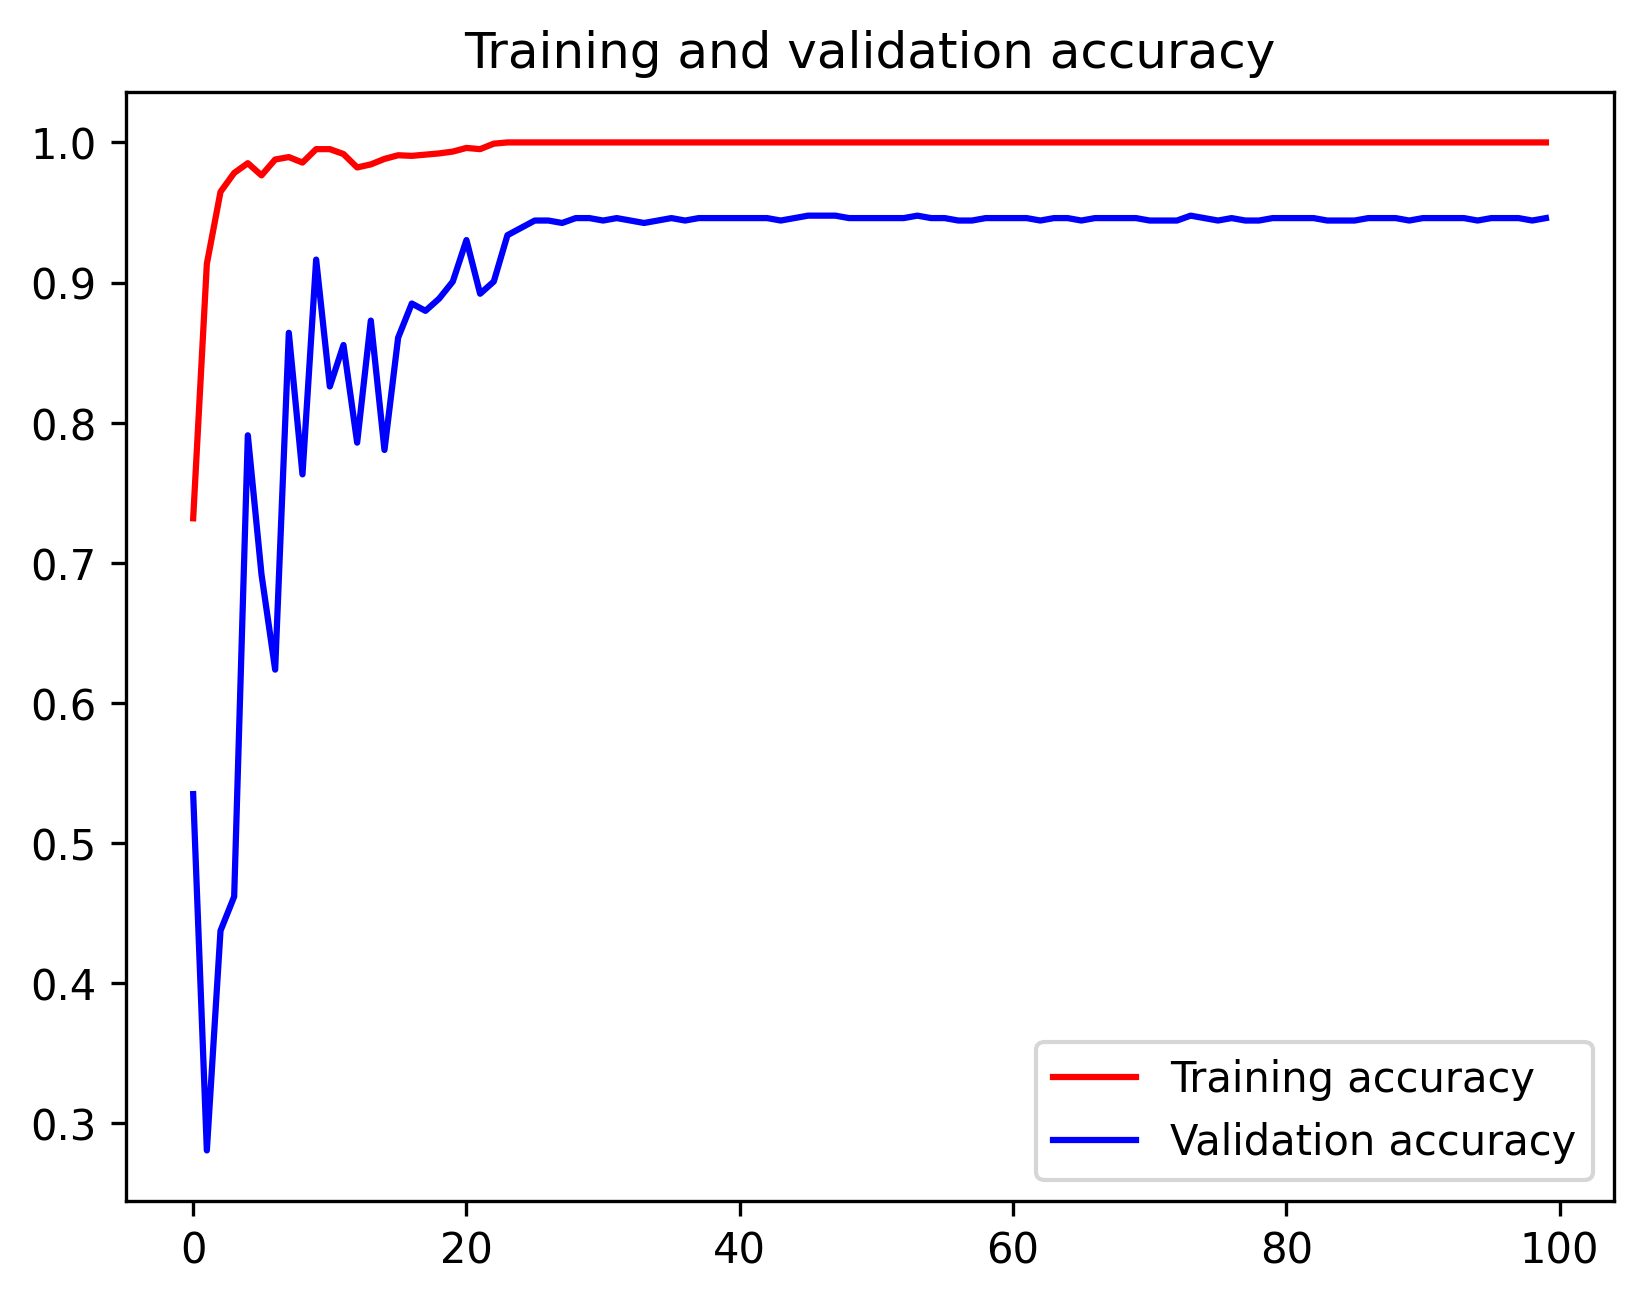

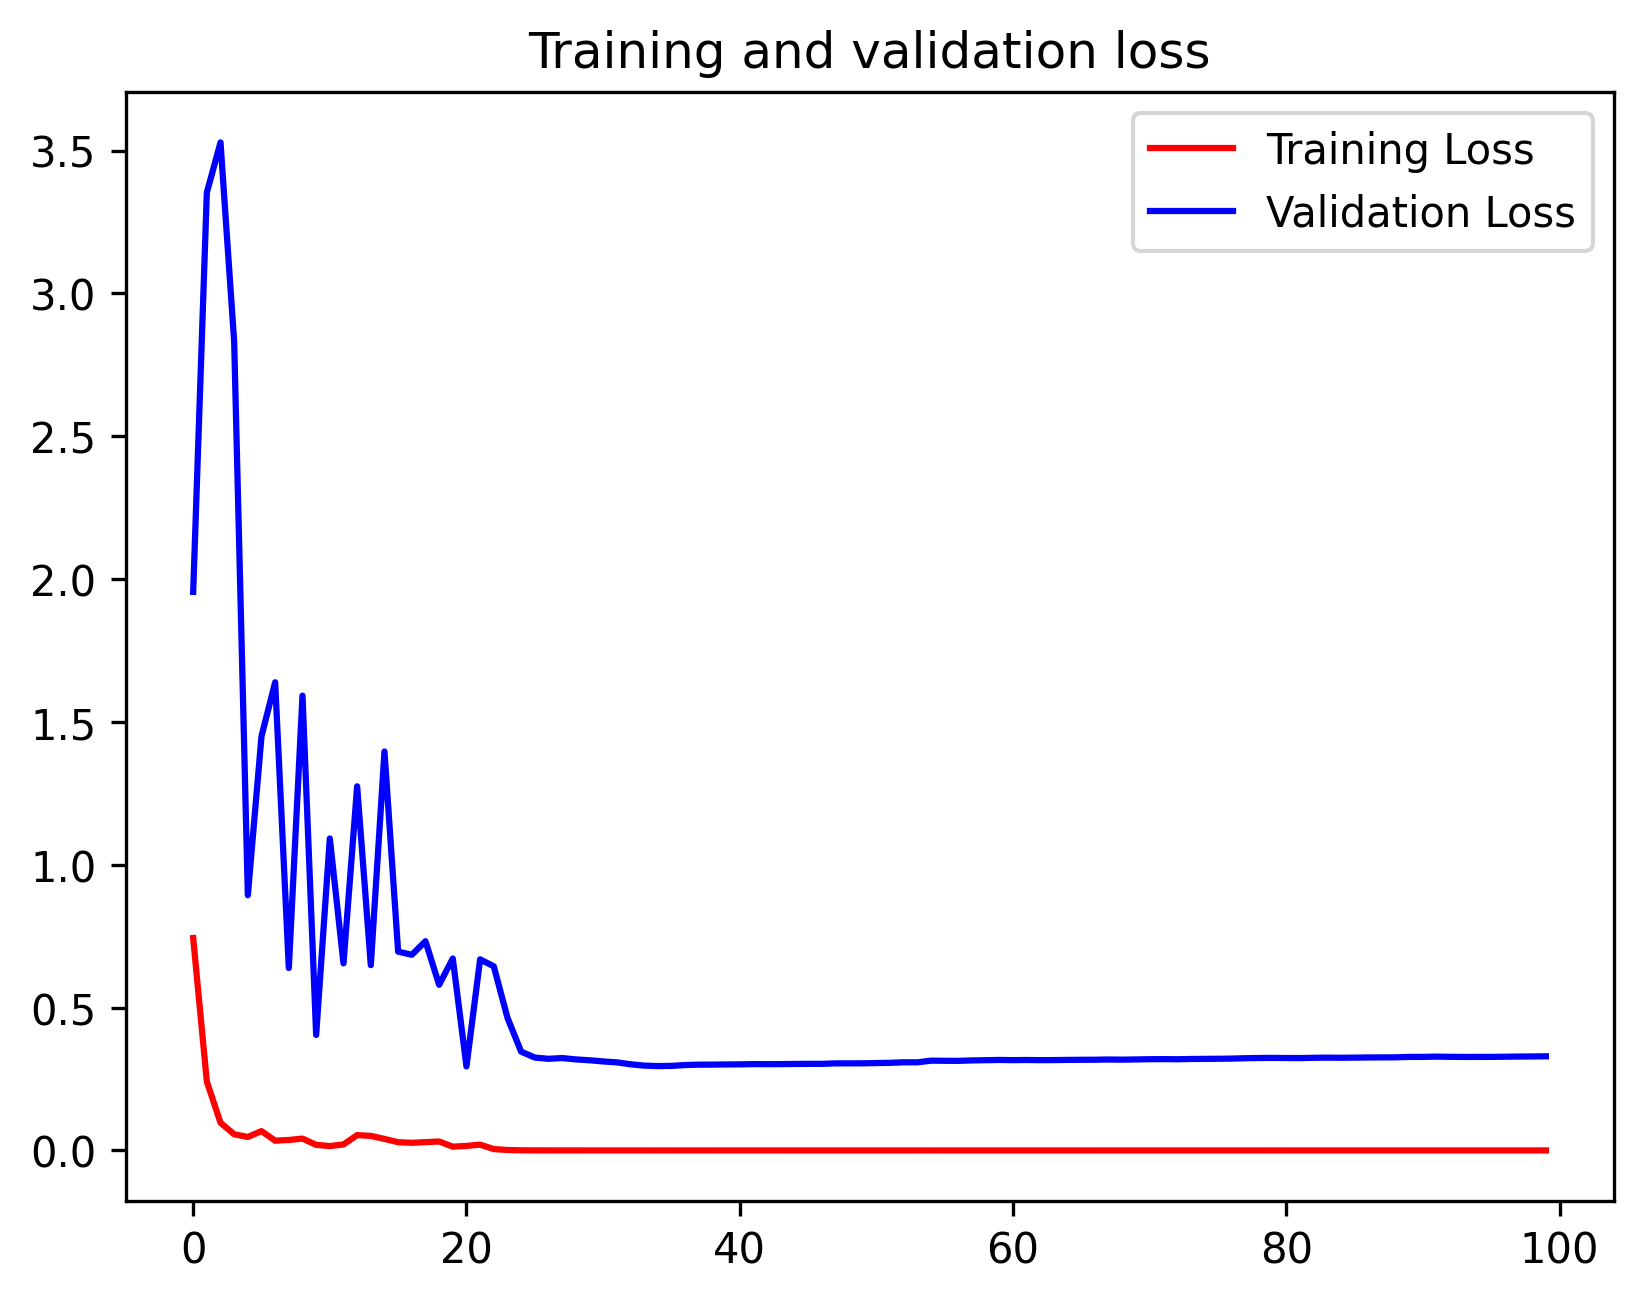

In [68]:
import matplotlib.pyplot as plt
acc = history8.history['accuracy']
val_acc = history8.history['val_accuracy']
loss = history8.history['loss']
val_loss = history8.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

2023-08-06 22:07:36.183989: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-06 22:07:36.246781: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


4/4 [==============================] - 0s 11ms/step


2023-08-06 22:07:42.954223: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-06 22:07:43.088236: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


1/1 [==============================] - 5s 5s/step
                  precision    recall  f1-score   support

meningioma_tumor       1.00      0.19      0.32       100
    glioma_tumor       0.81      0.97      0.88       115
 pituitary_tumor       0.60      0.99      0.75       105
        no_tumor       0.98      0.84      0.91        74

        accuracy                           0.75       394
       macro avg       0.85      0.75      0.71       394
    weighted avg       0.83      0.75      0.71       394



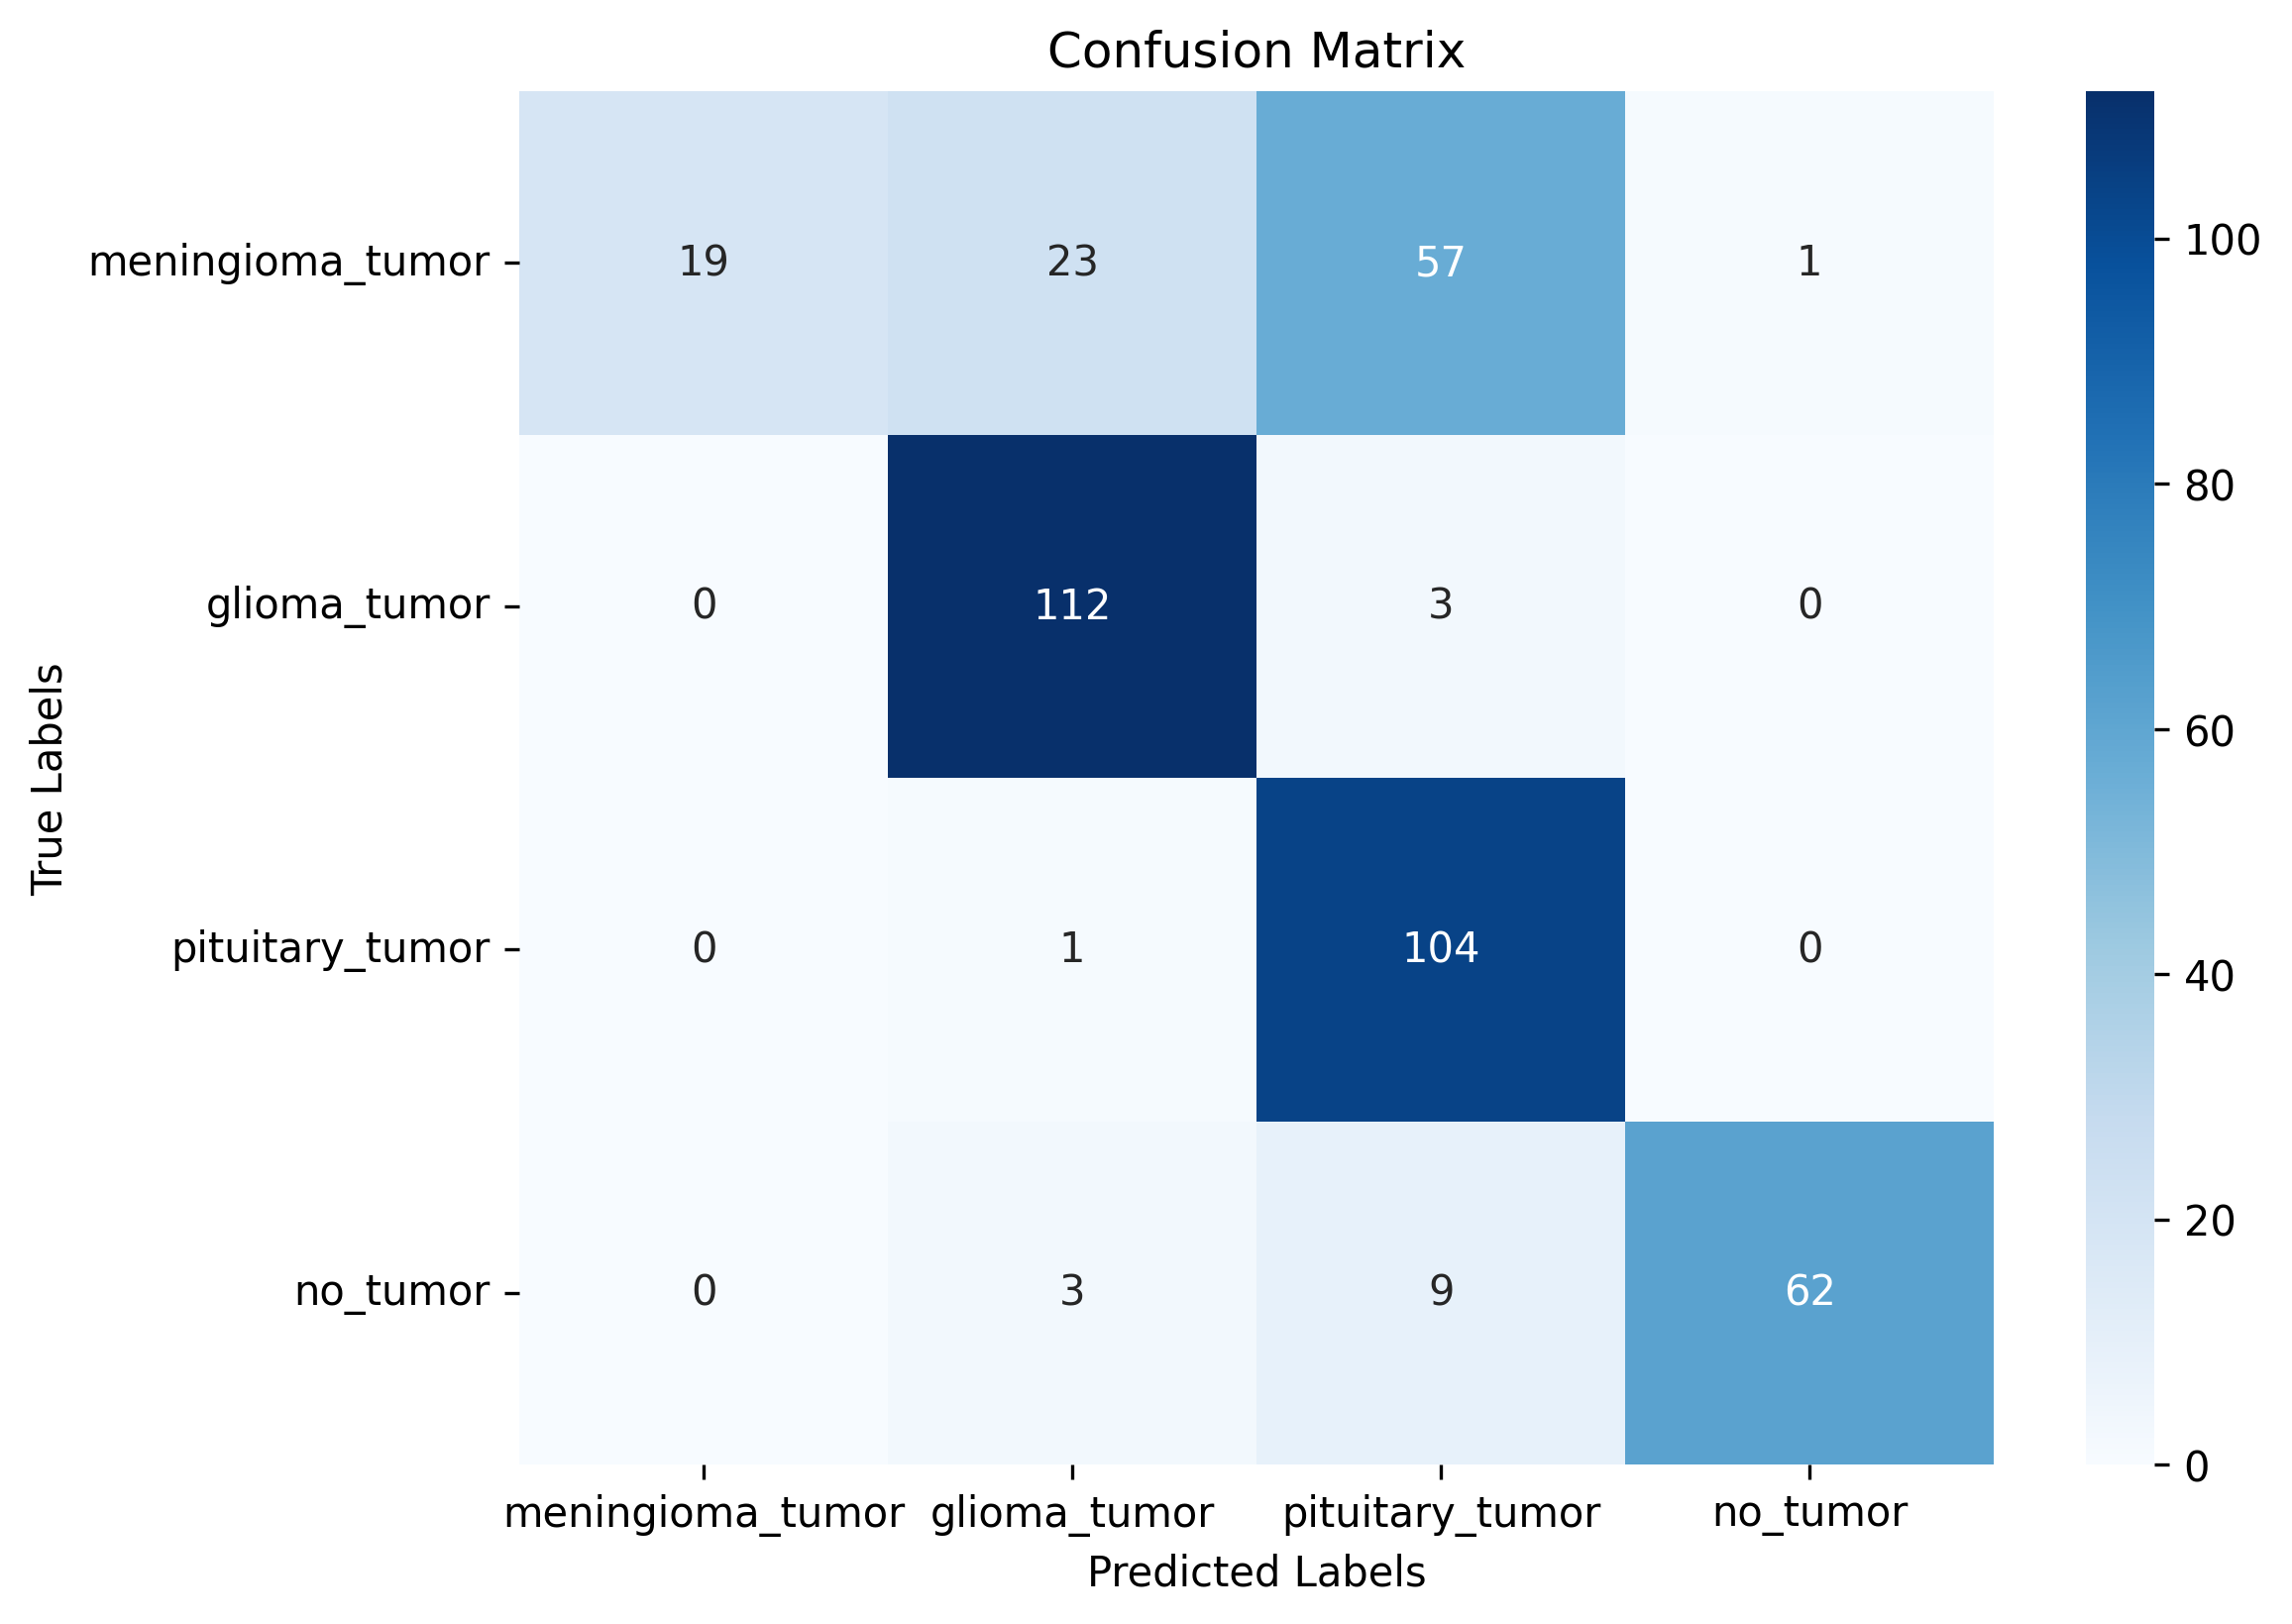

In [69]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have the 'val_ds' data set and 'model' loaded

# Create lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate over 'val_ds' and make predictions
for images, labels in val_ds:
    true_labels.extend(labels)  # Use one-hot encoded labels directly
    predicted_labels.extend(np.argmax(model8.predict(images), axis=1))

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Generate the classification report
class_names = ['meningioma_tumor', 'glioma_tumor', 'pituitary_tumor', 'no_tumor']  # Update with your class names
print(classification_report(true_labels, predicted_labels, target_names=class_names))

# Generate the confusion matrix
confusion = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


### LSTM

### GoogLeNet

### 9. Xception

In [70]:
with tpu_strategy.scope():
    base_model9 = tf.keras.applications.Xception(
                        input_shape=(224, 224, 3),
                        weights='imagenet',
                        include_top=False)
    # Freeze the first 10 layers
    for layer in base_model9.layers[:10]:
        layer.trainable = False
    x = base_model9.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.4)(x)
    predictions9 = Dense(4, activation='softmax')(x)
    model9 = Model(inputs=base_model9.inputs, outputs=predictions9)
    model9.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])
    model9.summary()

83683744/83683744 [==============================] - 1s 0us/step
Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_9[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                    

In [71]:
# model9.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

In [72]:
history9=model9.fit(
  train_ds,
  validation_data=test_ds,
  epochs=100)

model9.save('model9.h5')

Epoch 1/100


2023-08-06 22:08:20.673143: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-06 22:08:21.274268: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


18/18 [==============================] - ETA: 0s - loss: 0.7004 - accuracy: 0.7295

2023-08-06 22:09:25.998454: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-06 22:09:26.212074: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


18/18 [==============================] - 100s 3s/step - loss: 0.7004 - accuracy: 0.7295 - val_loss: 5.1717 - val_accuracy: 0.4599
Epoch 2/100
18/18 [==============================] - 2s 139ms/step - loss: 0.2196 - accuracy: 0.9277 - val_loss: 2.2424 - val_accuracy: 0.5505
Epoch 3/100
18/18 [==============================] - 3s 140ms/step - loss: 0.1271 - accuracy: 0.9586 - val_loss: 6.0469 - val_accuracy: 0.5854
Epoch 4/100
18/18 [==============================] - 7s 390ms/step - loss: 0.0922 - accuracy: 0.9691 - val_loss: 6.6958 - val_accuracy: 0.4111
Epoch 5/100
18/18 [==============================] - 3s 151ms/step - loss: 0.0713 - accuracy: 0.9791 - val_loss: 3.1518 - val_accuracy: 0.6516
Epoch 6/100
18/18 [==============================] - 3s 151ms/step - loss: 0.0694 - accuracy: 0.9800 - val_loss: 1.3698 - val_accuracy: 0.8049
Epoch 7/100
18/18 [==============================] - 3s 152ms/step - loss: 0.0407 - accuracy: 0.9878 - val_loss: 2.5124 - val_accuracy: 0.6725
Epoch 8/100


In [73]:
xception_evaluation = model9.evaluate(val_ds)
xception_evaluation[1]*100

4/4 [==============================] - 7s 2s/step - loss: 2.9739 - accuracy: 0.7741


77.41116881370544

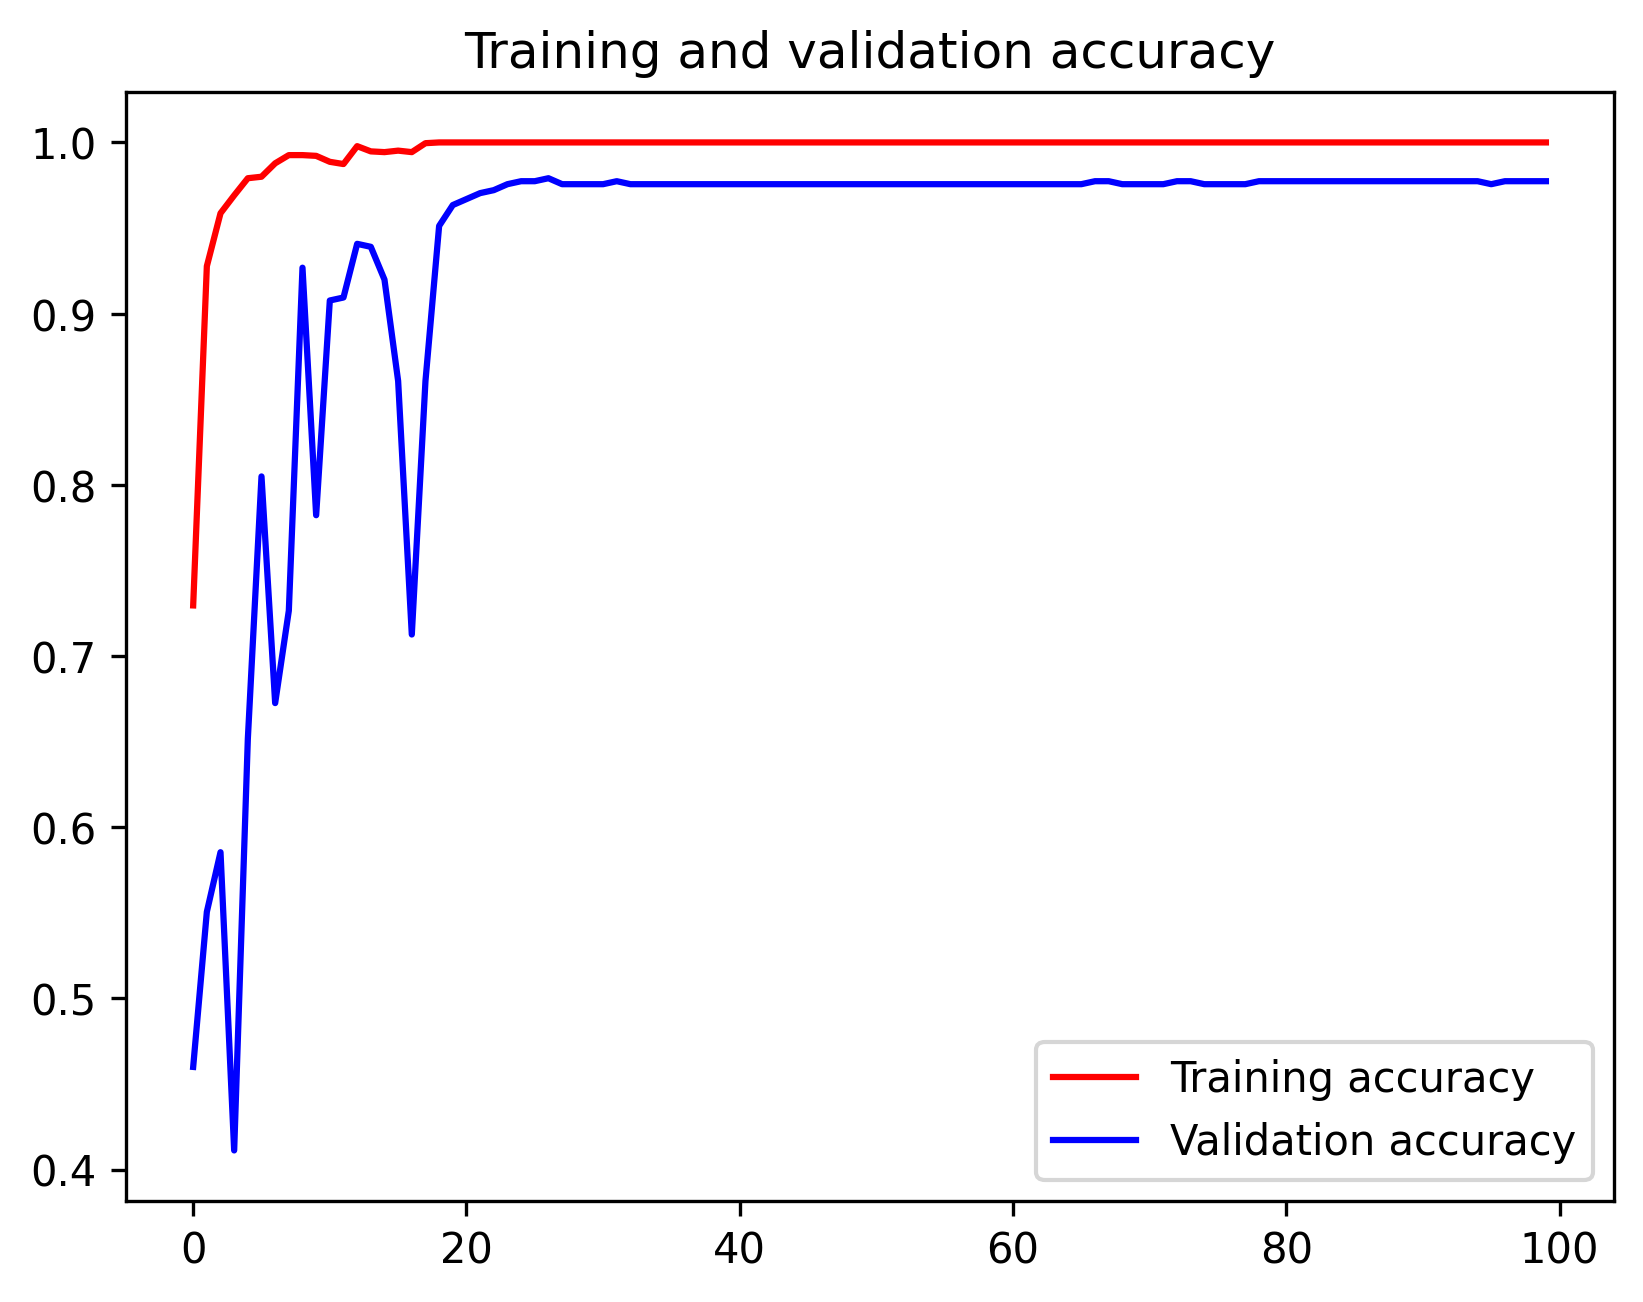

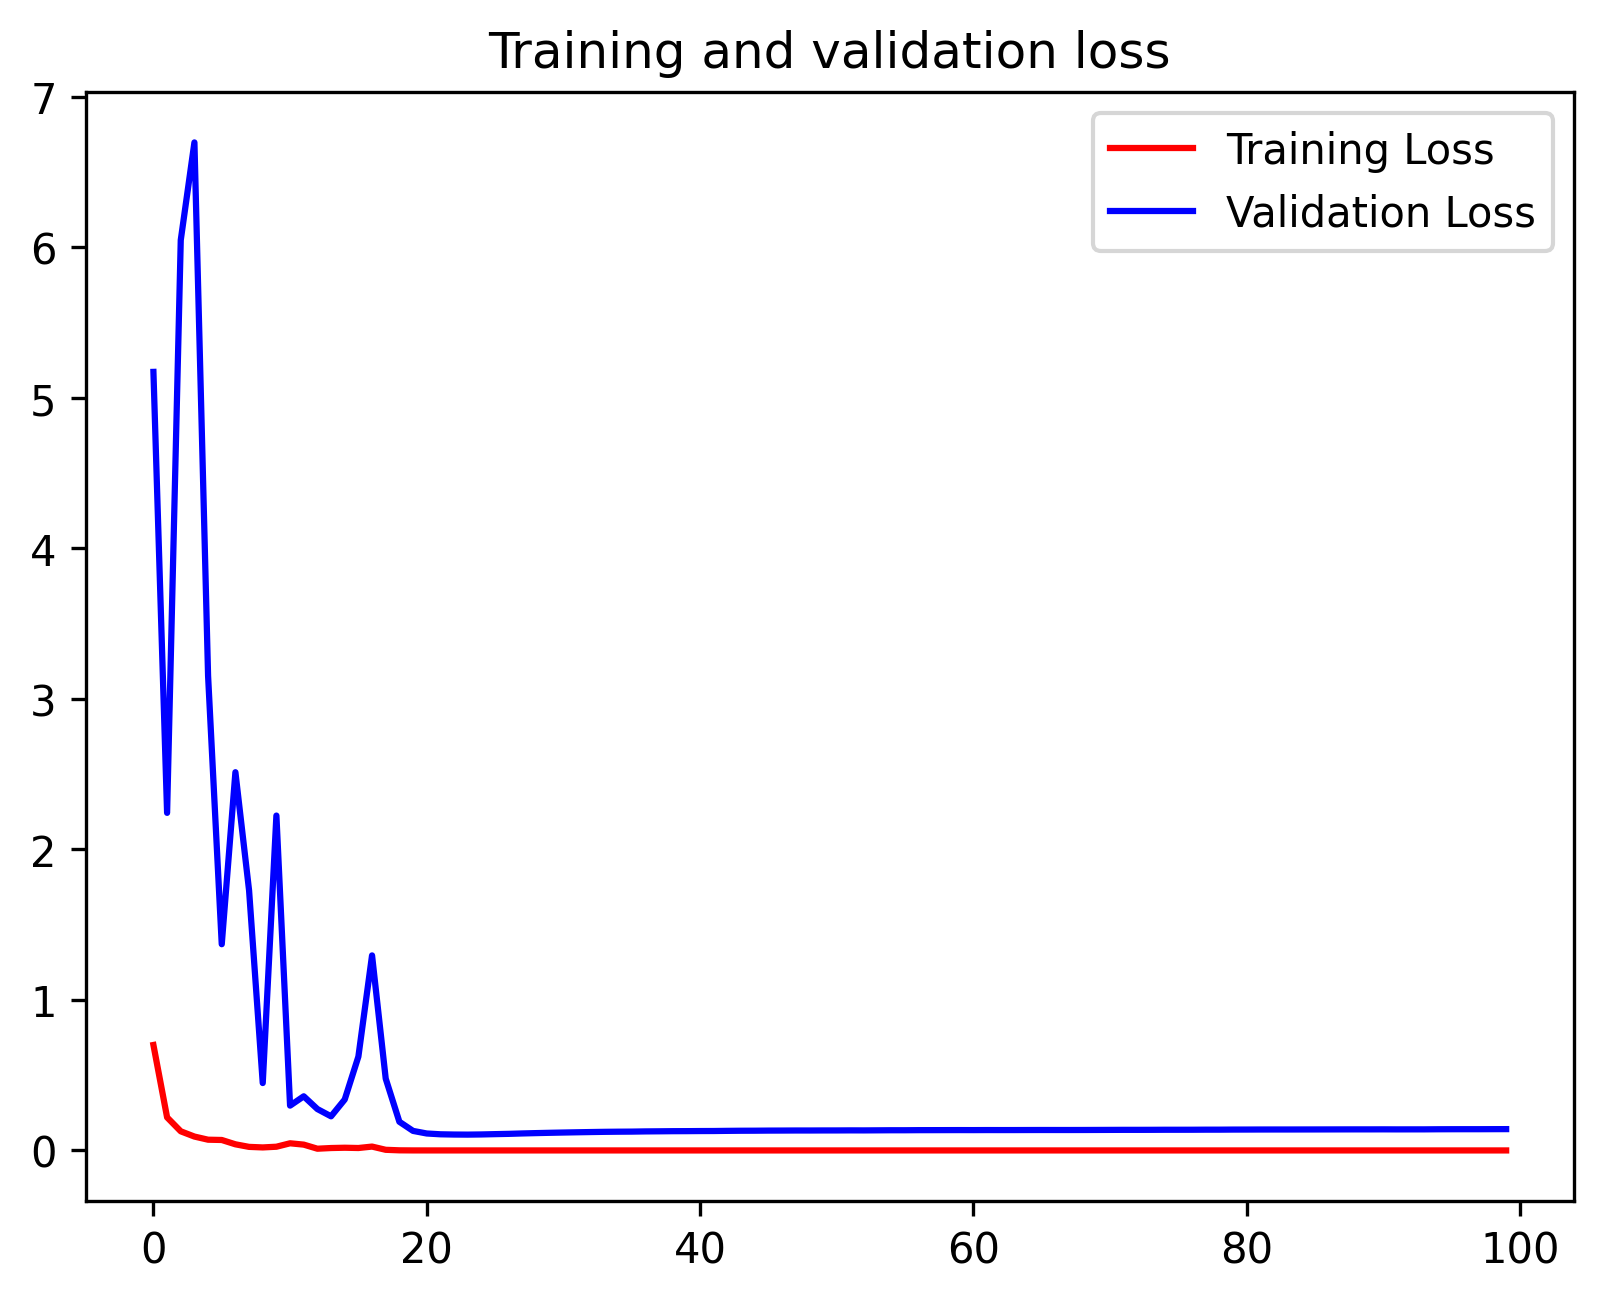

In [74]:
import matplotlib.pyplot as plt
acc = history9.history['accuracy']
val_acc = history9.history['val_accuracy']
loss = history9.history['loss']
val_loss = history9.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

2023-08-06 22:15:01.507881: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-06 22:15:01.614288: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


4/4 [==============================] - 0s 15ms/step


2023-08-06 22:15:11.253199: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-06 22:15:11.444410: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


1/1 [==============================] - 9s 9s/step
                  precision    recall  f1-score   support

meningioma_tumor       1.00      0.29      0.45       100
    glioma_tumor       0.70      0.97      0.82       115
 pituitary_tumor       0.73      0.97      0.84       105
        no_tumor       0.93      0.84      0.88        74

        accuracy                           0.77       394
       macro avg       0.84      0.77      0.75       394
    weighted avg       0.83      0.77      0.74       394



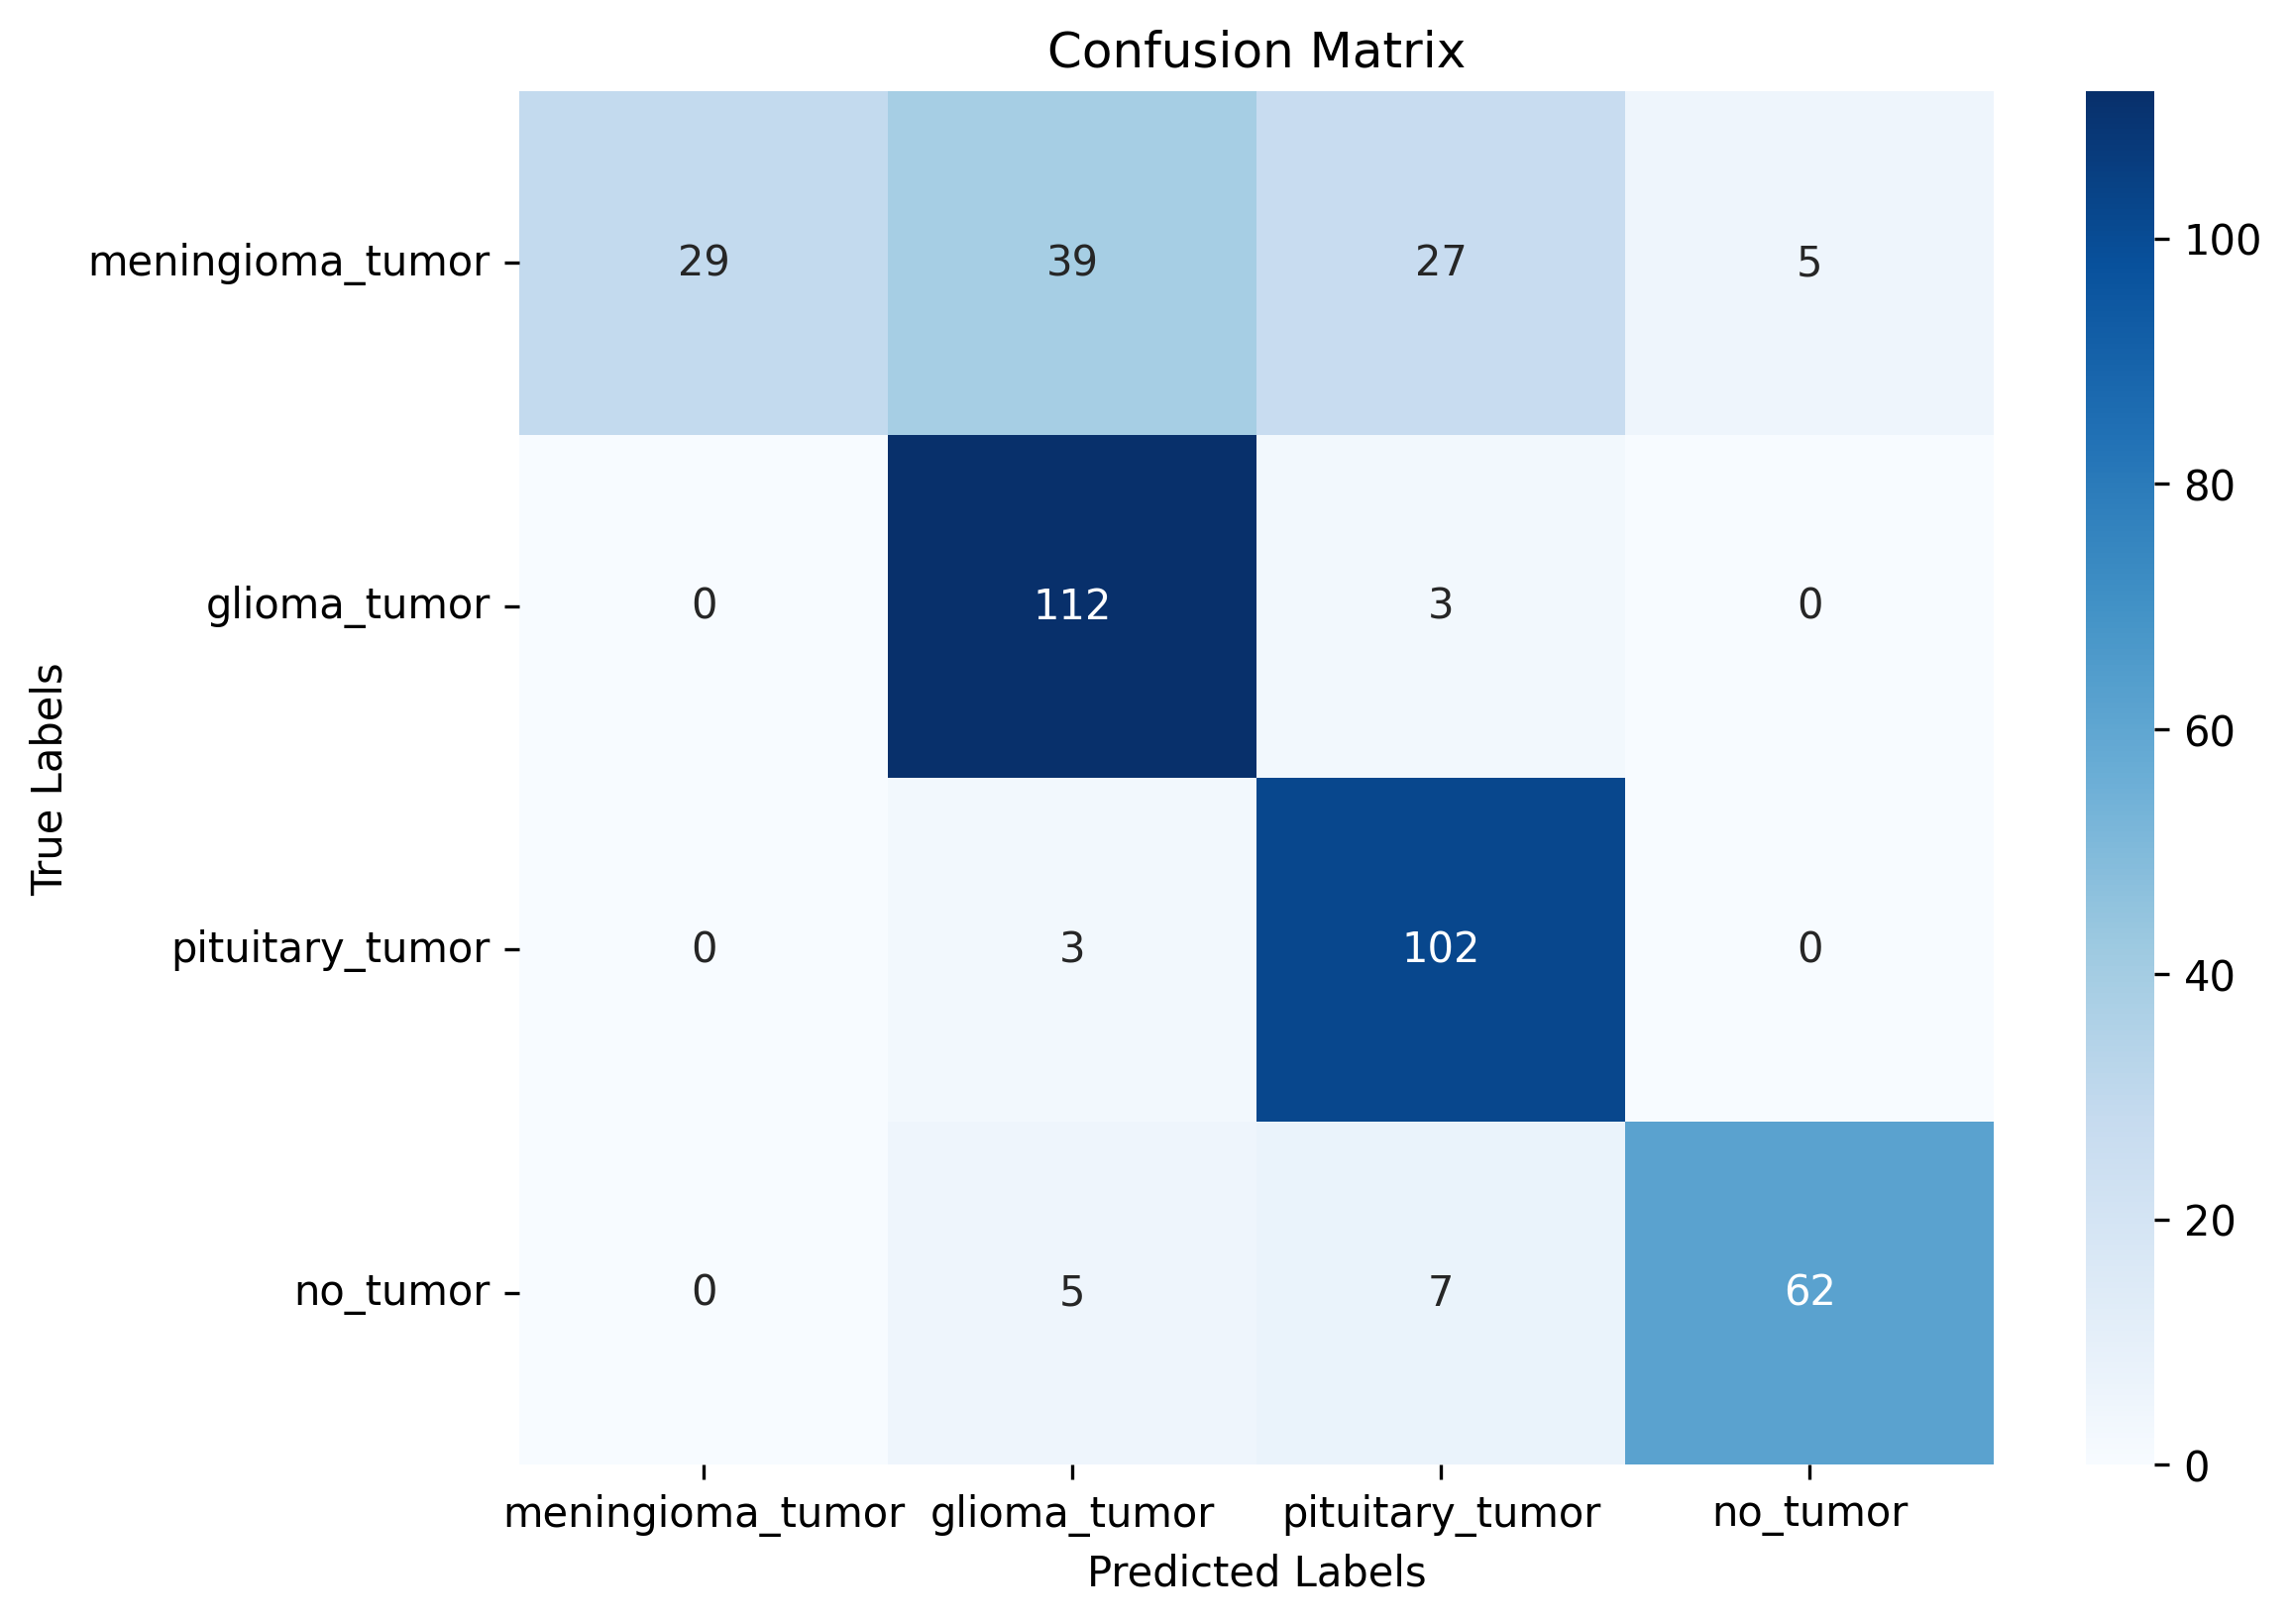

In [75]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have the 'val_ds' data set and 'model' loaded

# Create lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate over 'val_ds' and make predictions
for images, labels in val_ds:
    true_labels.extend(labels)  # Use one-hot encoded labels directly
    predicted_labels.extend(np.argmax(model9.predict(images), axis=1))

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Generate the classification report
class_names = ['meningioma_tumor', 'glioma_tumor', 'pituitary_tumor', 'no_tumor']  # Update with your class names
print(classification_report(true_labels, predicted_labels, target_names=class_names))

# Generate the confusion matrix
confusion = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


### MLP

#### Model Checkpoint

In [76]:
from tensorflow.keras.callbacks import ModelCheckpoint
# Checkpoint to save best model per epoch

model_filepath = "/kaggle/working-{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpoint = ModelCheckpoint(
    filepath=model_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

### Building Ensemble Model

In [77]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Average
with tpu_strategy.scope():
#     model_1 = load_model('/kaggle/working/model1.h5')
#     model_1 = Model(inputs=model_1.inputs,
#                     outputs=model_1.outputs,
#                     name='name_of_model_1')

    model_2 = load_model('/kaggle/working/model2.h5')
    model_2 = Model(inputs=model_2.inputs,
                    outputs=model_2.outputs,
                    name='name_of_model_2')

    model_4 = load_model('/kaggle/working/model4.h5')
    model_4 = Model(inputs=model_4.inputs,
                    outputs=model_4.outputs,
                    name='name_of_model_4')


    model_5 = load_model('/kaggle/working/model5.h5')
    model_5 = Model(inputs=model_5.inputs,
                    outputs=model_5.outputs,
                    name='name_of_model_5')
    
    model_7 = load_model('/kaggle/working/model7.h5')
    model_7 = Model(inputs=model_7.inputs,
                    outputs=model_7.outputs,
                    name='name_of_model_7')
    
    model_9 = load_model('/kaggle/working/model9.h5')
    model_9 = Model(inputs=model_9.inputs,
                    outputs=model_9.outputs,
                    name='name_of_model_9')
    
    

    models = [model_2, model_4, model_5,model_7,model_9]
    model_input = Input(shape=(224, 224, 3))
    model_outputs = [model(model_input) for model in models]
    ensemble_output = Average()(model_outputs)
    ensemble_model = Model(inputs=model_input, outputs=ensemble_output, name='ensemble')
    ensemble_model.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])
    ensemble_model.summary()


Model: "ensemble"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 name_of_model_2 (Functional)   (None, 4)            14979396    ['input_10[0][0]']               
                                                                                                  
 name_of_model_4 (Functional)   (None, 4)            24638852    ['input_10[0][0]']               
                                                                                                  
 name_of_model_5 (Functional)   (None, 4)            55125732    ['input_10[0][0]']        

In [78]:
# ensemble_model.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])


In [79]:
history=ensemble_model.fit(
  train_ds,
  validation_data=test_ds,
  epochs=100)

Epoch 1/100


2023-08-06 22:20:51.377795: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-06 22:20:57.587314: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


18/18 [==============================] - ETA: 0s - loss: 0.0032 - accuracy: 1.0000 

2023-08-06 22:29:51.656881: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-06 22:29:52.872126: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


18/18 [==============================] - 784s 21s/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0.0608 - val_accuracy: 0.9826
Epoch 2/100
18/18 [==============================] - 9s 504ms/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.0623 - val_accuracy: 0.9826
Epoch 3/100
18/18 [==============================] - 9s 504ms/step - loss: 0.0054 - accuracy: 1.0000 - val_loss: 0.1792 - val_accuracy: 0.9843
Epoch 4/100
18/18 [==============================] - 9s 501ms/step - loss: 0.0138 - accuracy: 1.0000 - val_loss: 0.2002 - val_accuracy: 0.9826
Epoch 5/100
18/18 [==============================] - 9s 496ms/step - loss: 0.0118 - accuracy: 1.0000 - val_loss: 0.1501 - val_accuracy: 0.9843
Epoch 6/100
18/18 [==============================] - 9s 494ms/step - loss: 0.0114 - accuracy: 1.0000 - val_loss: 0.2158 - val_accuracy: 0.9843
Epoch 7/100
18/18 [==============================] - 9s 511ms/step - loss: 0.0138 - accuracy: 1.0000 - val_loss: 0.2440 - val_accuracy: 0.9826
Epoch 8/100

In [80]:
ensemble_evaluation = ensemble_model.evaluate(val_ds)
ensemble_evaluation[1]*100

4/4 [==============================] - 32s 10s/step - loss: 2.4187 - accuracy: 0.7690


76.90355181694031

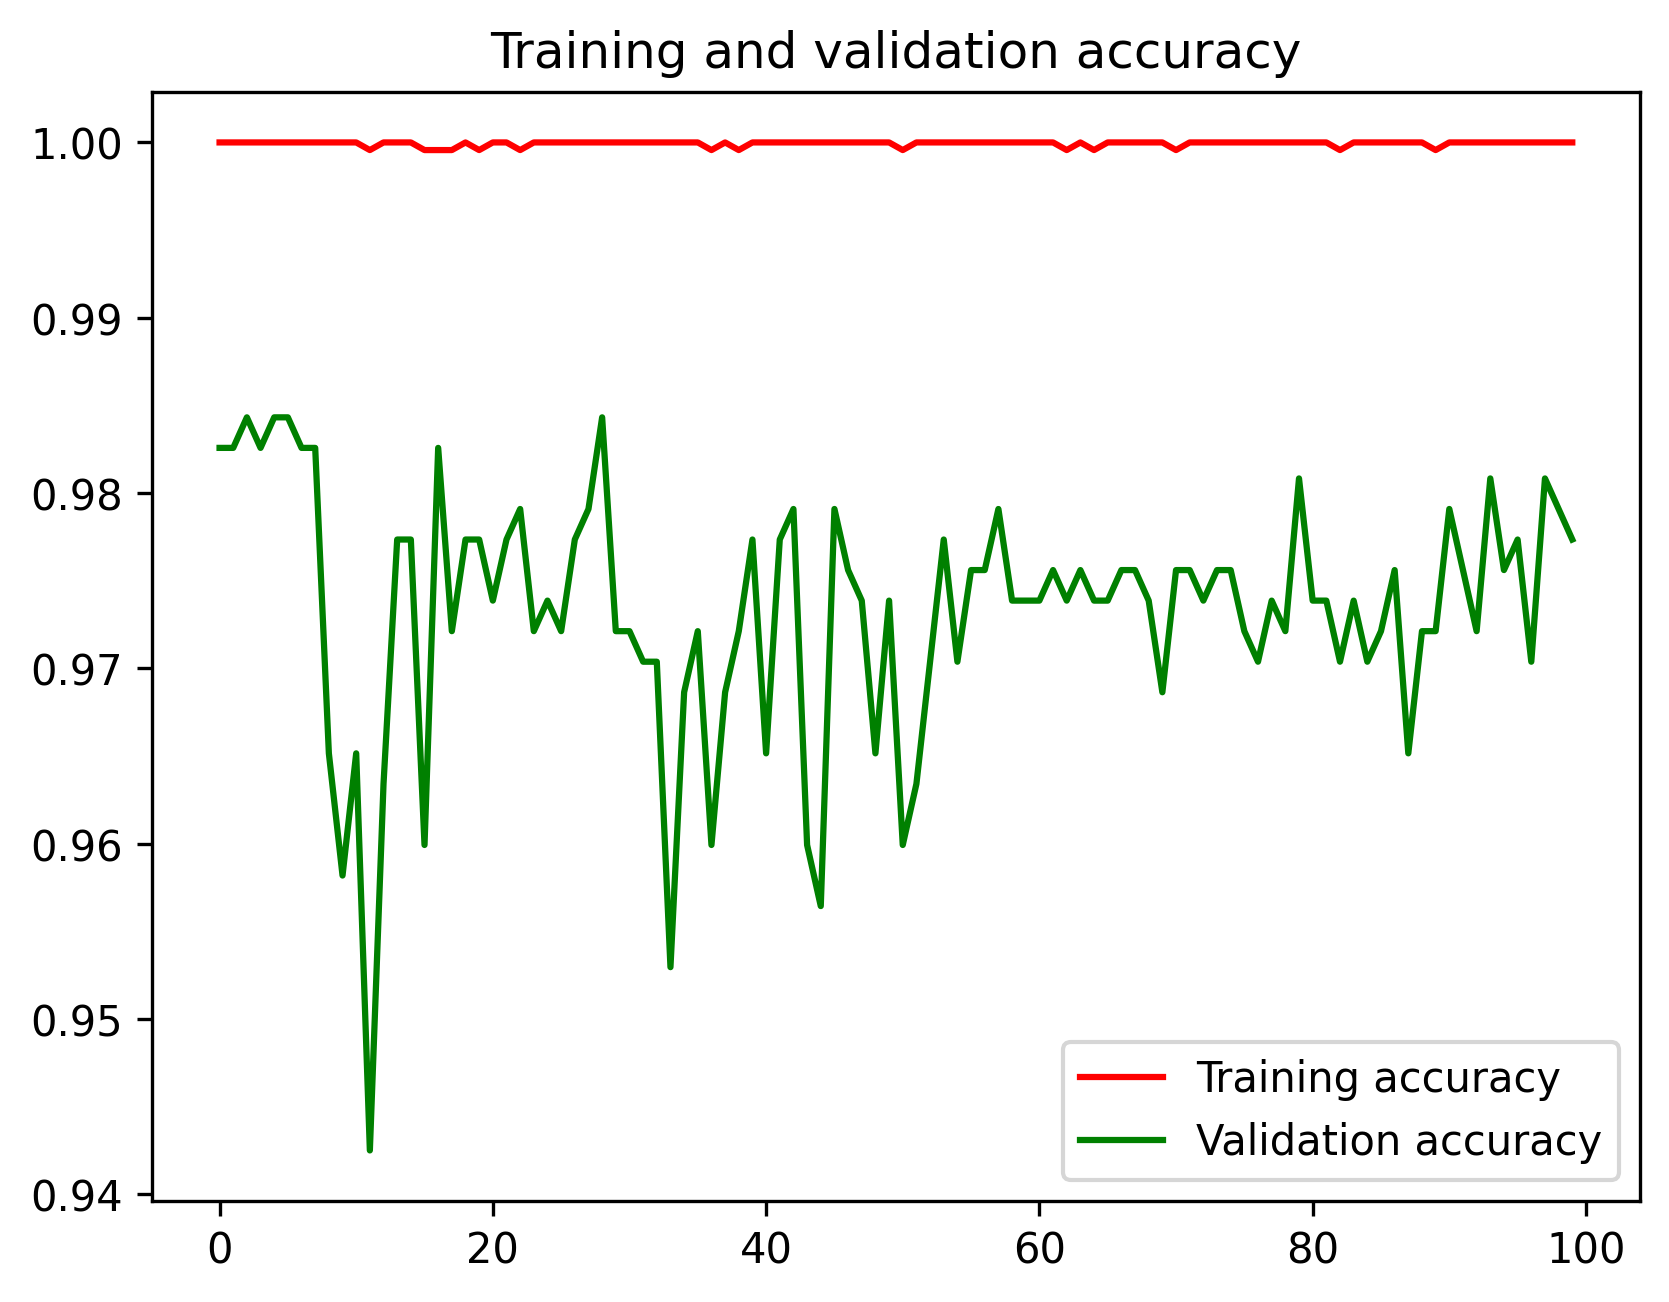

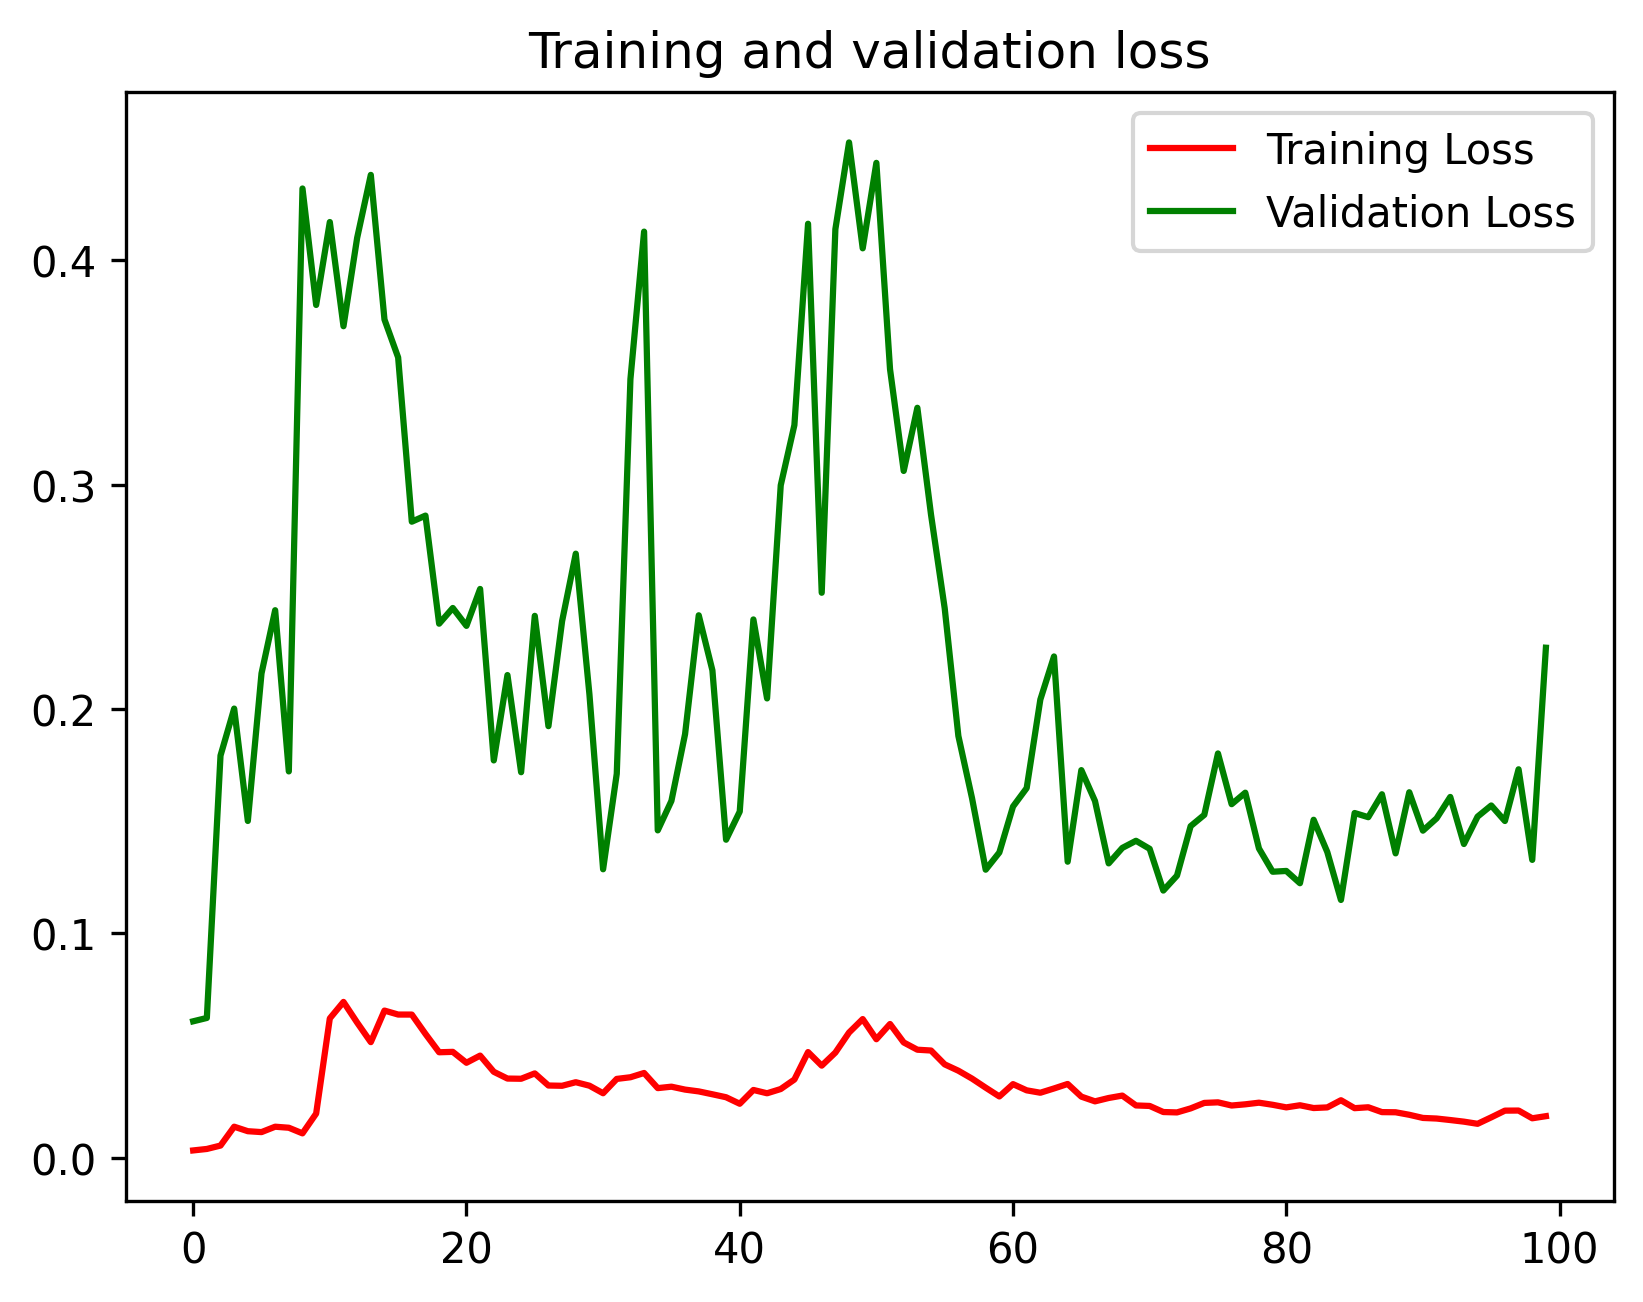

In [81]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'g', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [82]:
train_label = np.concatenate([y for x, y in train_ds], axis=0)
print(train_label.shape)

test_label = np.concatenate([y for x, y in test_ds], axis=0)
print(test_label.shape)

(2296,)
(574,)


/tmp/ipykernel_16/1046815722.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = ensemble_model.predict_generator(test_ds, 1600)
2023-08-06 22:47:42.619811: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-06 22:47:44.083260: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


Confusion Matrix
[[158   5   0   1]
 [  2 162   2   0]
 [  0   2  77   1]
 [  0   0   0 164]]
Classification Report
                  precision    recall  f1-score   support

    glioma_tumor       0.99      0.96      0.98       164
meningioma_tumor       0.96      0.98      0.97       166
        no_tumor       0.97      0.96      0.97        80
 pituitary_tumor       0.99      1.00      0.99       164

        accuracy                           0.98       574
       macro avg       0.98      0.98      0.98       574
    weighted avg       0.98      0.98      0.98       574



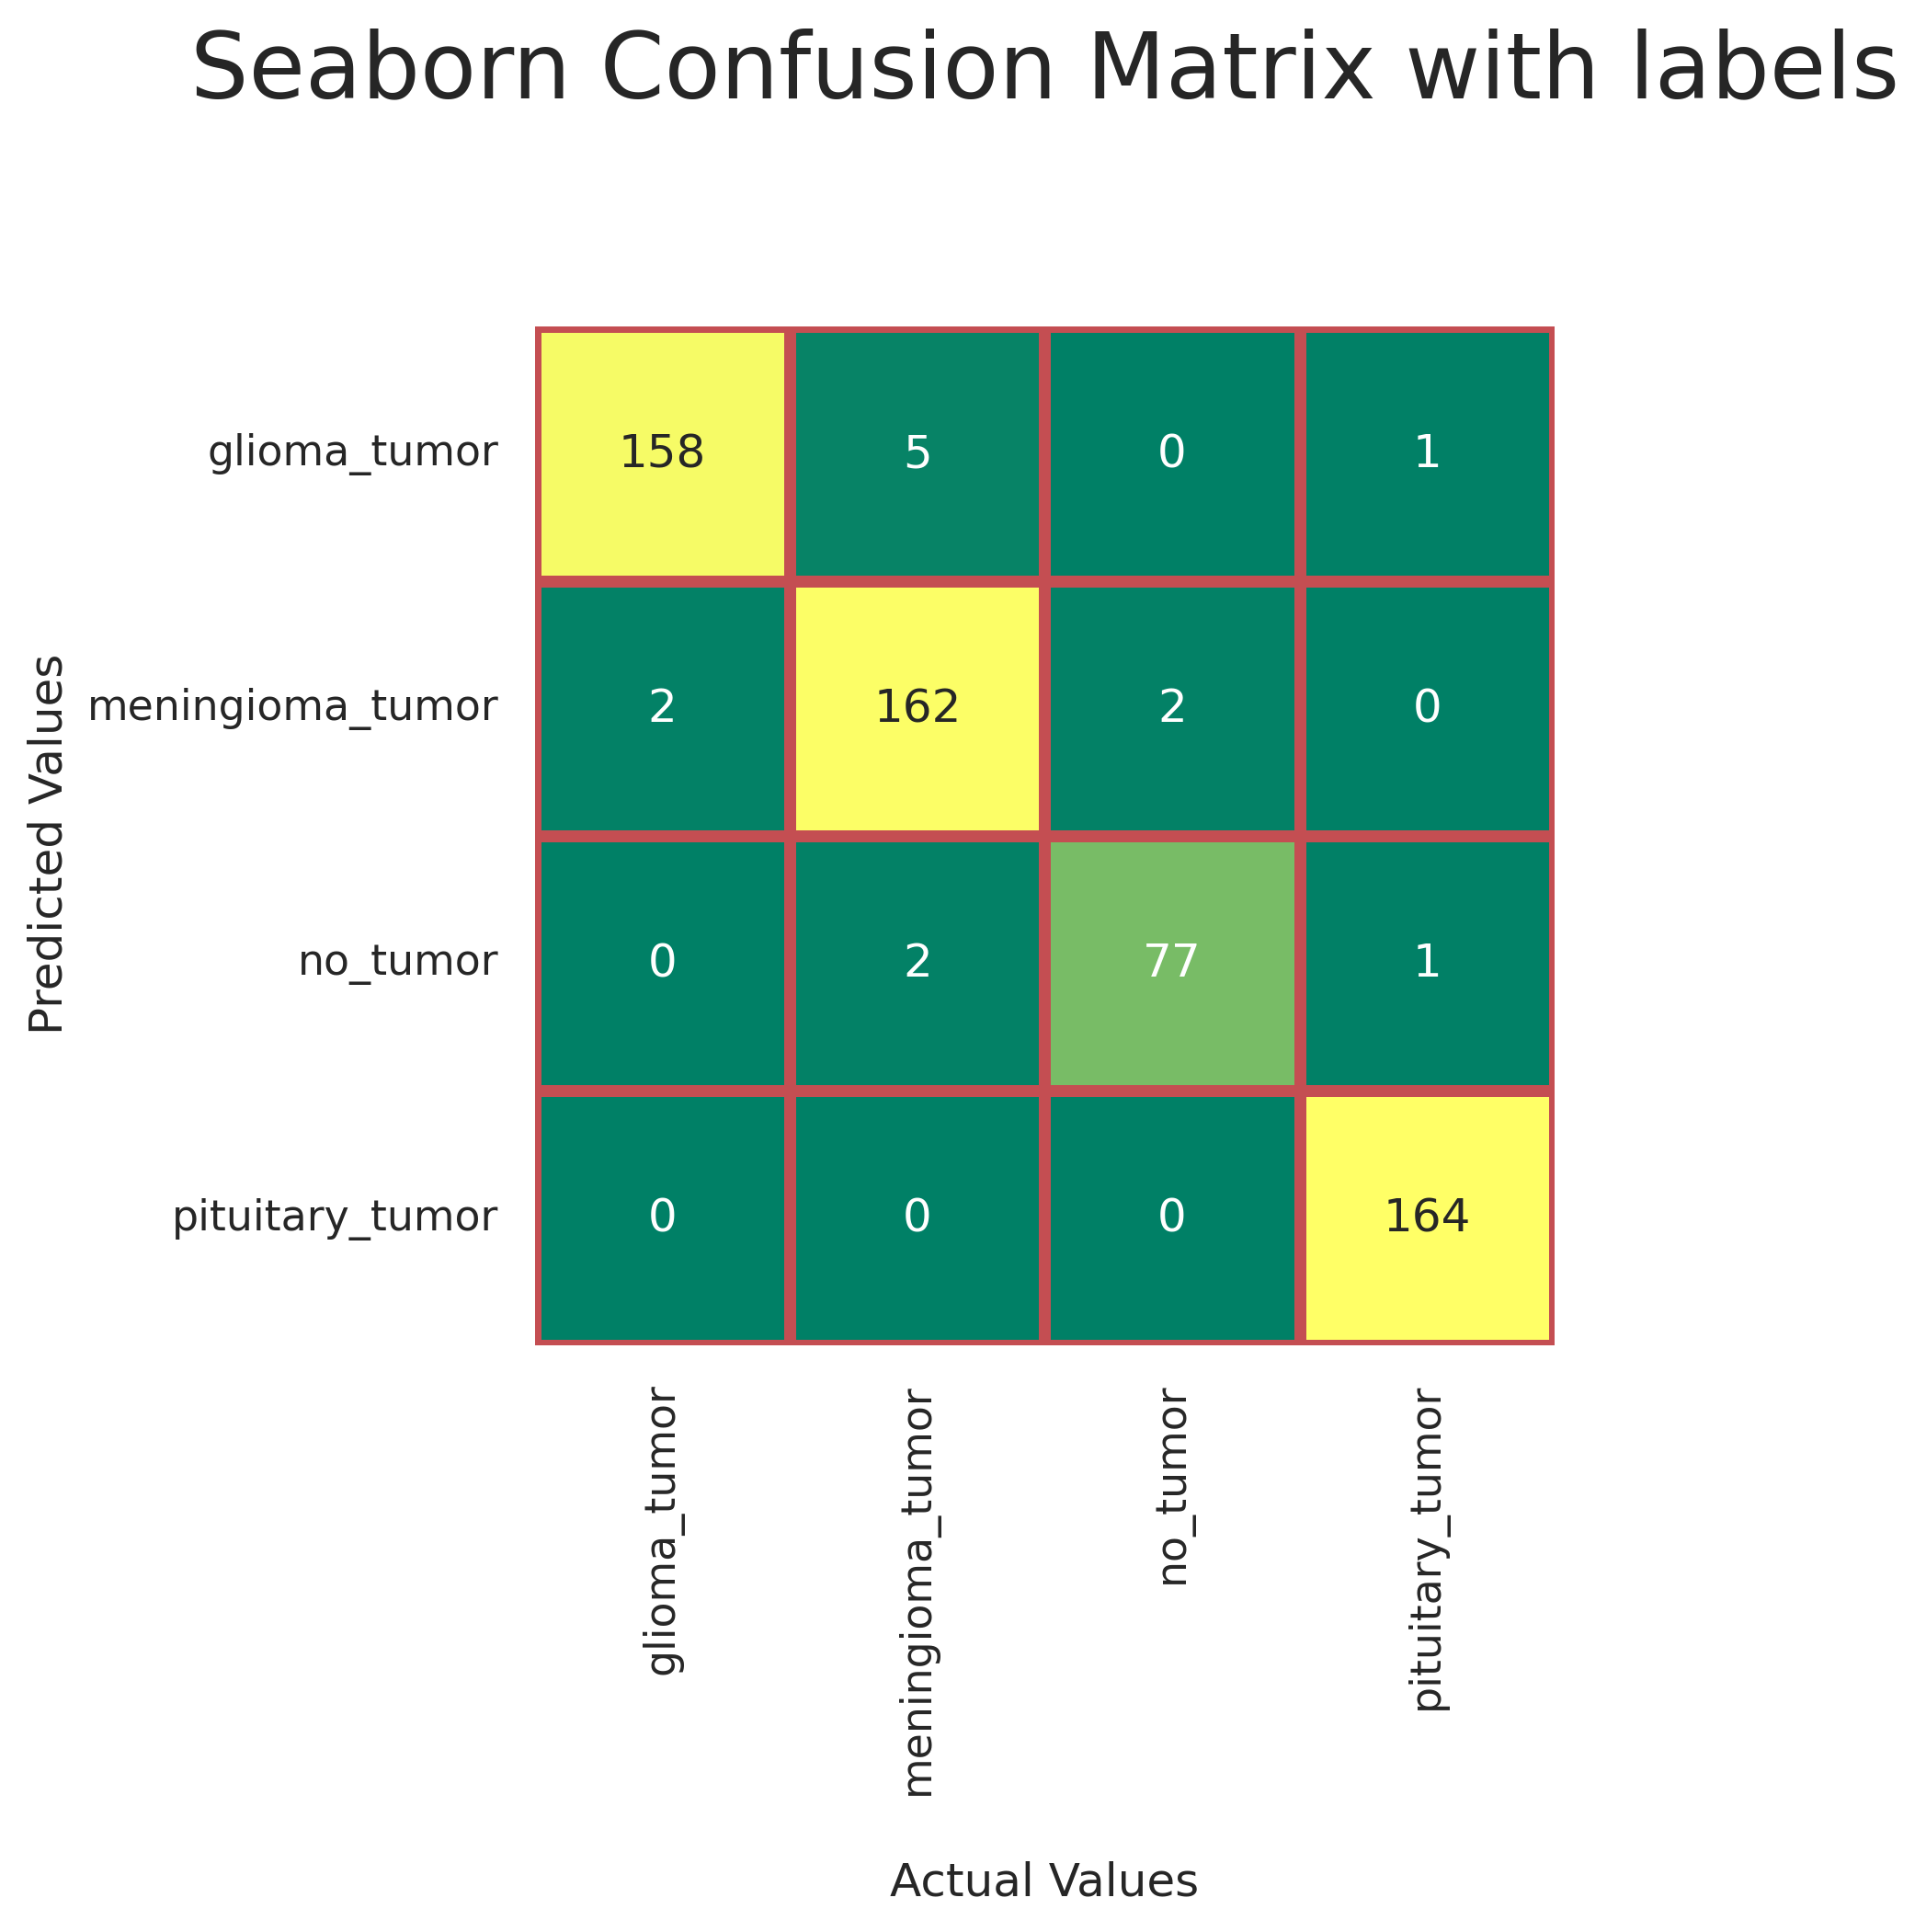

In [83]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
#Confution Matrix and Classification Report
import matplotlib.pyplot as plt
Y_pred = ensemble_model.predict_generator(test_ds, 1600)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm=confusion_matrix(test_label, y_pred)
print(cm)
print('Classification Report')
target_names = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
print(classification_report(test_label, y_pred, target_names=target_names))

import seaborn as sns
sns.set(font_scale=1.0)
ax=sns.heatmap(cm, annot=True, cmap='summer', cbar=False, linewidths=3, linecolor='r', square=True, xticklabels=target_names,yticklabels=target_names,fmt='')
#sns.heatmap(cm, annot=True,annot_kws={"size": 22})
sns.set(font_scale = 2.0)
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nActual Values')
ax.set_ylabel('Predicted Values ');